In [1]:
import source_synphot.passband
import source_synphot.io
import source_synphot.source
import astropy.table as at
from collections import OrderedDict
import pysynphot as S
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
%matplotlib notebook
from tools import *
import sys
sys.path.append('../Sigma_clip/')
import sigmacut

#from zp_fit import *
from scipy.optimize import minimize
from astropy.stats import sigma_clip
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
def myround(x, prec=2, base=.5):
    return round(base * round(float(x)/base),prec)
from scipy.signal import savgol_filter

In [2]:
path = '../stellar_spec/pickle/'
files = glob(path + '*.dat')
files = [x for x in files if (('ukr' not in x) and ('ukw' not in x))]
def Specs(Specs):
    specs = {}
    for spec in Specs:
        model_sed = source_synphot.source.pre_process_source(spec,np.nan,'ps1g',0,Renorm=False)
        specs[spec] = model_sed
    return specs
pickle = Specs(files)

Warning, 36 of 4771 bins contained negative fluxes; they have been set to zero.
Warning, 42 of 4771 bins contained negative fluxes; they have been set to zero.


In [3]:
pickle

{'../stellar_spec/pickle/ukb3v.dat': <pysynphot.spectrum.ArraySourceSpectrum at 0x1046e3208>,
 '../stellar_spec/pickle/ukb1i.dat': <pysynphot.spectrum.ArraySourceSpectrum at 0x1046dd710>,
 '../stellar_spec/pickle/ukf2v.dat': <pysynphot.spectrum.ArraySourceSpectrum at 0x1c18dc22e8>,
 '../stellar_spec/pickle/ukf0i.dat': <pysynphot.spectrum.ArraySourceSpectrum at 0x1c1925e7b8>,
 '../stellar_spec/pickle/ukm4iii.dat': <pysynphot.spectrum.ArraySourceSpectrum at 0x1c190bc198>,
 '../stellar_spec/pickle/ukk3iv.dat': <pysynphot.spectrum.ArraySourceSpectrum at 0x1c18d5be48>,
 '../stellar_spec/pickle/ukm8iii.dat': <pysynphot.spectrum.ArraySourceSpectrum at 0x1c18c926a0>,
 '../stellar_spec/pickle/ukk7v.dat': <pysynphot.spectrum.ArraySourceSpectrum at 0x1c19001e10>,
 '../stellar_spec/pickle/ukf2ii.dat': <pysynphot.spectrum.ArraySourceSpectrum at 0x1c18dc2e80>,
 '../stellar_spec/pickle/ukg8v.dat': <pysynphot.spectrum.ArraySourceSpectrum at 0x1c18d5bb70>,
 '../stellar_spec/pickle/ukf0ii.dat': <pysynph

models = at.Table.read('ckmodels.txt',format='ascii')
logZ = 0.
model_sed_names = []
temp = []
for s in models:
    teff = max(3500.,s['teff'])
    logg = myround(s['logg'])
    # the models with logg < 1 are just padded with 0s
    if logg >= 1:
        temp.append(teff)
        modstring = 'ckmod{:.0f}_{:.1f}_{:.2f}'.format(teff,logZ, logg)
        model_sed_names.append(modstring)
model_sed = source_synphot.source.load_source(model_sed_names)

In [3]:
passbands = at.Table.read('source_synphot/passbands/pbzptmag.txt',format='ascii')
pbnames = [x['obsmode'] for x in passbands if x['passband'].startswith("Kep")]
pbnames += [x['obsmode'] for x in passbands if x['passband'].startswith("PS1")]
model_mags = 0.
model = 'AB'
pbs = source_synphot.passband.load_pbs(pbnames, model_mags, model)
pbnames = pbs.keys()

In [4]:
mags = Spec_mags(pickle,pbs)

In [5]:
data = pd.read_csv('../calibration/kepler/K2_all_PS1_psc_ev.csv')
data = data.iloc[(data['ps_score'].values > 0.8) & (data['PDC'].values > 0)]
#cind =  ((data['campaign'].values == 16) & (data['Channel'].values == 70))
gb = data['gMeanPSFMag'].values
gbe = data['gMeanPSFMagErr'].values
rb = data['rMeanPSFMag'].values
rbe = data['rMeanPSFMagErr'].values
ib = data['iMeanPSFMag'].values
ibe = data['iMeanPSFMagErr'].values
kb = -2.5*np.log10(data['PDC'].values)
kbe = np.abs(data['PDCe'].values) / np.abs(data['PDC'].values)

In [34]:

def Plotter(K,Colours,Compare,Channel, Residuals = False, Close = True):
    Params = Parms_dict(K)
    plt.figure(figsize=(10,6))
    plt.suptitle('Channel ' + str(Channel) + ', Zp = ' + str(np.round(K[0],3)) + 
                 '\n' + 'Ak ={}, Ag = {}, Ar = {}, Ai ={}'.format(np.round(Params['Ak'],3),
                                                                  np.round(Params['Ag'],3),
                                                                  np.round(Params['Ar'],3),
                                                                  np.round(Params['Ai'],3)))
    for i in range(len(Compare)):
        X,Y = Compare[i]
        keys = np.array(list(Colours.keys()))
        xind = 'mod ' + X == keys
        x = Colours[keys[xind][0]]
        yind = 'mod ' + Y == keys
        y = Colours[keys[yind][0]]

        x_interp = np.arange(np.nanmin(x),0.8,0.01)
        inter = interpolate.interp1d(x,y)
        l_interp = inter(x_interp)
        locus = np.array([x_interp,l_interp])
        ind  = np.where((locus[0,:] <= 0.8) & (locus[0,:] >= 0.2))[0]
        locus = locus[:,ind]
        # observed
        xind = 'obs ' + X == keys
        x = Colours[keys[xind][0]]
        yind = 'obs ' + Y == keys
        y = Colours[keys[yind][0]]
        #print(X,Y)
        c1,c2 = X.split('-')
        c3,c4 = Y.split('-')
        #print(c1,c2,c3,c4)

        # parameters
        ob_x = x.copy() 
        ob_x[0,:] += Params['A'+c1] - Params['A'+c2]
        if c1 == 'k': ob_x += Params['kzp']
        if c2 == 'k': ob_x -= Params['kzp']

        ob_y = y.copy() 
        ob_y[0,:] += Params['A'+c3] - Params['A'+c4]
        if c3 == 'k': ob_y[0,:] += Params['kzp']
        if c4 == 'k': ob_y[0,:] -= Params['kzp']

        ind = np.where((Colours['obs g-r'][0,:] <= .8) & (Colours['obs g-r'][0,:] >= 0.2))[0]
        ob_x = ob_x[:,ind]
        ob_y = ob_y[:,ind]
        
        
        plt.subplot(2,2,i+1)
        plt.xlabel(X)
        plt.ylabel(Y)
        if i == 2:
            if Residuals:
                dist = Dist_tensor(X,Y,Params,Colours,Tensor = True)
                
                plt.errorbar(ob_x[0,:],dist,ob_y[1,:],fmt='.',alpha=0.4,label='Observed')
                plt.axhline(0,ls='--',color='k',label='Model')
                plt.legend(loc='upper center', bbox_to_anchor=(1.5, .5))
                #plt.ylim(-.6, .6)
            else:
                plt.errorbar(ob_x[0,:],ob_y[0,:],ob_y[1,:],fmt='.',alpha=0.4,label='Observed')
                plt.plot(locus[0,:],locus[1,:],label='Model')
                plt.legend(loc='upper center', bbox_to_anchor=(1.5, .5))
                plt.xlim(0.2, .8)
                #plt.ylim(-.5, 1)
        else:
            if Residuals:
                dist = Dist_tensor(X,Y,Params,Colours,Tensor = True)
                plt.axhline(0,ls='--',color='k')
                plt.errorbar(ob_x[0,:],dist,ob_y[1,:],fmt='.',alpha=0.4)
                #plt.ylim(-.6, .6)
            else:
                plt.errorbar(ob_x[0,:],ob_y[0,:],ob_y[1,:],fmt='.',alpha=0.4)
                plt.plot(locus[0,:],locus[1,:])
                #plt.xlim(-0.5, 1)
                plt.xlim(0.2, .8)
                #plt.ylim(-.5, 1)
    plt.subplots_adjust(wspace=.25,hspace=.2)
    if Residuals:
        plt.savefig('./figs/Fit_channel_' + str(Channel) + '_residual.png')
    else:
        plt.savefig('./figs/Fit_channel_' + str(Channel) + '.png')
    if Close:
        plt.close()
    
def Dot_prod_error(x,y,Model):
    """
    Calculate the error projection in the direction of a selected point.
    """
    #print(Model.shape)
    adj = y[0,:] - Model[1,:]
    op = x[0,:] - Model[0,:]
    #print(adj.shape,op.shape)
    hyp = np.sqrt(adj**2 + op**2)
    costheta = adj / hyp
    yerr_proj = abs(y[1,:] * costheta)
    xerr_proj = abs(x[1,:] * costheta)
    
    proj_err = yerr_proj + xerr_proj
    #print(proj_err)
    return proj_err    
    
def Dist_tensor(X,Y,Params,Colours,Tensor=False,Plot = False):
    keys = np.array(list(Colours.keys()))
    xind = 'mod ' + X == keys
    x = Colours[keys[xind][0]]
    yind = 'mod ' + Y == keys
    y = Colours[keys[yind][0]]
    
    x_interp = np.arange(np.nanmin(x),0.8,0.01)
    inter = interpolate.interp1d(x,y)
    l_interp = inter(x_interp)
    locus = np.array([x_interp,l_interp])
    # observed
    xind = 'obs ' + X == keys
    x = Colours[keys[xind][0]]
    yind = 'obs ' + Y == keys
    y = Colours[keys[yind][0]]
    #print(X,Y)
    c1,c2 = X.split('-')
    c3,c4 = Y.split('-')
    #print(c1,c2,c3,c4)
    

    # parameters
    ob_x = x.copy() 
    ob_y = y.copy() 
    indo = np.where((Colours['obs g-r'][0,:] <= .8) & (Colours['obs g-r'][0,:] >= 0.2))
    
    ob_x[0,:] += Params['A'+c1] - Params['A'+c2]
    if c1 == 'k': ob_x[0,:] += Params['kzp']
    if c2 == 'k': ob_x[0,:] -= Params['kzp']

    
    ob_y[0,:] += Params['A'+c3] - Params['A'+c4]
    if c3 == 'k': ob_y[0,:] += Params['kzp']
    if c4 == 'k': ob_y[0,:] -= Params['kzp']
    
    ind = np.where((Colours['obs g-r'][0,:] <= .8) & (Colours['obs g-r'][0,:] >= 0.2))[0]
    ob_x = ob_x[:,ind]
    ob_y = ob_y[:,ind]
    
    
    if Plot:
        plt.figure()
        plt.title(X + ' ' + Y)
        plt.plot(ob_x[0,:],ob_y[0,:],'.')
        plt.plot(locus[0,:],locus[1,:])
    #print(ob_x.shape)
    dist_tensor = []
    dt = []
    #print(Y + ' ', ob_y.shape[1])
    for i in range(ob_y.shape[1]):
        dist = np.sqrt((ob_x[0,i] - locus[0,:])**2 + (ob_y[0,i] - locus[1,:])**2) 
        dt += [dist]
        dist_tensor += [dist]
        
    
    dist_tensor = np.array(dist_tensor)
    dt = np.array(dt)
    #print(X + Y +' dist ',dist_tensor.shape)
    if len(dist_tensor) > 0:
        minind = np.nanargmin(abs(dist_tensor),axis=1)

        proj_err = Dot_prod_error(ob_x,ob_y,locus[:,minind])
        mindist = np.nanmin(abs(dist_tensor),axis=1)
        if Tensor:
            
            eh = []
            for i in range(len(dist_tensor)):
                ind = np.where(np.nanmin(abs(dist_tensor[i,:])) == abs(dist_tensor[i,:]))[0]
                sign = (ob_y[0,i] - locus[1,ind]) / (abs(ob_y[0,i] - locus[1,ind]))
                eh += [dist_tensor[i,ind] * sign]
            eh = np.array(eh)
            
            return eh#np.nanmin(abs(dt),axis=1)
        if len(mindist) > 0:
            residual = np.nansum(mindist) #/ proj_err)
        else:
            #print('infs')
            residual = np.inf
    else:
        if Tensor:
            return []
        residual = np.inf
        #residual += 100*np.sum(np.isnan(dist))
    #print(residual)
    cut_points = len(indo) - len(ind)
    return residual + cut_points * 100



import copy
def Get_lcs(X,Y,Params,Colours):
    keys = np.array(list(Colours.keys()))

    xind = 'mod ' + X == keys
    x = Colours[keys[xind][0]]
    yind = 'mod ' + Y == keys
    y = Colours[keys[yind][0]]

    x_interp = np.arange(np.nanmin(x),0.8,0.01)
    inter = interpolate.interp1d(x,y)
    l_interp = inter(x_interp)
    locus = np.array([x_interp,l_interp])

    xind = 'obs ' + X == keys
    x = Colours[keys[xind][0]]
    yind = 'obs ' + Y == keys
    y = Colours[keys[yind][0]]
    c1,c2 = X.split('-')
    c3,c4 = Y.split('-')
    # parameters
    ob_x = x.copy() 
    ob_y = y.copy() 

    ob_x[0,:] += Params['A'+c1] - Params['A'+c2]
    if c1 == 'k': ob_x[0,:] += Params['kzp']
    if c2 == 'k': ob_x[0,:] -= Params['kzp']


    ob_y[0,:] += Params['A'+c3] - Params['A'+c4]
    if c3 == 'k': ob_y[0,:] += Params['kzp']
    if c4 == 'k': ob_y[0,:] -= Params['kzp']
    return ob_x, ob_y, locus

def sigma_mask(data,error= None,sigma=3,Verbose= False):
    if type(error) == type(None):
        error = np.zeros(len(data))
    
    calcaverage = sigmacut.calcaverageclass()
    calcaverage.calcaverage_sigmacutloop(data,verbose=2,Nsigma=sigma
                                         ,median_firstiteration=True,saveused=True)
    if Verbose:
        print("mean:%f (uncertainty:%f)" % (calcaverage.mean,calcaverage.mean_err))
    return calcaverage.clipped


def Cut_data(K,Colours,Compare,Plot=False):
    Params = Parms_dict(K)
    c_cut = copy.deepcopy(Colours)
    #for X,Y in Compare:
    X = 'g-r'
    Y = 'k-r'
    dist = Dist_tensor(X,Y,Params,Colours,True)
    if len(dist) > 0:

        ob_x, ob_y, locus = Get_lcs(X,Y,Params,Colours)
        ob_x2, ob_y2, locus = Get_lcs(X,Y,Params,Colours)
        ind = np.where((Colours['obs g-r'][0,:] <= .8) & (Colours['obs g-r'][0,:] >= 0.2))[0]

        #if X == 'g-r':
        #    ind = np.where((ob_x[0,:] <= .9) & (ob_x[0,:] >= 0.2) & (ob_y[1,:] < 0.5))[0]
        #elif X == 'r-i':
        #    ind = np.where((ob_x[0,:] <= .6) & (ob_x[0,:] >= 0) & (ob_y[1,:] < 0.5))[0]
        ob_x = ob_x[:,ind]
        ob_y = ob_y[:,ind]
        

        #bad = []
        print(dist.flatten())
        bad = sigma_mask(dist.flatten(),error=ob_y[1],sigma=3)
        #for i in range(len(dist)):
            #print(dist[i],ob_y[1,i])
         #   if abs(dist[i]) > 1:
                #print(dist,ob_y[0,i])
          #      bad += [i]
          #  if abs(dist[i]) > 10*ob_y[1,i]:

           #     bad += [i]
        if Plot:
            plt.figure()
            plt.errorbar(ob_x2[0,:],ob_y2[0,:],yerr = ob_y2[1,:],fmt='.')
            plt.errorbar(locus[0,:],locus[1,:])
            plt.errorbar(ob_x[0,bad],ob_y[0,bad],yerr = ob_y[1,bad],fmt='.')
            plt.errorbar(ob_x2[0,ind[bad]],ob_y2[0,ind[bad]],yerr = ob_y2[1,ind[bad]],fmt='.')
            #plt.xlim(.5,0.9)

        for key in keys:
            if 'obs' in key:
                #print(dist[bad],6*c_cut[key][1, main_ind[bad]])
                c_cut[key][:, ind[bad]] = np.nan
                #print('killed ', key)
        #print(colours[keys[xind][0]][:, main_ind[bad]])
    return c_cut

def Parms_dict(K):
    num = len(K)
    
    k =np.zeros(5)
    if num ==1:
        k[0] = K[0]
        k[1:] = 0
    else:
        k = K
    Params = {}
    Params['kzp'] = k[0]
    Params['Ak'] = k[1]
    Params['Ag'] = k[2]
    Params['Ar'] = k[3]
    Params['Ai'] = k[4]
    
    return Params

def SLR_fit_multi(K,Colours,Compare,Second=False):
    if (np.array(K) < 0).any():
        return np.inf
    params = Parms_dict(K)
    res = 0
    #print(K)
    for x,y in Compare:
        res += Dist_tensor(x,y,params,Colours,Second)
    #print('residual ', res)
    return res
    

In [11]:
data = pd.read_csv('../calibration/kepler/K2_all_PS1_psc_ev.csv')
data = data.iloc[(data['ps_score'].values > 0.95) & (data['PDC'].values > 0)]
#cind =  ((data['campaign'].values == 16) & (data['Channel'].values == 70))
data['gMeanPSFMagErr'] = data['gMeanPSFMagErr'].values * (1.005) 
data['rMeanPSFMagErr'] = data['rMeanPSFMagErr'].values * (1.005) 
data['iMeanPSFMagErr'] = data['iMeanPSFMagErr'].values * (1.005) 
data['zMeanPSFMagErr'] = data['zMeanPSFMagErr'].values * (1.005) 

kb = np.abs(data['PDCe'].values) / np.abs(data['PDC'].values) #-2.5*np.log10(data['PDC'].values/100) # why divide by 100?
kbe = 0.434 * np.abs(data['PDCe'].values) / np.abs(data['PDC'].values)
cind =  ((data['campaign'].values == 1) & (kbe < 10)) #& (data['Channel'].values == 1)

dat = data.iloc[cind]

compare = np.array([['g-r','g-k'],['g-r','k-r'],['g-r','k-i'],['g-r','k-z']])

#colours = Make_colours(dat,mags,compare,Extinction = 0)

In [7]:
def SLR_fit_multi(K,Colours,Compare,Second=False):
    
    params = Parms_dict(K)
    res = 0
    #print(K)
    for x,y in Compare:
        res += Dist_tensor(x,y,params,Colours,Second)
    #print('residual ', res)
    return res

In [25]:
kbe = np.abs(data['PDCe'].values) / np.abs(data['PDC'].values) / 10


In [17]:
-2.5*np.log10(kbe)

array([0.85345243, 2.32245059, 0.8024375 , ..., 1.10461881, 1.04509502,
       1.20537747])

in
[ 0.02117972 -0.01023608  0.02141495 -0.58028099  0.00689417  0.03199081
  0.00158059  0.01956333  0.02543681 -0.01247237  0.03980269  0.02657436
 -0.00459185 -0.00639105  0.00352772  0.02281591  0.01010368 -0.00935324
 -0.00545517 -0.04682744  0.0219582   0.00963507 -0.01356891  0.02949703
  0.041459    0.01748847 -0.01443088 -0.00272903 -0.21536746 -0.01818878
  0.00482403 -0.01197572  0.02263436 -0.01307898 -0.00620911  0.00684854
 -0.00883848 -0.01716115  0.01371953  0.01381403 -0.01149898 -0.00495673
 -0.00504315 -0.01903159 -0.15945588  0.00390955 -0.01550518 -0.01687337
  0.0023596 ]
i:00 mean:-0.002729(0.013433) stdev:0.094032(0.009499) Nchanged:0 Nused:49 Nskipped:0
i:01 mean:-0.004796(0.006216) stdev:0.043067(0.004396) Nchanged:1 Nused:48 Nskipped:1
i:02 mean:0.003144(0.002715) stdev:0.018415(0.001920) Nchanged:2 Nused:46 Nskipped:3
i:03 mean:0.003144(0.002715) stdev:0.018415(0.001920) Nchanged:0 Nused:46 Nskipped:3


<IPython.core.display.Javascript object>


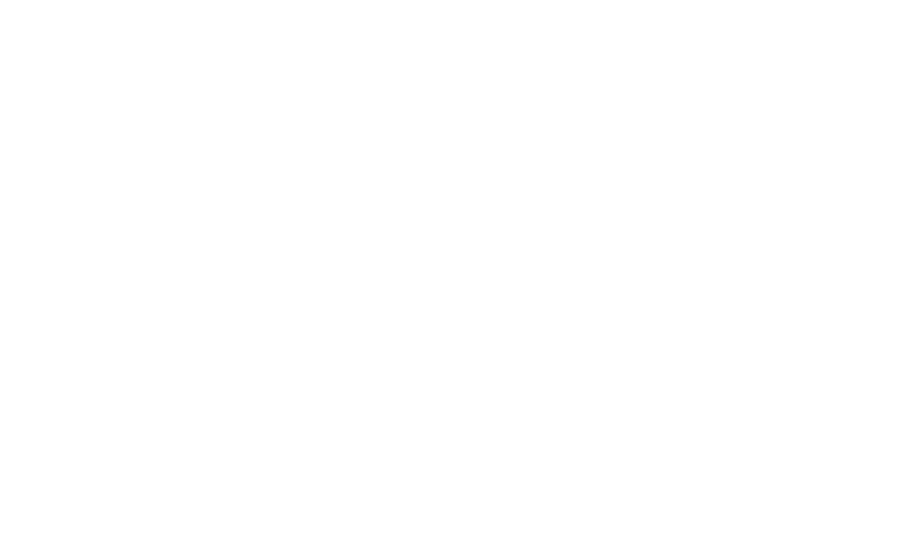

<IPython.core.display.Javascript object>


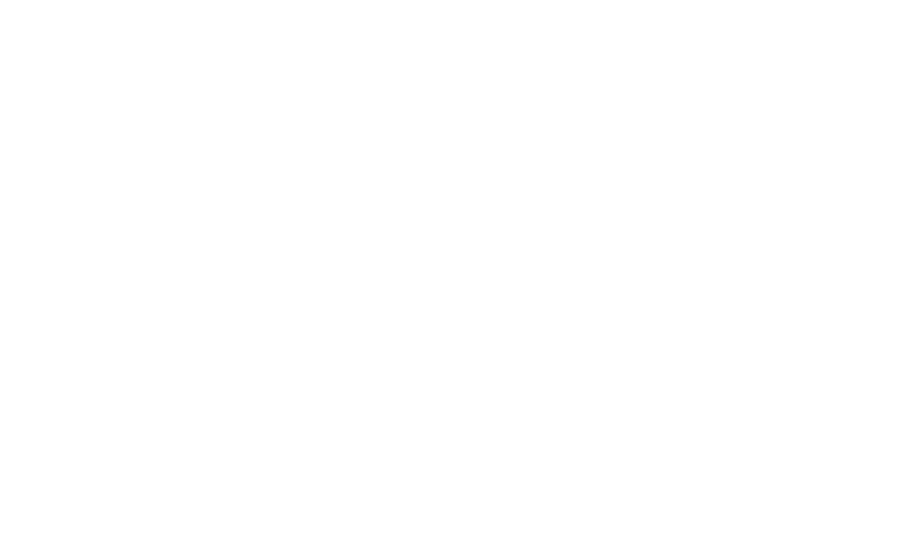

in
[ 0.00153814  0.00308683  0.00690083 -0.00261604 -0.54031041  0.03282001
  0.00643081  0.00300844  0.01077333 -0.07278968 -0.10865404  0.00595107
 -0.07243008  0.00484865  0.02904271 -0.03391313  0.00506791 -0.01625258
  0.00511732 -0.00106295 -0.0069046  -0.00372501 -0.00559276 -0.01092359]
i:00 mean:0.000238(0.024285) stdev:0.118970(0.017172) Nchanged:0 Nused:24 Nskipped:0
i:01 mean:-0.009577(0.006985) stdev:0.033498(0.004939) Nchanged:1 Nused:23 Nskipped:1
i:02 mean:-0.009577(0.006985) stdev:0.033498(0.004939) Nchanged:0 Nused:23 Nskipped:1


<IPython.core.display.Javascript object>


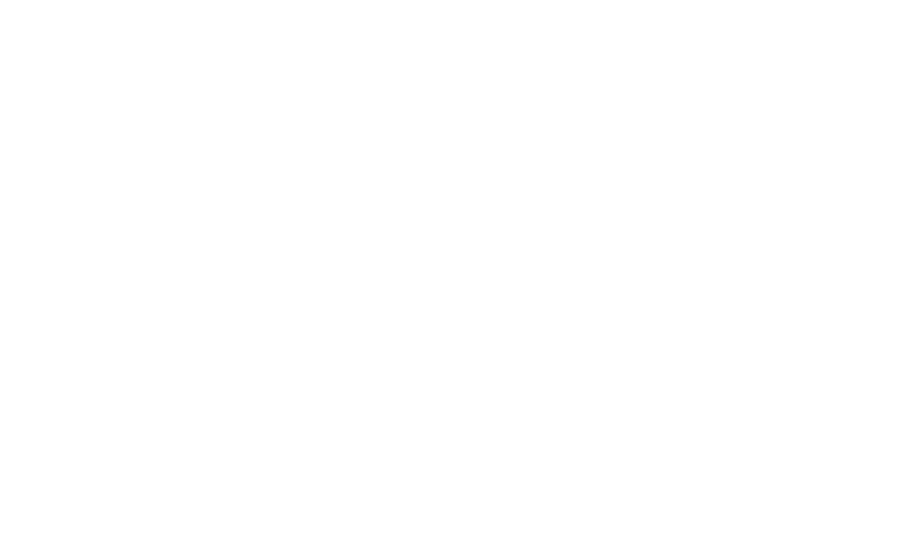

<IPython.core.display.Javascript object>


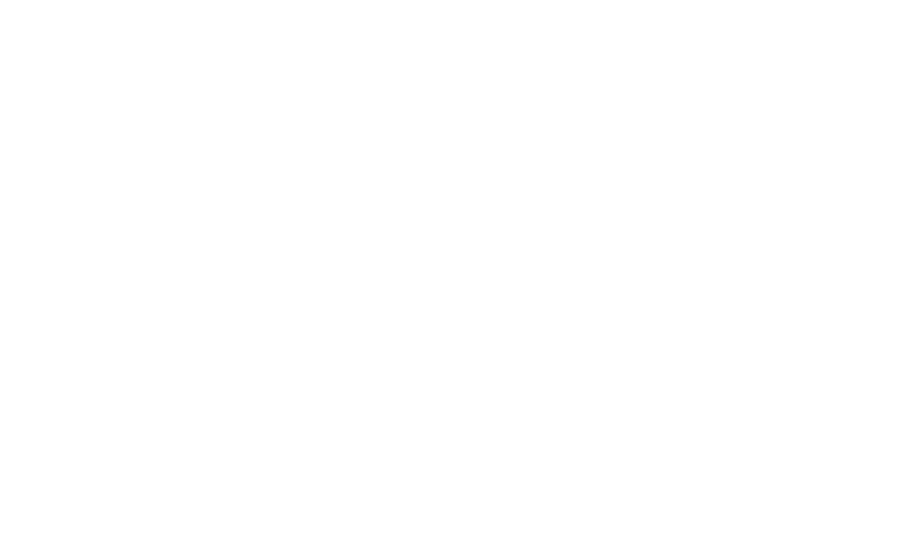

in
[-6.25966891e-02 -5.63344635e-02  2.34665237e-02 -3.84305988e-03
 -2.43885742e-03  5.81857399e-03 -2.54759635e+00  4.13627791e-02
 -2.62566835e-03  1.26594710e-02  4.28028409e-03 -9.35704799e-03
  6.87532531e-03 -1.33061389e-02  1.32675973e-02 -9.18146289e-02
 -7.89195816e-02  3.41536211e-02 -6.35924193e-03  1.17105885e-02
  1.72273416e-02  9.37782326e-03  2.80885260e-02  1.09950615e-02
  1.11507586e-02 -5.38402331e-03  1.84990718e-02  2.78188934e-04
  1.81645621e-02 -9.36354259e-03  2.72154260e-02 -5.66871551e-03
 -1.50932572e-02 -1.08396887e-02 -1.66675427e-02]
i:00 mean:0.000278(0.074574) stdev:0.441188(0.052732) Nchanged:0 Nused:35 Nskipped:0
i:01 mean:-0.002824(0.005159) stdev:0.030083(0.003648) Nchanged:1 Nused:34 Nskipped:1
i:02 mean:-0.002824(0.005159) stdev:0.030083(0.003648) Nchanged:0 Nused:34 Nskipped:1


<IPython.core.display.Javascript object>


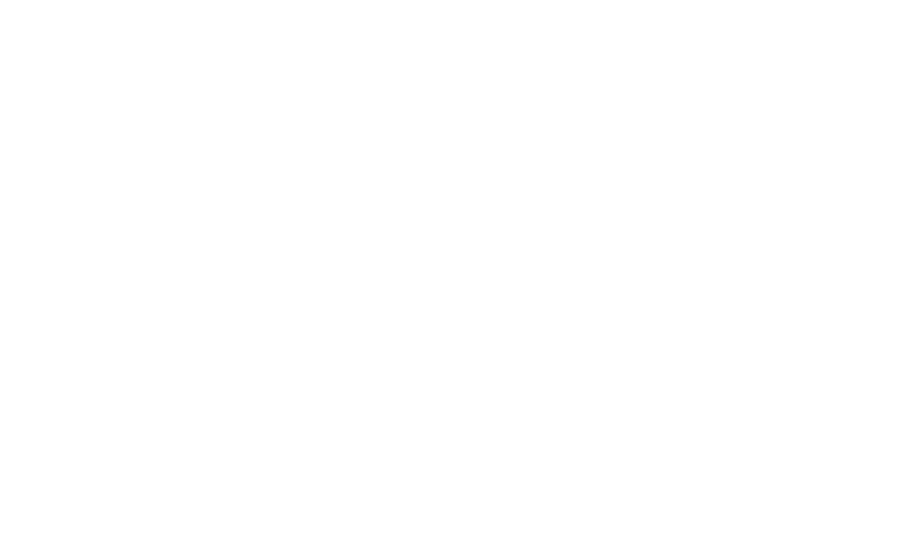

<IPython.core.display.Javascript object>


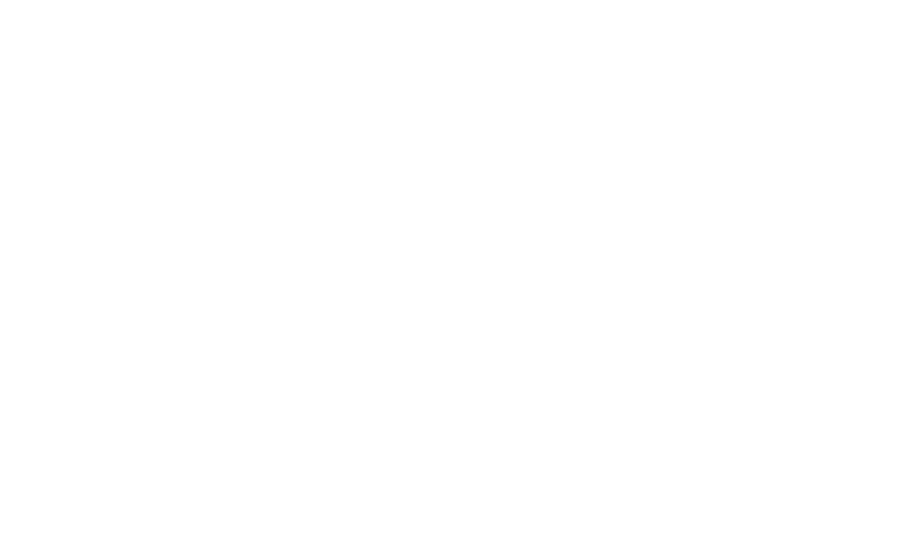

in
[-0.02655769  0.00647711  0.04537281  0.0147636   0.0138154   0.02562357
  0.03915002 -0.04777077 -0.01056197  0.01129751 -0.03406957  0.01756187
 -0.01381268 -0.01663733 -0.1207215   0.03727538  0.00304659  0.01105325
  0.00521449 -0.11183505  0.01344971  0.02260154  0.00576971 -0.00257712
 -0.1153487   0.00396428 -0.01523578 -0.03451848 -0.06578139  0.0012482
 -0.02144368 -0.31947577 -0.00236881  0.02394744  0.02661507 -0.0229382 ]
i:00 mean:0.002147(0.011547) stdev:0.069280(0.008165) Nchanged:0 Nused:36 Nskipped:0
i:01 mean:-0.009541(0.006995) stdev:0.041385(0.004946) Nchanged:1 Nused:35 Nskipped:1
i:02 mean:-0.009541(0.006995) stdev:0.041385(0.004946) Nchanged:0 Nused:35 Nskipped:1


<IPython.core.display.Javascript object>


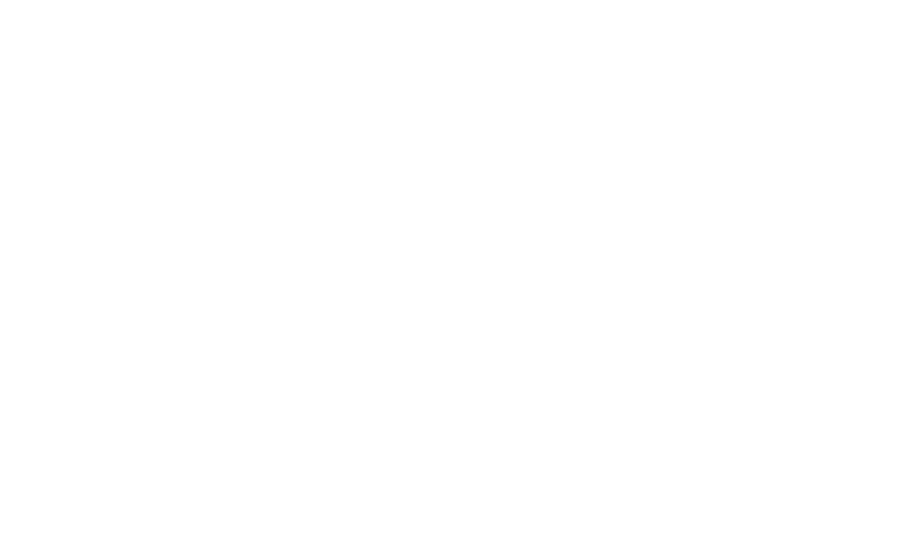

<IPython.core.display.Javascript object>


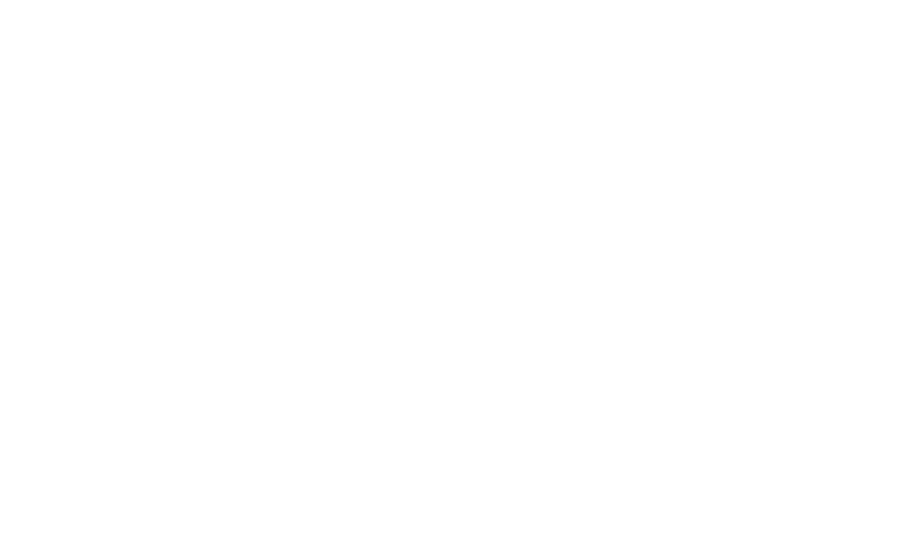

in


<IPython.core.display.Javascript object>


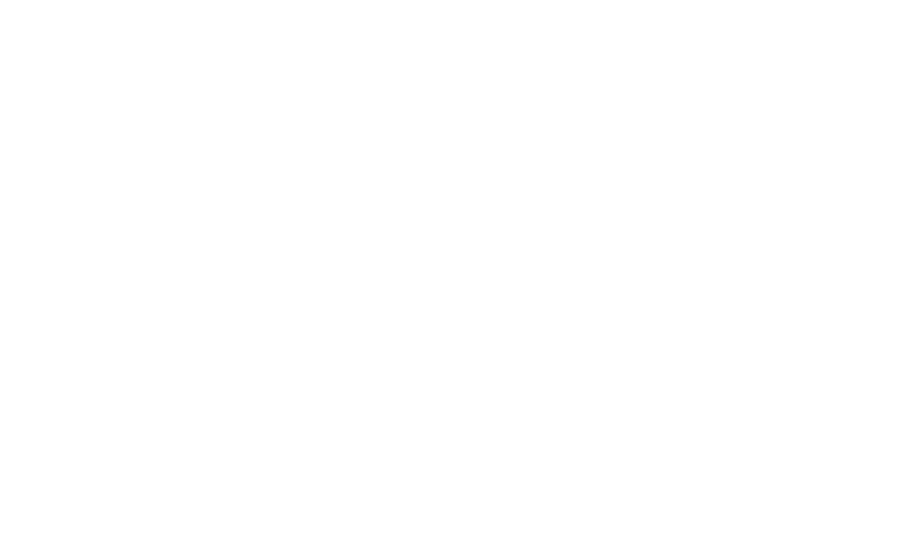

<IPython.core.display.Javascript object>


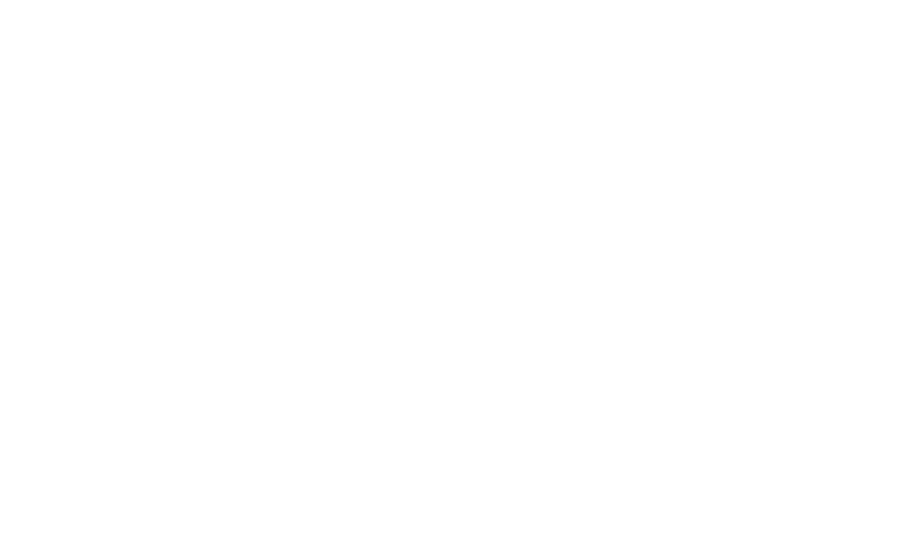

in


<IPython.core.display.Javascript object>


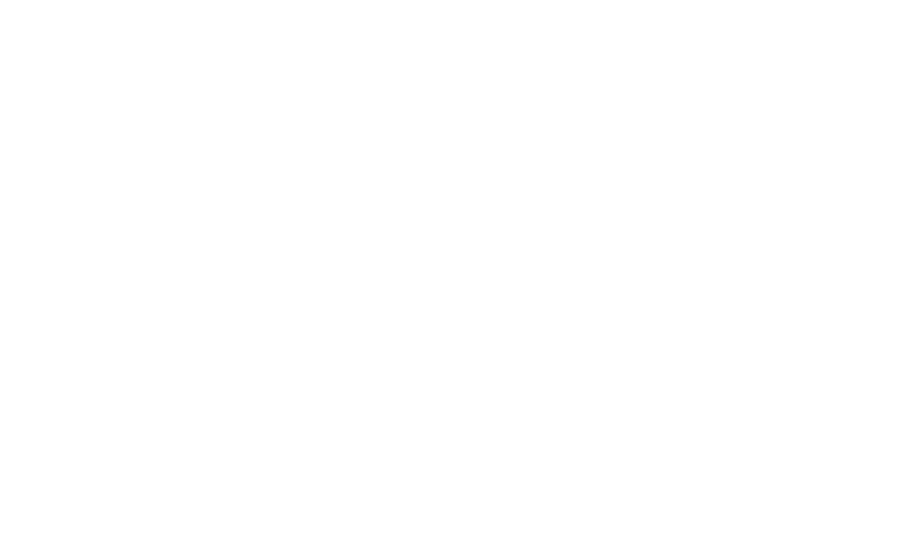

<IPython.core.display.Javascript object>


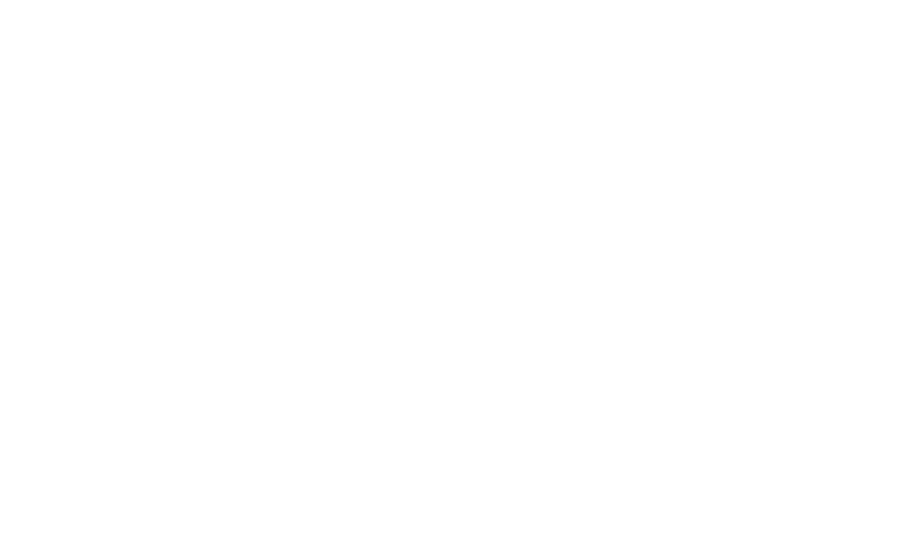

in


<IPython.core.display.Javascript object>


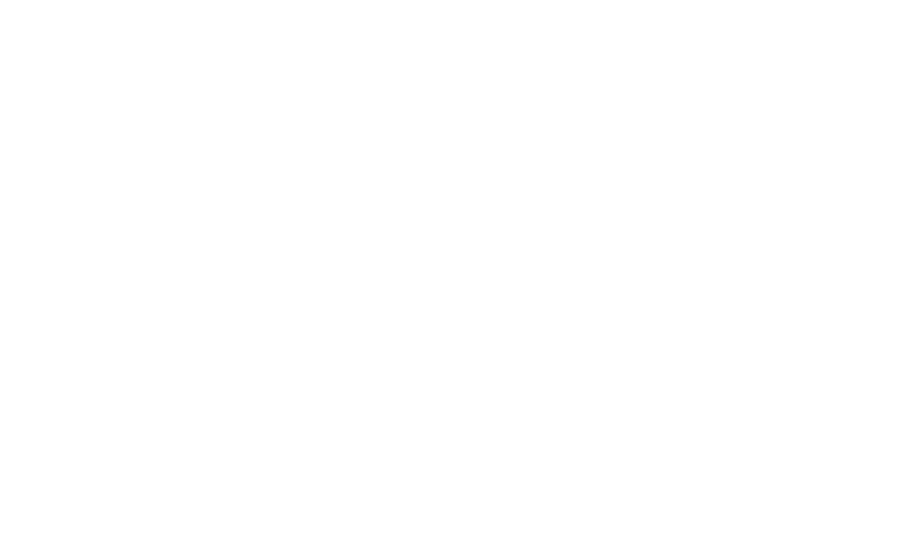

<IPython.core.display.Javascript object>


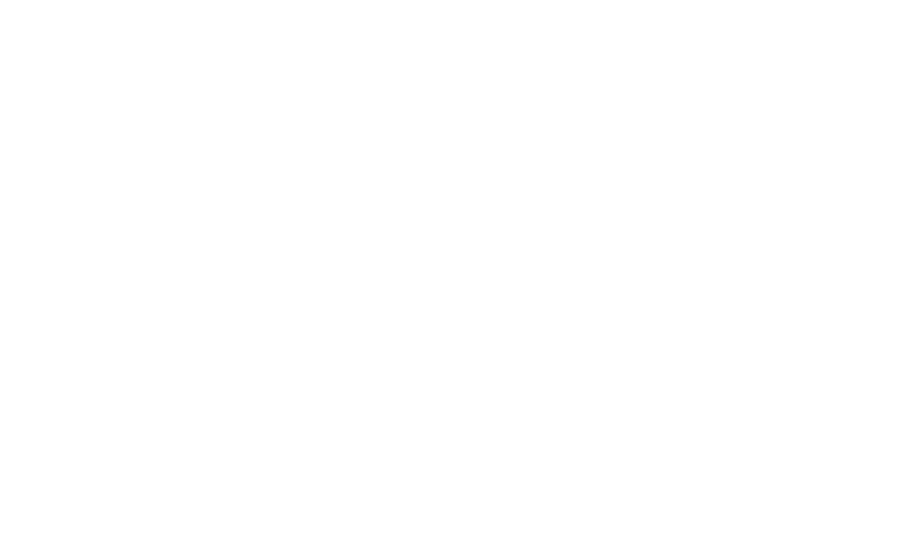

in


<IPython.core.display.Javascript object>


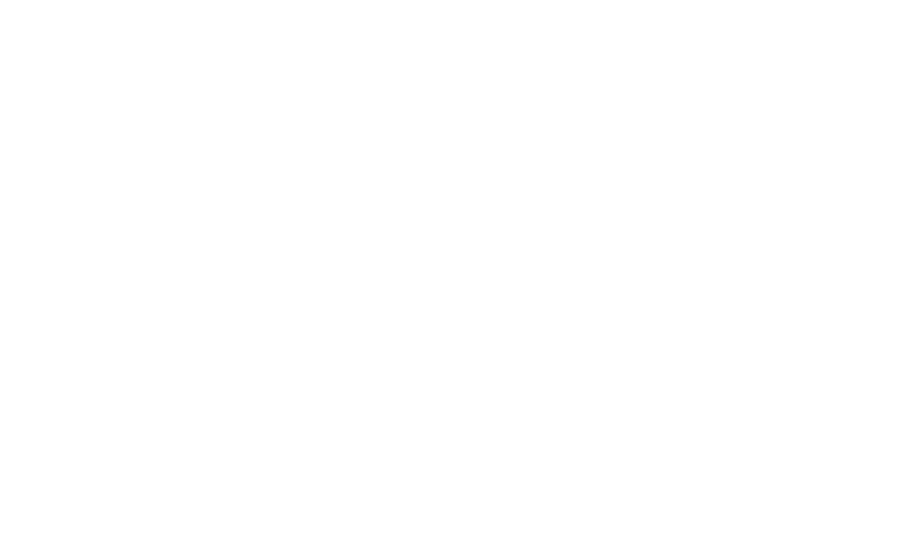

<IPython.core.display.Javascript object>


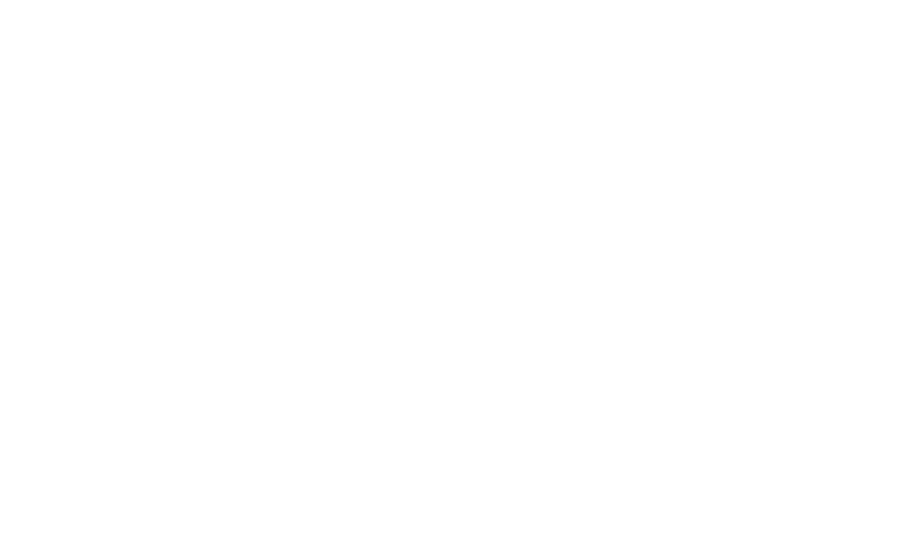

in
[-1.15586565e-02 -1.10853471e-02  1.03716002e-02  3.12299293e-02
  4.28830244e-03  5.52127344e-03  1.54141403e-02 -7.42424910e-03
 -9.75626512e-03  1.14735987e-04 -1.24955405e-02  2.00126856e-03
  2.64784388e-02  4.79387556e-03  8.79143215e-03  3.19928444e-02
 -7.05411158e-02 -5.35582169e-01  6.73970856e-03 -3.00398418e-03
  1.66169002e-02 -9.85671040e-03 -1.72547665e-02 -2.44780015e-02
  2.49101796e-02  7.77679705e-03 -2.34456765e+00 -4.13024811e-02]
i:00 mean:0.001058(0.088423) stdev:0.467891(0.062525) Nchanged:0 Nused:28 Nskipped:0
i:01 mean:-0.020641(0.020443) stdev:0.106226(0.014455) Nchanged:1 Nused:27 Nskipped:1
i:02 mean:-0.000835(0.004417) stdev:0.022523(0.003123) Nchanged:1 Nused:26 Nskipped:2
i:03 mean:0.001953(0.003543) stdev:0.017716(0.002505) Nchanged:1 Nused:25 Nskipped:3
i:04 mean:0.001953(0.003543) stdev:0.017716(0.002505) Nchanged:0 Nused:25 Nskipped:3


<IPython.core.display.Javascript object>


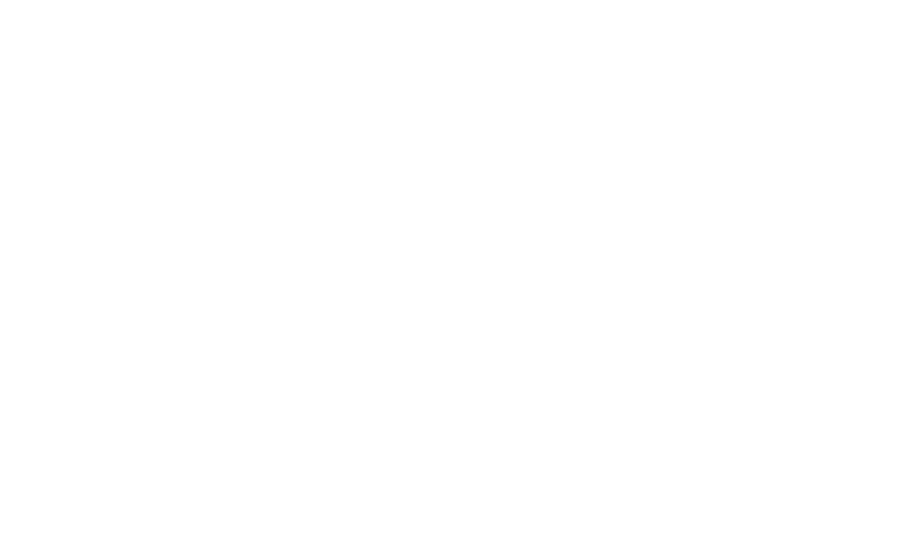

<IPython.core.display.Javascript object>


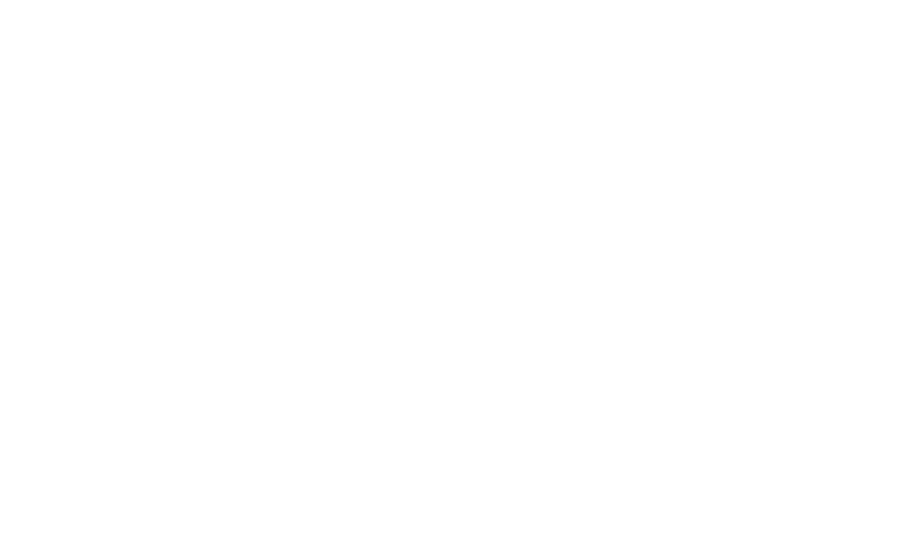

in
[ 0.00491526 -0.0031393   0.00453783  0.02918794 -0.04119099 -0.92470905
 -0.00147136 -0.05403691  0.00694369 -0.01826794 -0.00616016 -0.03791851
 -0.05721374 -0.01459848 -0.00314859  0.01244295  0.00233129  0.00860539
  0.00140584  0.00978603 -0.01695771  0.00407397  0.00707794  0.00194158
 -0.13931527  0.00847813 -0.0050091   0.00100953 -0.0161809  -0.00534258
 -0.0131928   0.00358399  0.01004534 -0.03283283]
i:00 mean:-0.002305(0.028253) stdev:0.164739(0.019978) Nchanged:0 Nused:34 Nskipped:0
i:01 mean:-0.010594(0.005284) stdev:0.030355(0.003736) Nchanged:1 Nused:33 Nskipped:1
i:02 mean:-0.006572(0.003498) stdev:0.019786(0.002473) Nchanged:1 Nused:32 Nskipped:2
i:03 mean:-0.006572(0.003498) stdev:0.019786(0.002473) Nchanged:0 Nused:32 Nskipped:2


<IPython.core.display.Javascript object>


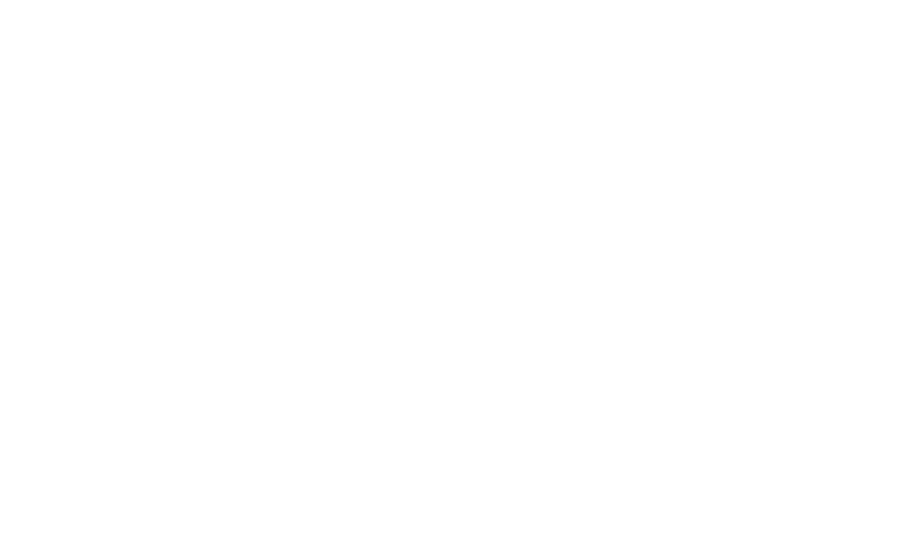

<IPython.core.display.Javascript object>


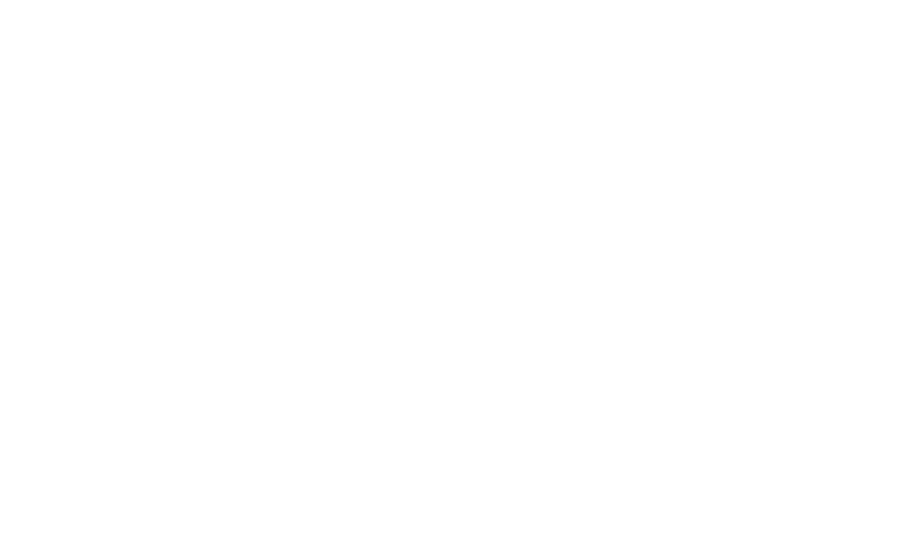

in
[ 1.06456530e-02 -2.27641278e-02  6.85583028e-03 -6.86033170e-02
  3.73191449e-02  9.78957226e-03 -1.11406779e-02  1.72475684e-02
 -5.30410341e-01 -2.94356662e-02  1.95895284e-02  2.44504263e-03
  1.75237686e-02  4.82500421e-04  2.34230107e-02  2.12872039e-02
  5.76509116e-02 -9.89261079e-03 -3.33617140e-03  9.92155119e-03
 -5.31424699e-03 -3.57865643e-02 -3.12796731e-03 -1.18211314e-03
 -6.92326514e-03 -3.53361779e-01 -5.94127153e-03 -8.93255808e-03
 -8.82946815e-02 -4.48148029e-01  4.45971475e-02  4.69663411e-03
  1.16021458e-02  8.80906635e-02 -1.14574481e-02 -2.28926256e-02
  4.96730253e-03]
i:00 mean:-0.001182(0.022026) stdev:0.133981(0.015575) Nchanged:0 Nused:37 Nskipped:0
i:01 mean:-0.008579(0.011517) stdev:0.068137(0.008144) Nchanged:2 Nused:35 Nskipped:2
i:02 mean:0.001562(0.005479) stdev:0.031947(0.003874) Nchanged:1 Nused:34 Nskipped:3
i:03 mean:0.001562(0.005479) stdev:0.031947(0.003874) Nchanged:0 Nused:34 Nskipped:3


<IPython.core.display.Javascript object>


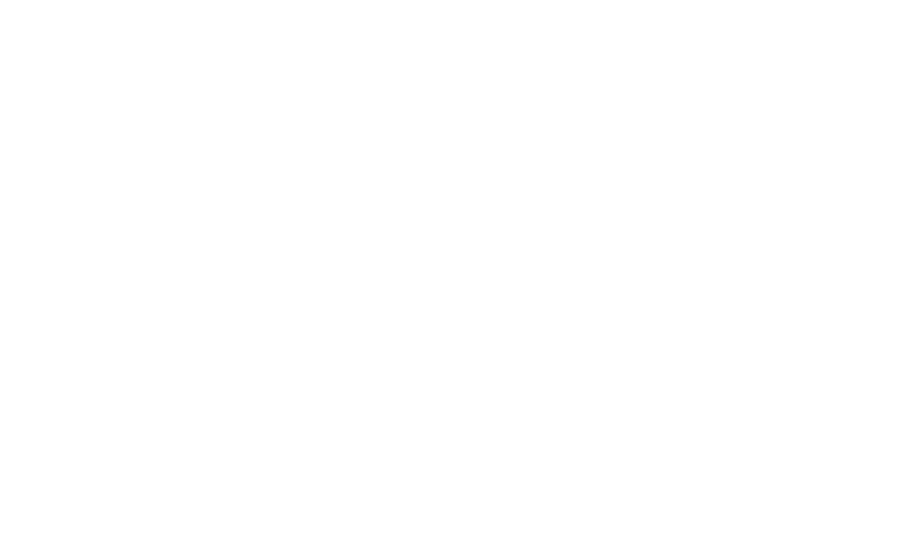

<IPython.core.display.Javascript object>


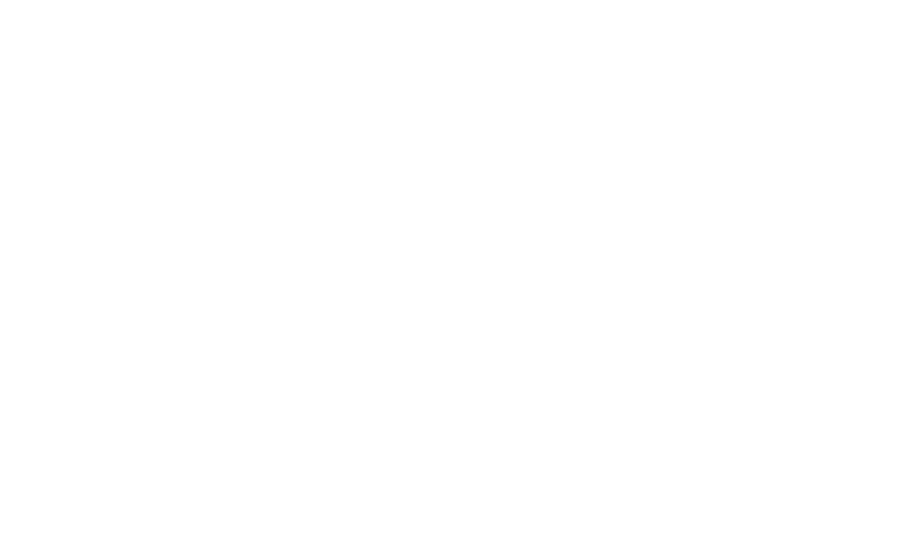

in
[-0.00355211 -0.00887807 -0.00349883  0.03676379  0.00625544 -0.008705
 -0.03110237 -0.16230163 -0.03079929 -0.02198024 -0.01844093  0.015658
  0.02819188 -0.00083329  0.00813194 -0.19677976  0.01939291  0.01019414
 -0.02931702  0.00553539 -0.00600577  0.0165179   0.00919859  0.01199409
 -0.02436692  0.00772876  0.0317917   0.01116562 -0.00588347  0.00085168
  0.04519841 -0.01018382 -0.01708282  0.01347228 -0.09545607]
i:00 mean:-0.000833(0.008529) stdev:0.050460(0.006031) Nchanged:0 Nused:35 Nskipped:0
i:01 mean:-0.001153(0.004477) stdev:0.025717(0.003166) Nchanged:2 Nused:33 Nskipped:2
i:02 mean:0.001794(0.003457) stdev:0.019555(0.002444) Nchanged:1 Nused:32 Nskipped:3
i:03 mean:0.001794(0.003457) stdev:0.019555(0.002444) Nchanged:0 Nused:32 Nskipped:3


<IPython.core.display.Javascript object>


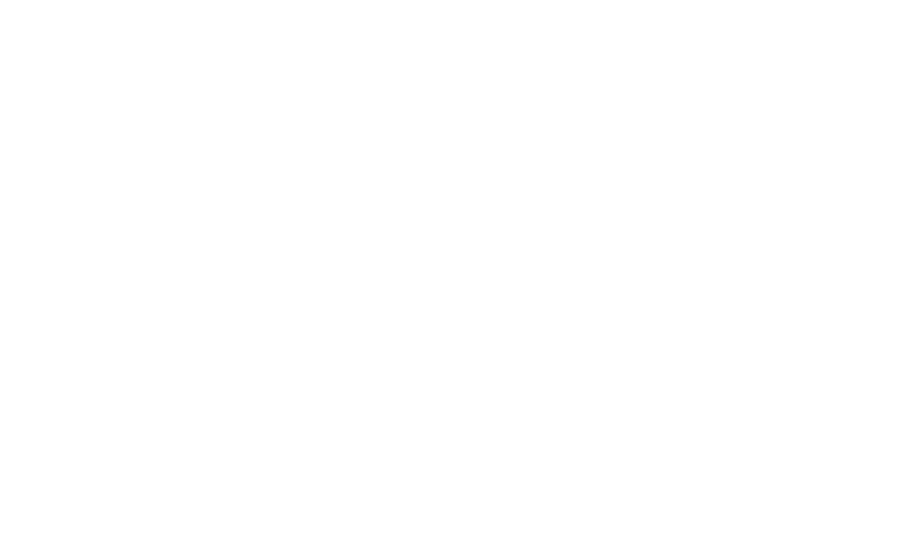

<IPython.core.display.Javascript object>


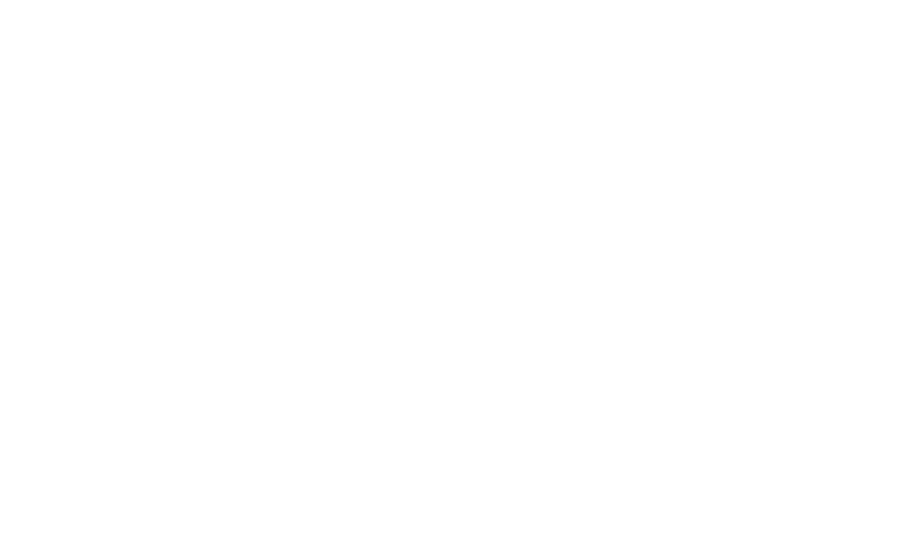

in
[ 0.03056752 -0.00543831 -0.01300916  0.04694932  0.01189016 -0.01551742
 -0.00226477  0.02310794  0.01083763 -0.00712543 -0.01144497 -0.02669054
  0.03081285  0.01803631 -0.00988953 -0.01055393  0.01051862 -0.03979221
  0.02860452  0.030056   -0.00826972  0.01630943  0.01526672  0.03523973
 -0.00403846  0.00464408 -0.01368084 -0.00584141  0.01629838  0.01504447
 -0.07406907 -0.0087322  -1.35171037  0.00557029 -0.00501275]
i:00 mean:-0.002265(0.039611) stdev:0.234344(0.028009) Nchanged:0 Nused:35 Nskipped:0
i:01 mean:0.002600(0.004049) stdev:0.023610(0.002863) Nchanged:1 Nused:34 Nskipped:1
i:02 mean:0.004923(0.003406) stdev:0.019568(0.002409) Nchanged:1 Nused:33 Nskipped:2
i:03 mean:0.004923(0.003406) stdev:0.019568(0.002409) Nchanged:0 Nused:33 Nskipped:2


<IPython.core.display.Javascript object>


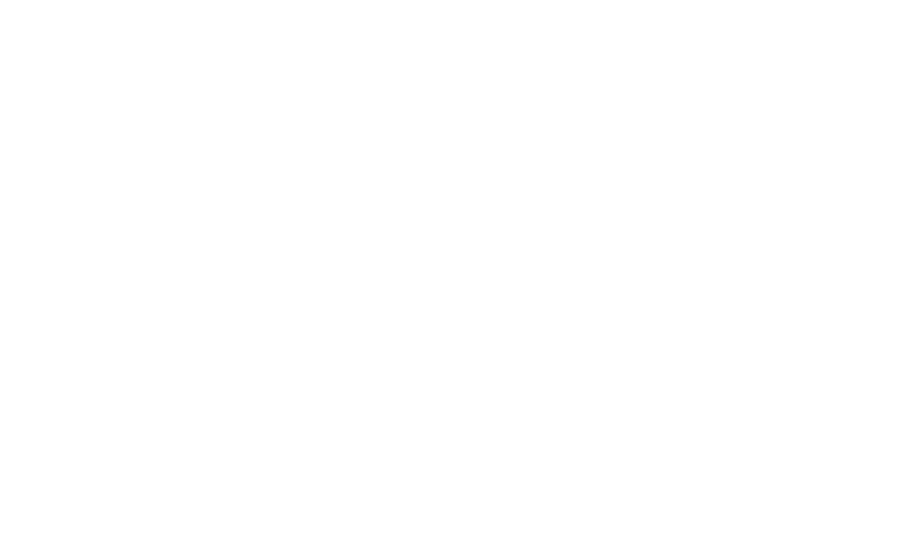

<IPython.core.display.Javascript object>


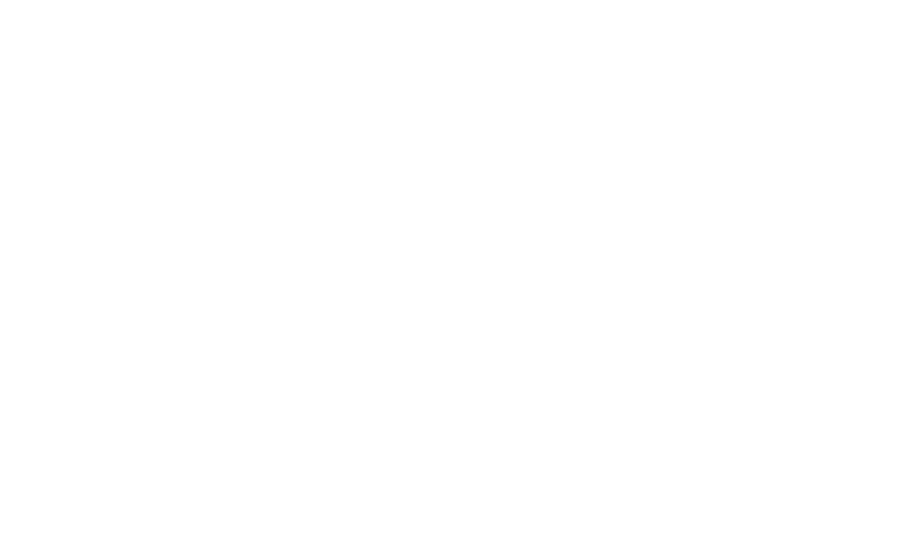

in
[ 9.98084171e-02  1.78007880e-02  2.14167389e-03 -4.81826051e-03
  2.77434350e-02  1.19591387e+00 -2.00650586e-03  2.93352253e-02
 -2.49289230e-02  4.09841716e-03 -1.22470093e-02 -9.32080076e-02
  3.10064532e-02  2.44683492e-03 -9.65380483e-03 -1.88821856e-01
  1.23577704e-03 -1.39517104e-04  7.15463712e-03 -7.68521201e-03
  1.48929473e-02  1.91429199e-02 -5.25566341e-02 -7.78662207e-02
 -7.59451270e-03  1.82732100e-02 -3.09417800e-03 -1.07126859e-02
 -9.38481441e-03 -7.54718236e-03 -7.83782620e-03 -6.63917418e-03]
i:00 mean:-0.002550(0.039248) stdev:0.222022(0.027753) Nchanged:0 Nused:32 Nskipped:0
i:01 mean:-0.008118(0.008519) stdev:0.047432(0.006024) Nchanged:1 Nused:31 Nskipped:1
i:02 mean:-0.002095(0.006178) stdev:0.033838(0.004368) Nchanged:1 Nused:30 Nskipped:2
i:03 mean:-0.005609(0.005239) stdev:0.028214(0.003705) Nchanged:1 Nused:29 Nskipped:3
i:04 mean:-0.002480(0.004335) stdev:0.022940(0.003065) Nchanged:1 Nused:28 Nskipped:4
i:05 mean:0.000312(0.003420) stdev:0.017770(0.

<IPython.core.display.Javascript object>


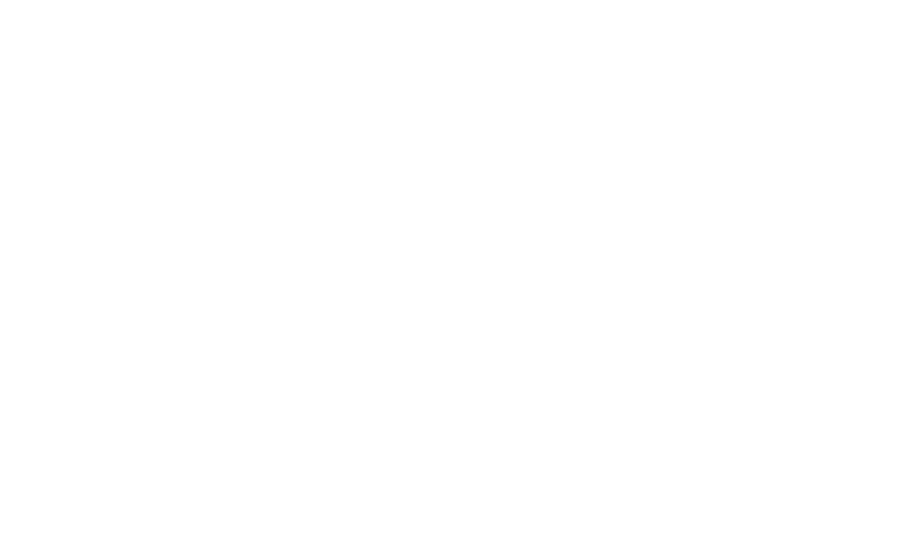

<IPython.core.display.Javascript object>


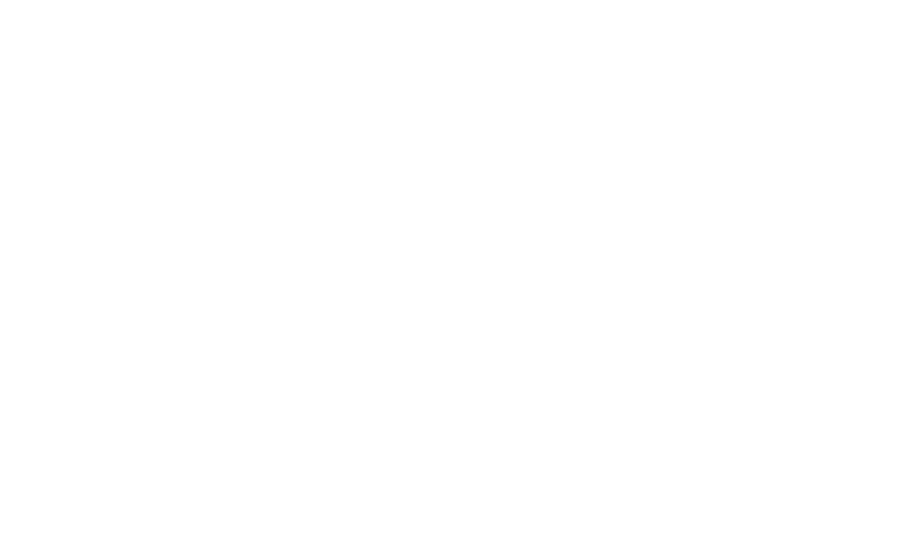

in
[-0.00493232  0.01235597  0.01902312  0.00070184  0.00810141 -0.00196087
 -0.00318699  0.00879985 -0.06970331 -0.00446205 -0.00612916  0.01166789
 -0.00425742 -0.00917644  0.03306601  0.01864548 -0.00247922  0.02049836
  0.02605539 -0.15668302 -0.03109754 -0.00990844  0.00660841 -0.17238287
 -0.01166395  0.02333049 -0.01384827  0.00236494 -0.05585779 -0.01000881
  0.01159546]
i:00 mean:-0.002479(0.008519) stdev:0.047434(0.006024) Nchanged:0 Nused:31 Nskipped:0
i:01 mean:-0.001236(0.004143) stdev:0.022313(0.002930) Nchanged:2 Nused:29 Nskipped:2
i:02 mean:0.001209(0.003451) stdev:0.018262(0.002440) Nchanged:1 Nused:28 Nskipped:3
i:03 mean:0.003322(0.002816) stdev:0.014634(0.001991) Nchanged:1 Nused:27 Nskipped:4
i:04 mean:0.003322(0.002816) stdev:0.014634(0.001991) Nchanged:0 Nused:27 Nskipped:4


<IPython.core.display.Javascript object>


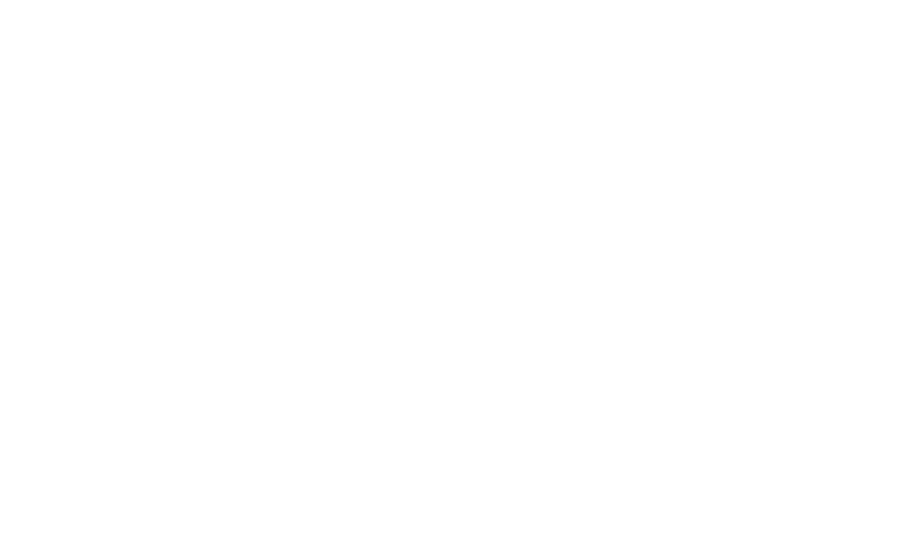

<IPython.core.display.Javascript object>


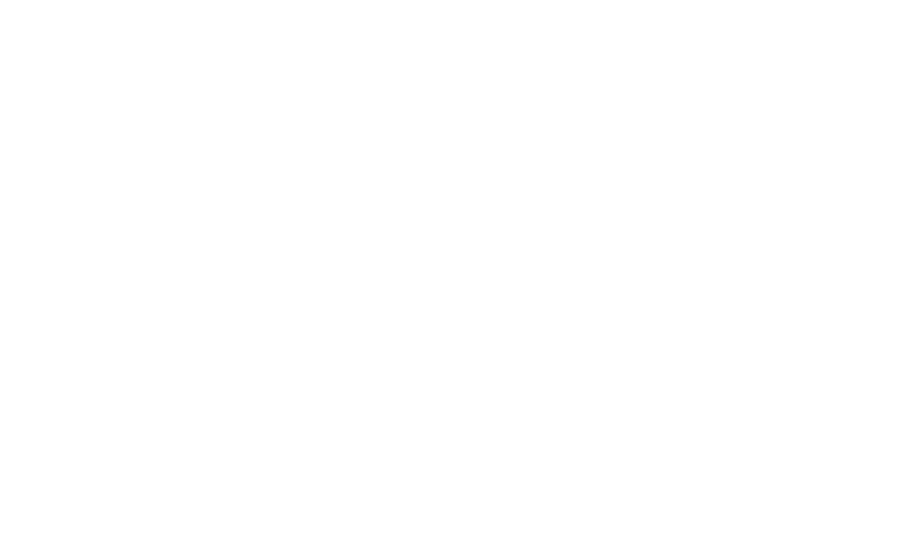

in
[-0.00126515  0.03842394  0.00492045 -0.00934822  0.00653024 -0.00927024
  0.0003148  -0.00237937  0.00561602 -0.01046171  0.01424306  0.01376139
 -0.00557708 -0.01562909  0.00833548  0.01384303  0.00399156  0.01974225
  0.00236533  0.02575598  0.00089525 -0.08176251 -0.01718195 -0.01412591
 -0.04346422 -0.01357382 -0.00347607]
i:00 mean:0.000315(0.004375) stdev:0.022733(0.003094) Nchanged:0 Nused:27 Nskipped:0
i:01 mean:0.000499(0.003180) stdev:0.016215(0.002249) Nchanged:1 Nused:26 Nskipped:1
i:02 mean:0.000499(0.003180) stdev:0.016215(0.002249) Nchanged:0 Nused:26 Nskipped:1


<IPython.core.display.Javascript object>


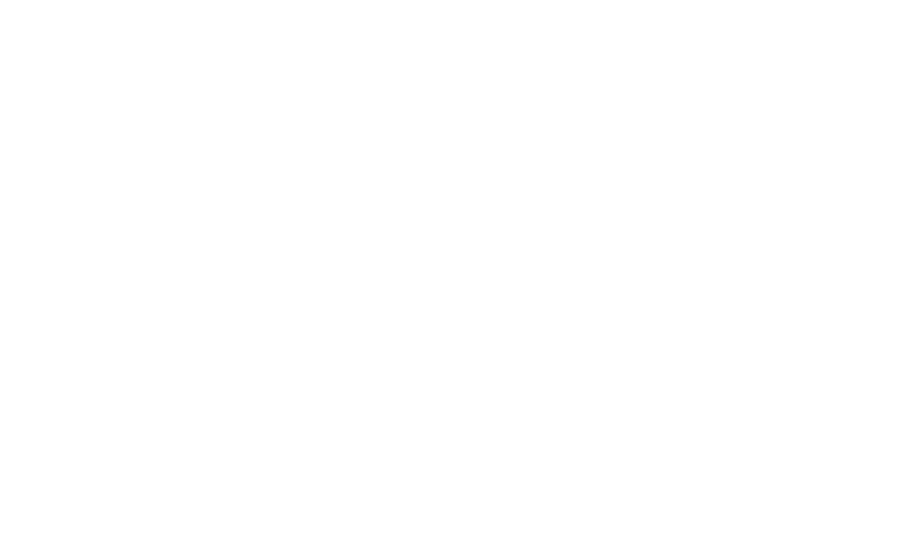

<IPython.core.display.Javascript object>


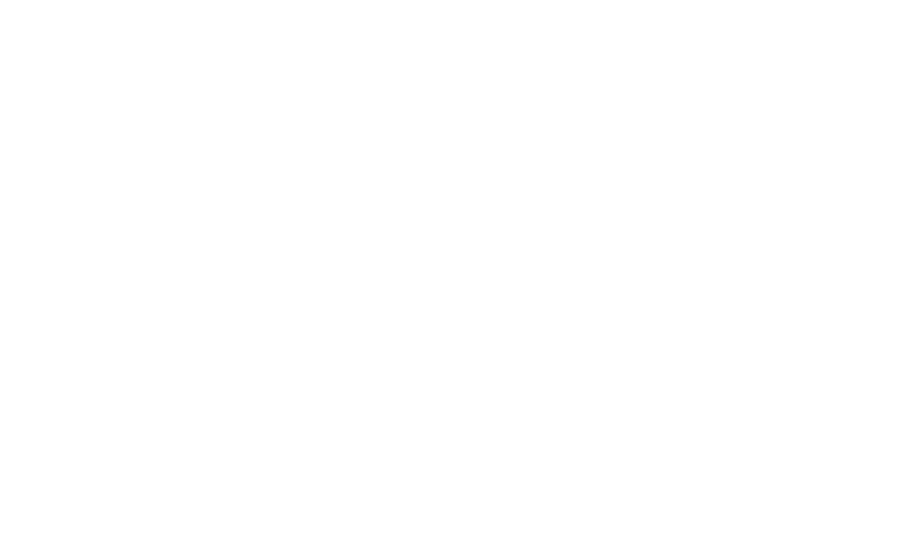

in


<IPython.core.display.Javascript object>


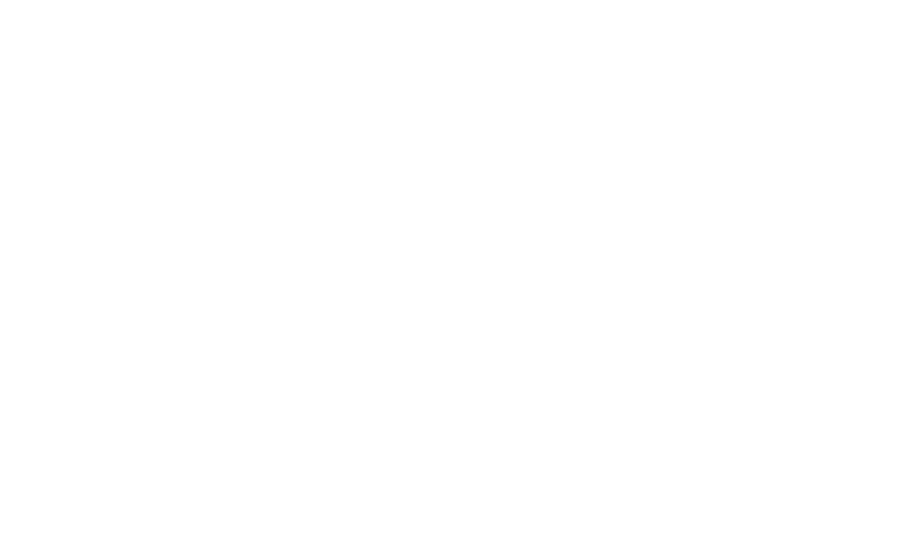

<IPython.core.display.Javascript object>


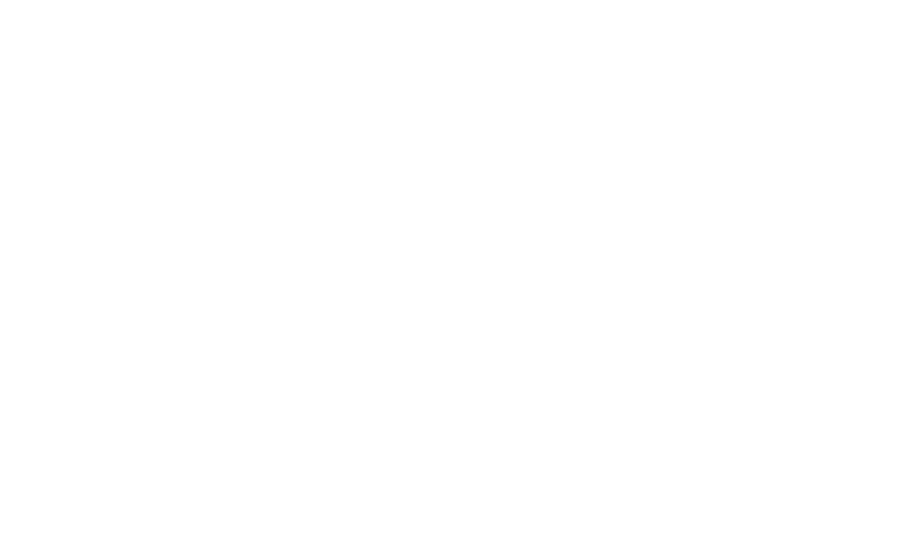

in


<IPython.core.display.Javascript object>


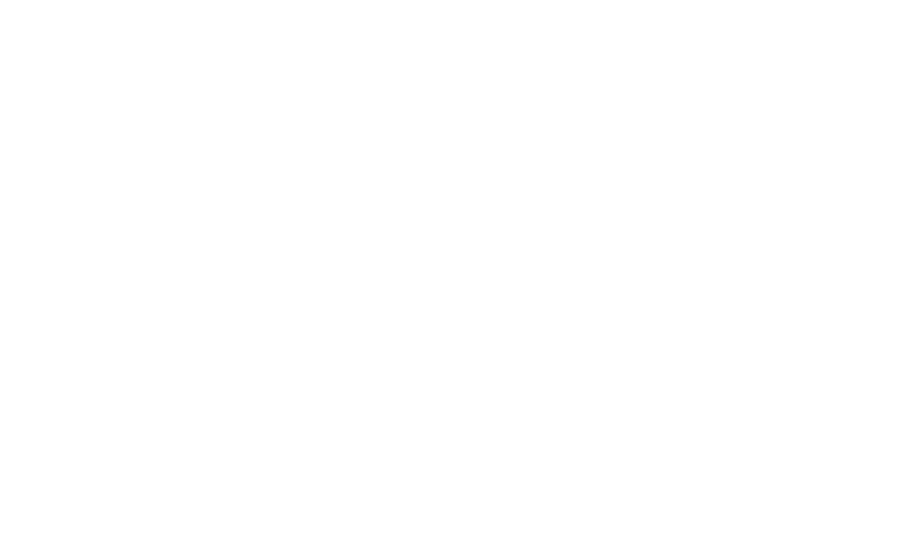

<IPython.core.display.Javascript object>


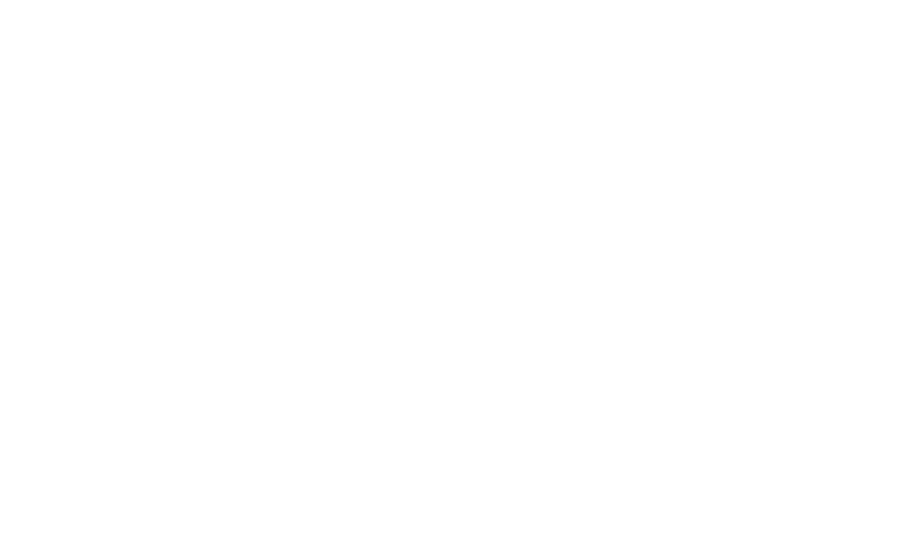

in


<IPython.core.display.Javascript object>


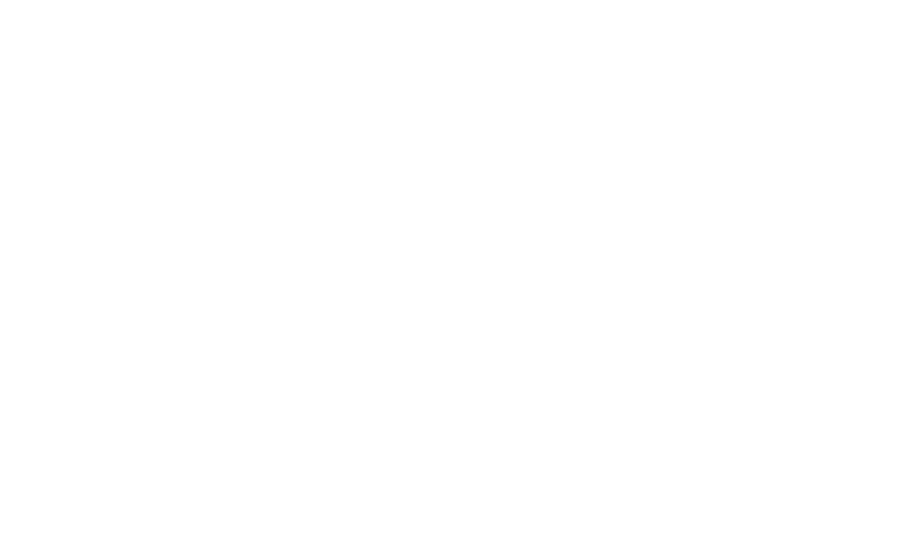

<IPython.core.display.Javascript object>


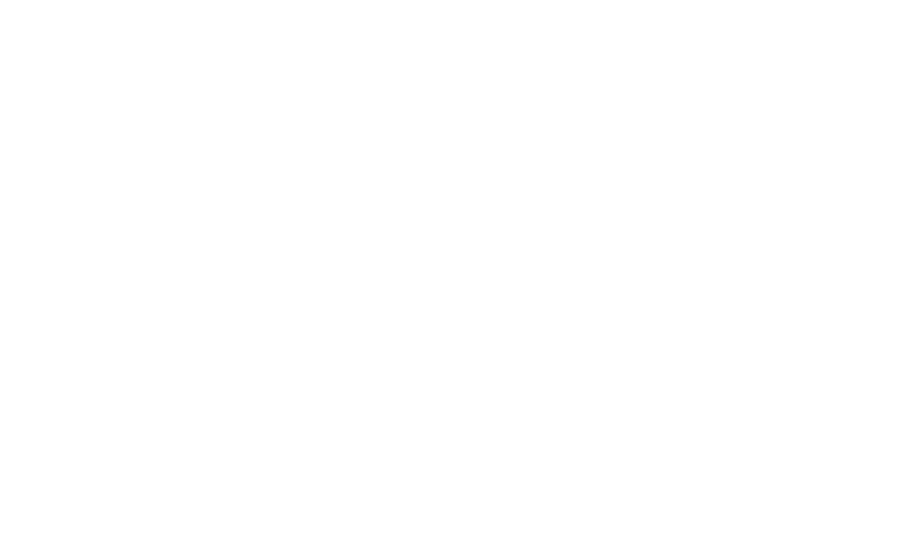

in


<IPython.core.display.Javascript object>


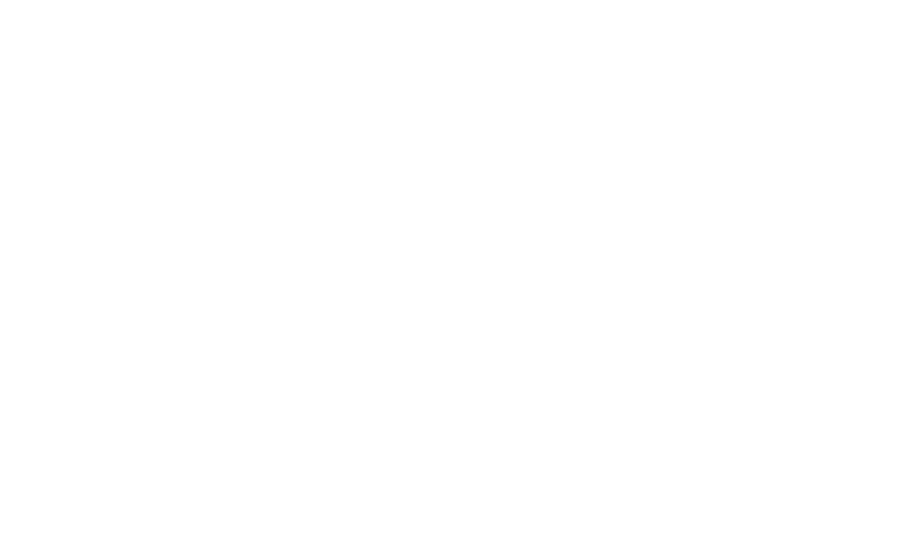

<IPython.core.display.Javascript object>


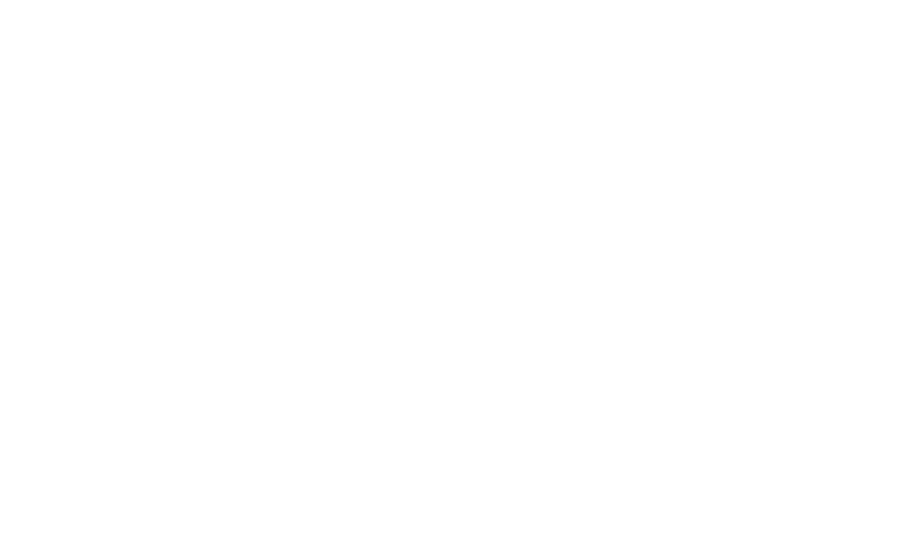

in
[-0.01443158 -0.00570871 -0.00818716 -0.00646179 -0.00878186  0.00810362
  0.01545372  0.01035832 -0.01831393 -0.10064113 -0.00883316  0.01483723
  0.00484174  0.00433428  0.00106039 -0.05049434  0.02788254  0.01431288
  0.00267617 -0.00555713  0.00347457 -0.01001071  0.01326119 -0.10021837
  0.02280818  0.0015022   0.02731038  0.00644297 -0.01305935 -0.01688904
  0.00336529 -0.47091018  0.00233924  0.003956   -0.00611403  0.00203513]
i:00 mean:0.001769(0.014231) stdev:0.085388(0.010063) Nchanged:0 Nused:36 Nskipped:0
i:01 mean:-0.005238(0.004747) stdev:0.028084(0.003357) Nchanged:1 Nused:35 Nskipped:1
i:02 mean:0.000531(0.002632) stdev:0.015122(0.001861) Nchanged:2 Nused:33 Nskipped:3
i:03 mean:0.002125(0.002152) stdev:0.012171(0.001521) Nchanged:1 Nused:32 Nskipped:4
i:04 mean:0.002125(0.002152) stdev:0.012171(0.001521) Nchanged:0 Nused:32 Nskipped:4


<IPython.core.display.Javascript object>


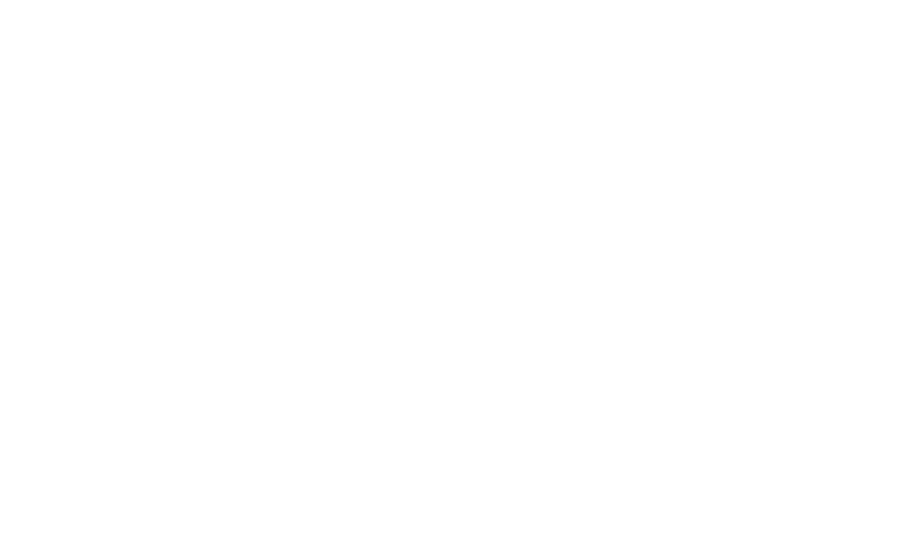

<IPython.core.display.Javascript object>


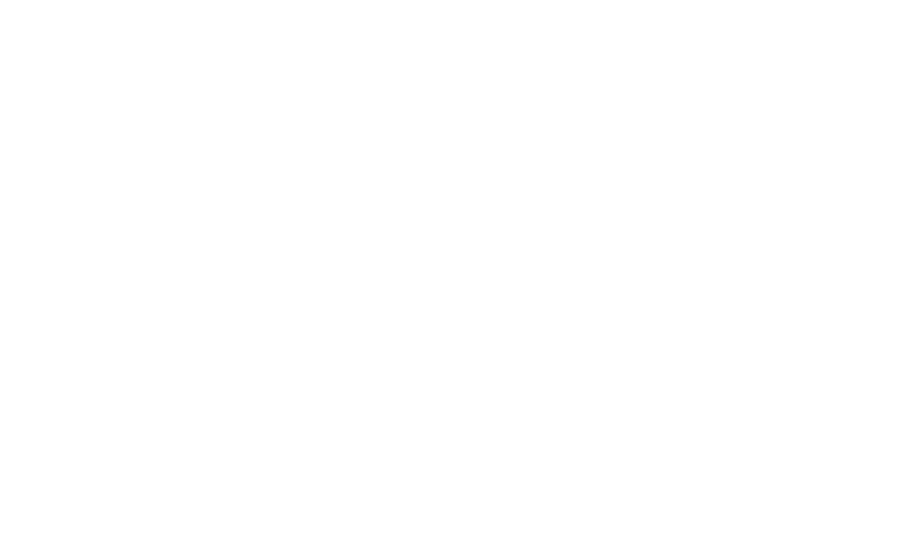

in
[-4.12325759e-02 -2.88410051e-02 -3.00636490e-02 -5.48681026e-02
 -3.73517390e-02 -6.28267145e-02  5.23625356e-03  1.80650158e-03
  4.15062842e-03  1.08218964e-02 -7.75279915e-03  2.47127752e-02
 -4.03062289e-02  5.26895020e-02  7.91125747e-03  8.76463075e-03
 -2.71971370e-02 -7.66173674e-02 -2.10014742e-02  1.97997963e-02
 -4.18937226e-03  2.49713477e-02  2.41888337e-03  2.96281826e-03
 -5.55641175e-03 -2.55609937e-03 -1.19236001e-02 -2.93233761e-03
 -2.84202843e-02  3.46757708e-02 -3.67576849e+00  3.61587839e-02
  1.90225363e-03  2.15281246e-02  3.03575090e-03  3.01967372e-02
  1.13500406e-02 -7.76407984e-02  9.87380297e-03  1.03169128e-02
 -5.95988384e-03 -1.58286258e-02 -3.78004501e-03  1.49047577e-02
  9.29039388e-03  1.00130178e-02 -3.97505590e-03 -5.31059851e-01
  1.47780213e-02  7.61010187e-03  7.27184443e-03  7.35166605e-03
 -8.37999715e-03  1.40307085e-02 -9.28089636e-03 -1.12196722e-02
  7.49326568e-03  7.88342579e-03  2.08011713e-02 -1.17077613e-03
  2.61562087e-02  1.10

<IPython.core.display.Javascript object>


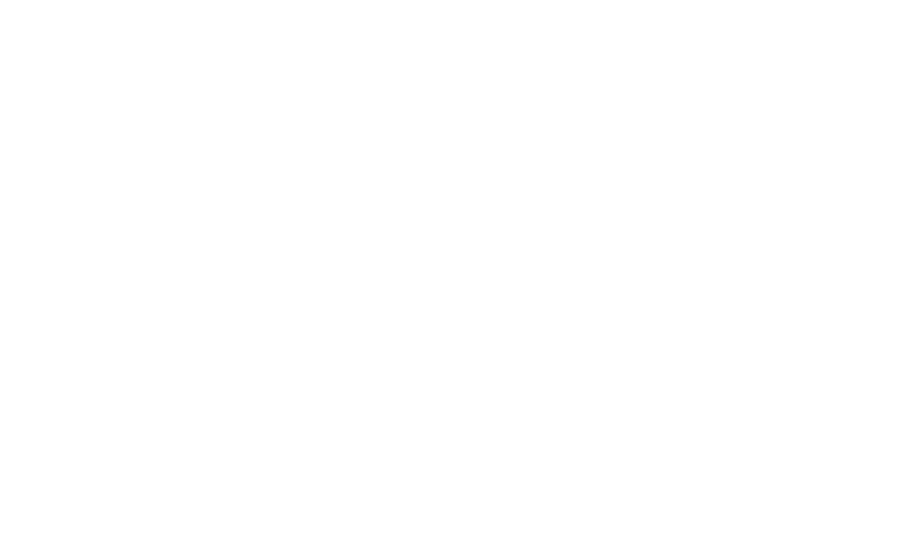

<IPython.core.display.Javascript object>


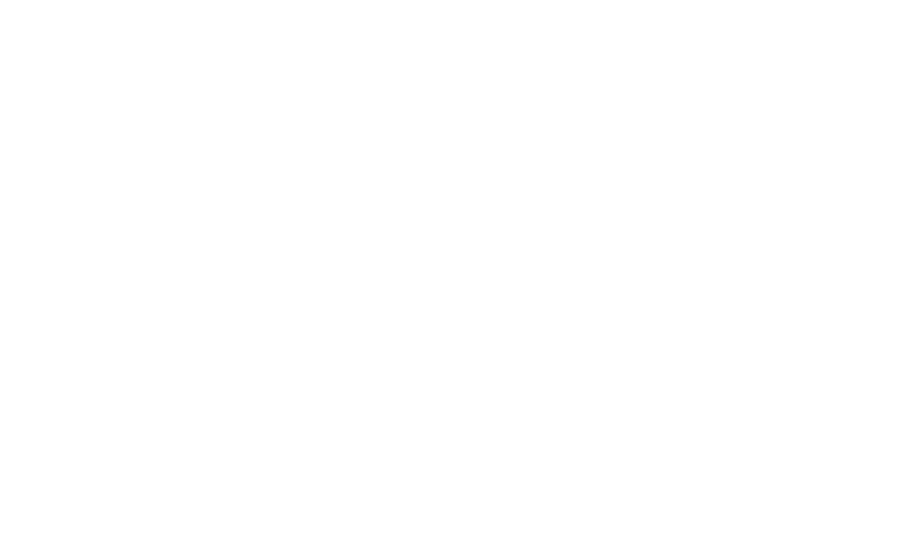

in
[-0.02111373 -0.0048482  -0.00439904 -0.06877914  0.00897646  0.0089358
  0.01032904 -0.00591674  0.02080174 -0.02109071  0.00744675  0.0069597
 -0.00888233  0.01394239 -0.10470264 -0.01212597  0.0034274  -0.0059936
 -0.00684015 -0.02138872  0.00761115 -0.20182835 -0.00186626 -0.00673266
  0.01791331 -0.00445063 -0.00438111 -0.08455061  0.00312938 -0.00463048
 -0.12352755 -0.00790331  0.00478238 -0.0140928   0.02078798  0.02738965
  0.01790885 -0.04571867  0.01476066  0.01248571  0.03386054  0.00350759
  0.00398376  0.00953181  0.0252716  -0.00980771  0.00220205 -0.02500038
  0.01770538  0.01009047  0.0117173   0.01003626  0.00473381 -0.01730564
 -0.0167444   0.01647976 -0.00782573 -0.02370192 -0.1255695  -0.02431523
 -0.0051039  -0.0043881   0.00345936 -0.03046365 -0.01828767  0.02509698
  0.03284743  0.02625443  0.04125553]
i:00 mean:-0.001866(0.004879) stdev:0.040525(0.003450) Nchanged:0 Nused:69 Nskipped:0
i:01 mean:-0.002390(0.003094) stdev:0.025135(0.002188) Nchanged:3 Nused:6

<IPython.core.display.Javascript object>


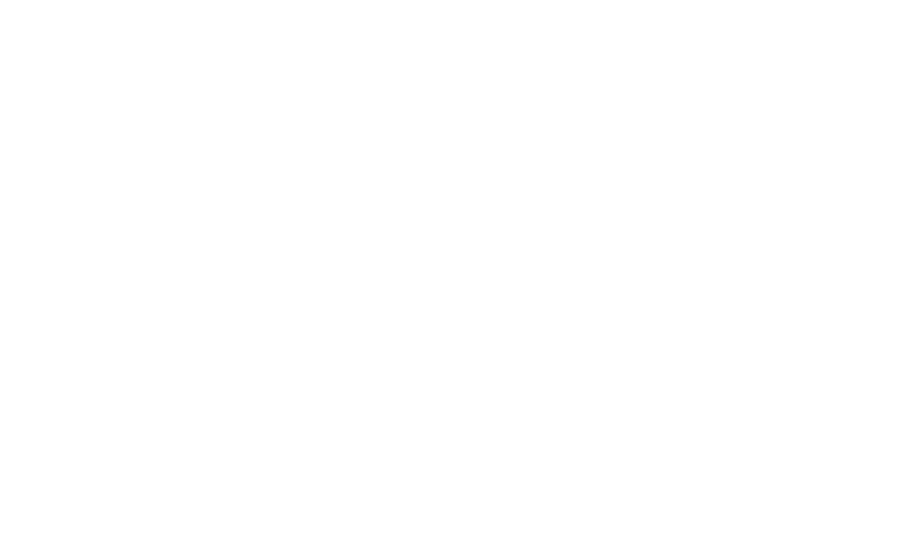

<IPython.core.display.Javascript object>


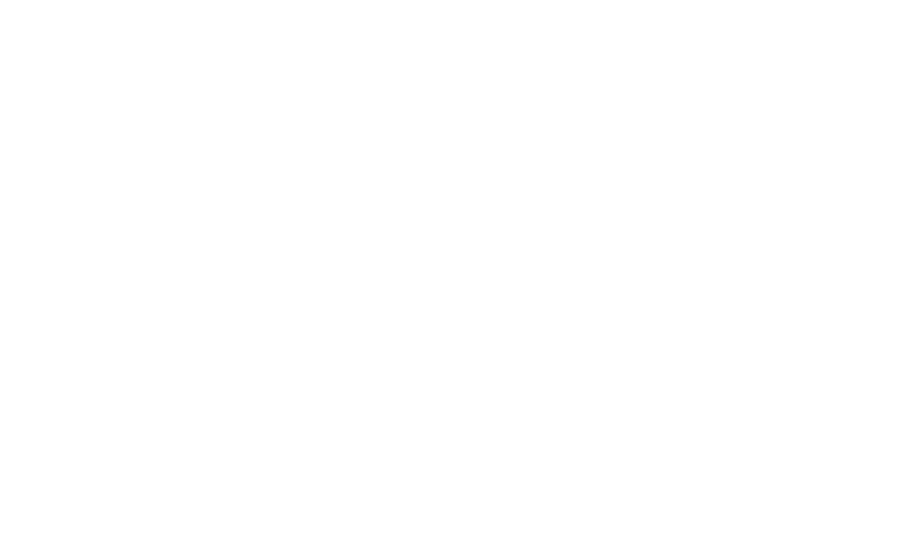

in
[-1.48046973e-02 -2.34753088e-02 -2.12696753e-02 -2.74316183e-02
  2.92746453e-02 -6.00293478e-05 -8.07766328e-03  1.15449738e-02
 -3.04435743e-02 -9.46894765e-02  5.48960287e-03 -1.57086233e-02
 -7.28479926e-03  1.19251369e-02  3.07948740e-02 -2.48537697e-03
  1.82366467e-02  5.69336778e-03  3.68815129e-03 -5.72387974e-03
 -1.96884691e-02  4.22971612e-02  1.27689325e-02 -1.79538309e-02
 -1.81329973e-02  1.19491297e-02 -9.88027577e-03 -4.52980194e-02
  1.23900660e-02 -1.43860206e-02  1.13718087e-02 -8.66467331e-03
  1.72182181e-02  7.90460355e-03  4.11037915e-02  4.89249489e-03]
i:00 mean:-0.001273(0.004253) stdev:0.025518(0.003007) Nchanged:0 Nused:36 Nskipped:0
i:01 mean:-0.000349(0.003420) stdev:0.020230(0.002418) Nchanged:1 Nused:35 Nskipped:1
i:02 mean:-0.000349(0.003420) stdev:0.020230(0.002418) Nchanged:0 Nused:35 Nskipped:1


<IPython.core.display.Javascript object>


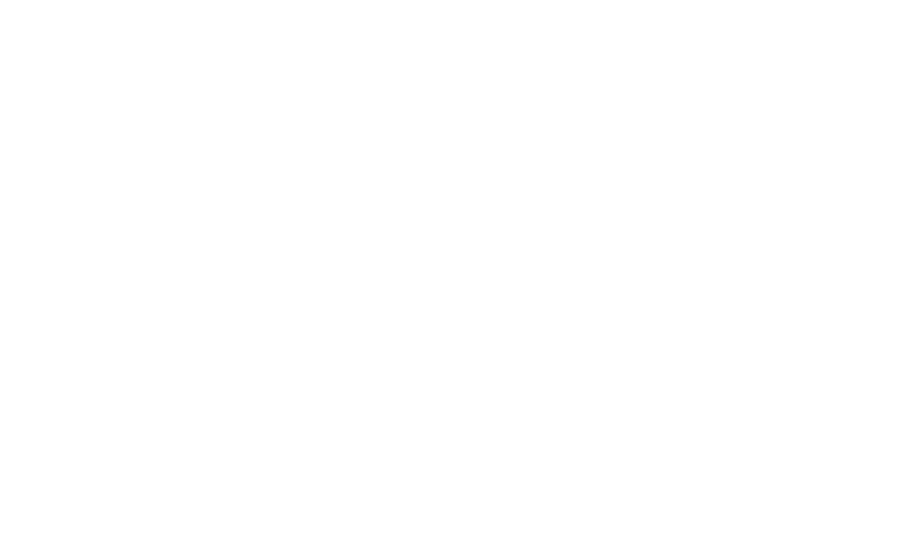

<IPython.core.display.Javascript object>


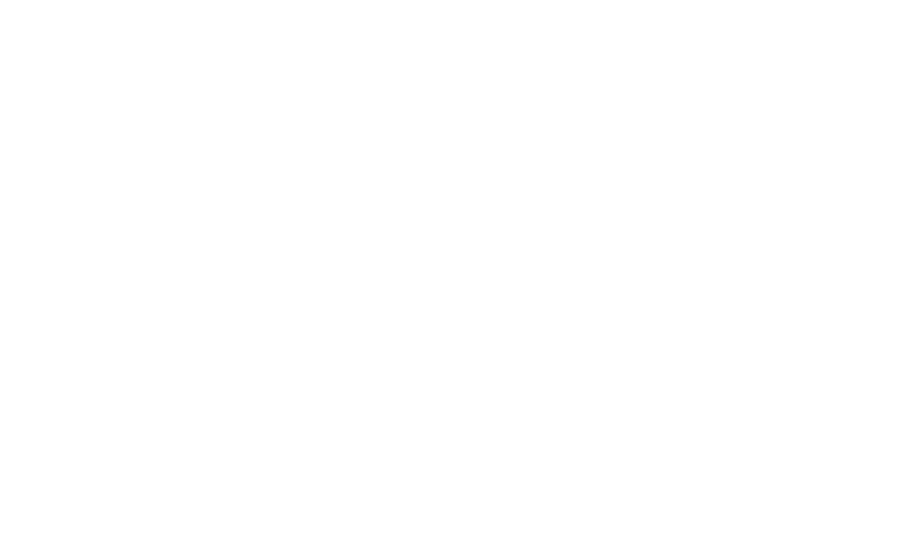

in
[-0.00279846  0.01996576 -0.01874143  0.02676518  0.0219894   0.0050964
  0.0088531  -0.01810802  0.01268214 -0.01402836  0.00231758  0.02440692
 -0.01467826 -0.00458847 -0.09043134  0.00548361 -0.01404902 -0.02459282
 -0.80764954  0.06675028  0.02644375  0.0296932   0.00843878 -0.00461825
 -0.01114431 -0.01015886  0.00734987 -0.18795486 -0.00705608 -0.03443268
  0.00235612  0.01908357  0.01255227 -0.01631386  0.27194396  0.01547043
 -0.00225067 -0.11225385  0.0077616  -0.0226944 ]
i:00 mean:0.000033(0.022735) stdev:0.143791(0.016076) Nchanged:0 Nused:40 Nskipped:0
i:01 mean:-0.000397(0.009913) stdev:0.061907(0.007010) Nchanged:1 Nused:39 Nskipped:1
i:02 mean:-0.002689(0.005102) stdev:0.031031(0.003607) Nchanged:2 Nused:37 Nskipped:3
i:03 mean:0.000355(0.004194) stdev:0.025165(0.002966) Nchanged:1 Nused:36 Nskipped:4
i:04 mean:0.002949(0.003377) stdev:0.019978(0.002388) Nchanged:1 Nused:35 Nskipped:5
i:05 mean:0.001072(0.002882) stdev:0.016807(0.002038) Nchanged:1 Nused:34 Nskipped:

<IPython.core.display.Javascript object>


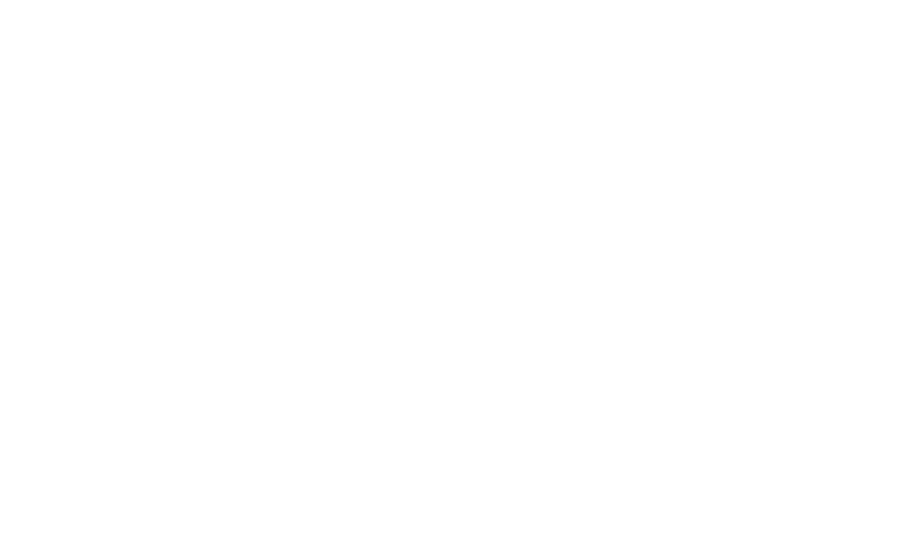

<IPython.core.display.Javascript object>


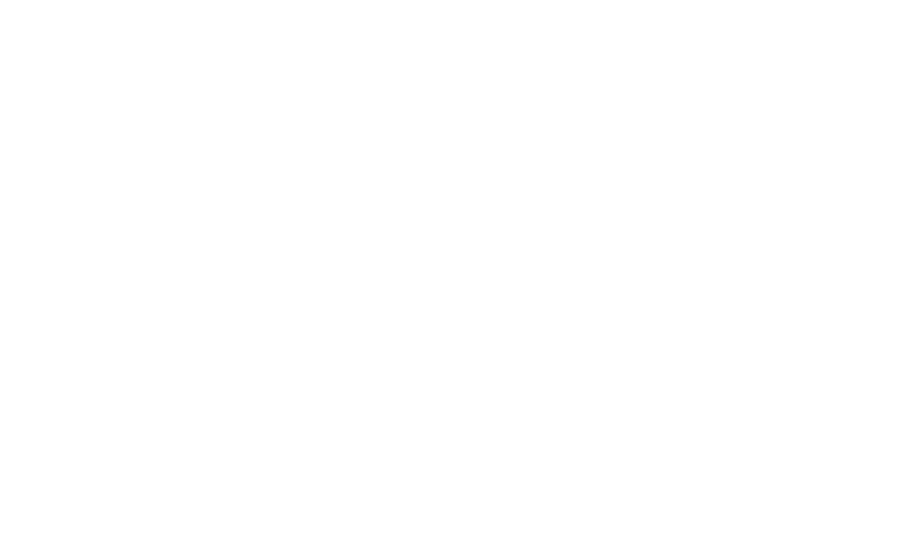

in
[ 0.00366916  0.00349485  0.02057567 -0.03202431 -0.00163839  0.00565352
  0.00638565 -0.00100599 -0.01476056  0.00529011 -0.00854369  0.01842468
 -0.11783989  0.03599631  0.03107573 -0.05724055 -0.01369819  0.01030491
  0.02120481  0.0400001   0.02037733 -0.00169153  0.04378353  0.02895023
  0.01676723  0.03412841 -0.02865453 -0.01070853  0.028719   -0.00619486
 -0.00915875 -0.00690881 -0.02839762 -0.01398199  0.00899738 -0.0100059
  0.0099271  -0.11399687]
i:00 mean:0.003582(0.005751) stdev:0.035454(0.004067) Nchanged:0 Nused:38 Nskipped:0
i:01 mean:0.004142(0.003732) stdev:0.022395(0.002639) Nchanged:2 Nused:36 Nskipped:2
i:02 mean:0.004142(0.003732) stdev:0.022395(0.002639) Nchanged:0 Nused:36 Nskipped:2


<IPython.core.display.Javascript object>


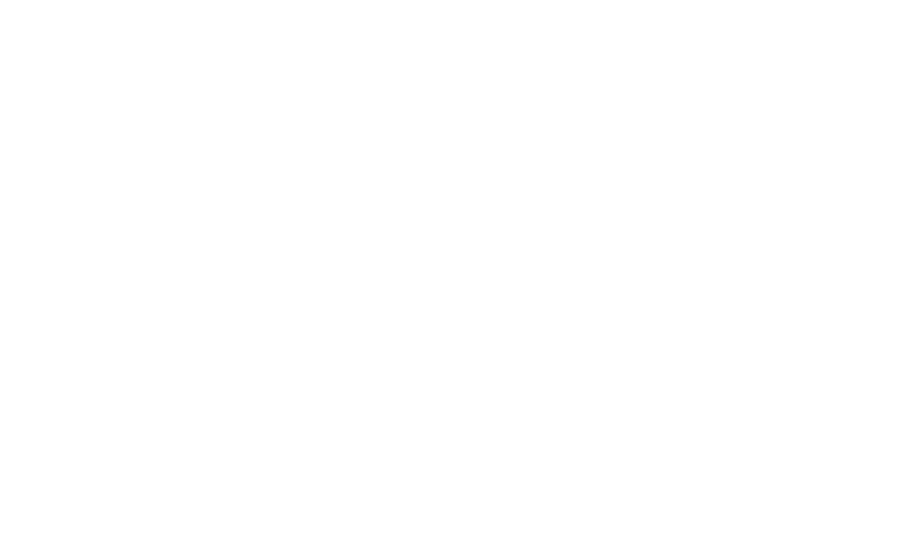

<IPython.core.display.Javascript object>


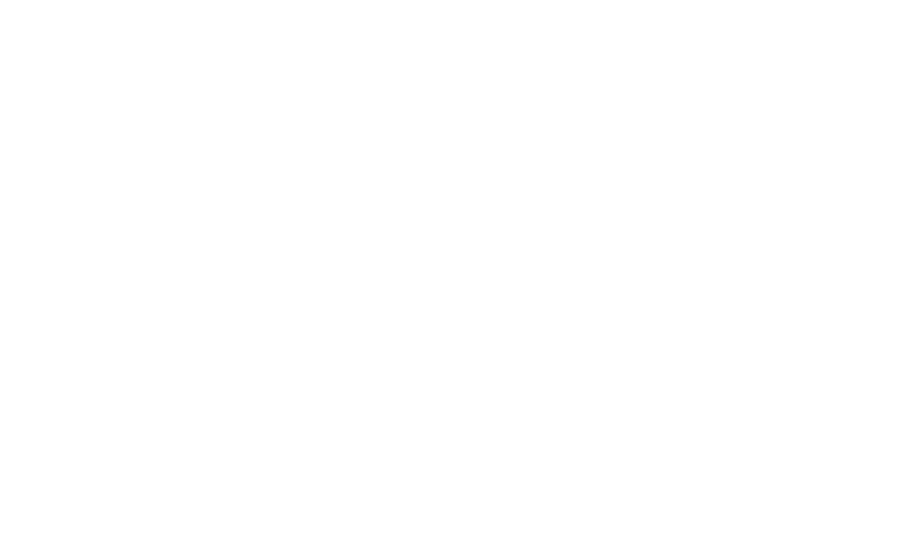

in
[ 0.04115605 -0.00431828  0.0209931  -0.01576548  0.01802678 -0.00435901
  0.01472703  0.00566466  0.07158707 -0.01963171 -0.02122345 -0.01210489
 -0.03276841  0.00379846  0.01730896 -0.03547676 -0.10302695  0.01102701
  0.0170478  -0.01844942 -0.00212018 -0.04324509  0.01326692  0.0229153
 -0.01505072 -0.00368129  0.10995261  0.00691696  0.00591056 -0.00252576
 -0.00836541 -0.0400396   0.03261182  0.0040572   0.01970061 -0.00911278
 -0.00577425 -0.00077406  0.01130832  0.02190334]
i:00 mean:0.001512(0.005213) stdev:0.032968(0.003686) Nchanged:0 Nused:40 Nskipped:0
i:01 mean:0.001714(0.003717) stdev:0.022910(0.002628) Nchanged:2 Nused:38 Nskipped:2
i:02 mean:-0.000174(0.003282) stdev:0.019961(0.002320) Nchanged:1 Nused:37 Nskipped:3
i:03 mean:-0.000174(0.003282) stdev:0.019961(0.002320) Nchanged:0 Nused:37 Nskipped:3


<IPython.core.display.Javascript object>


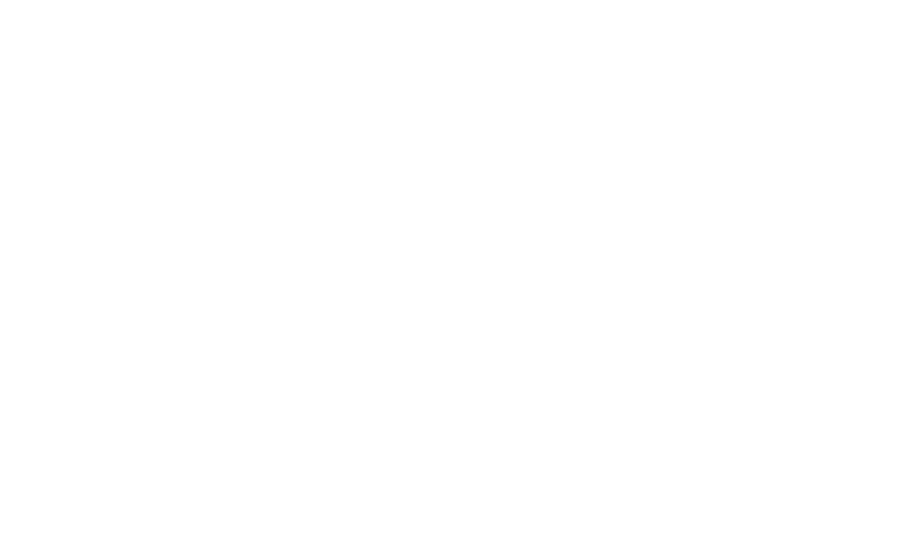

<IPython.core.display.Javascript object>


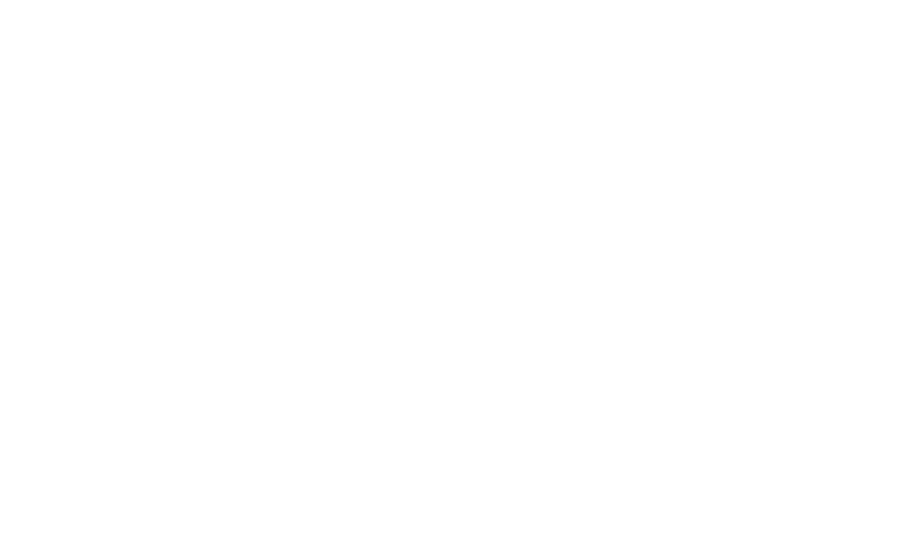

in
[ 7.55623081e-03 -1.46463764e-02 -1.28831088e-02 -1.53542750e-02
 -7.42022840e-03  2.85090280e-03 -1.33888222e-01  1.11796660e-02
  2.21904538e-02 -1.68844837e-02  1.87922562e-02  4.61597229e-01
  3.04841746e-03 -2.81993982e-03 -1.77654346e-03  9.38143643e-05
 -6.37609217e-03  3.07633956e-03 -2.41700488e-02 -1.12481767e-02
  2.47796434e-02  1.18479702e-02  8.35724573e-03  3.28847154e-03
 -2.36497505e-03  1.93351089e-02 -3.17463210e-03 -1.25672151e-02
  1.89302640e-02 -9.44424457e-02  7.50123564e-03  1.52285732e-02
  2.86663677e-03  1.71087393e-02  3.63816339e-03  1.60212011e-02
 -1.07607101e-02  7.73073507e-03]
i:00 mean:0.002958(0.013261) stdev:0.081746(0.009377) Nchanged:0 Nused:38 Nskipped:0
i:01 mean:-0.003929(0.004922) stdev:0.029939(0.003480) Nchanged:1 Nused:37 Nskipped:1
i:02 mean:0.002371(0.002136) stdev:0.012639(0.001511) Nchanged:2 Nused:35 Nskipped:3
i:03 mean:0.002371(0.002136) stdev:0.012639(0.001511) Nchanged:0 Nused:35 Nskipped:3


<IPython.core.display.Javascript object>


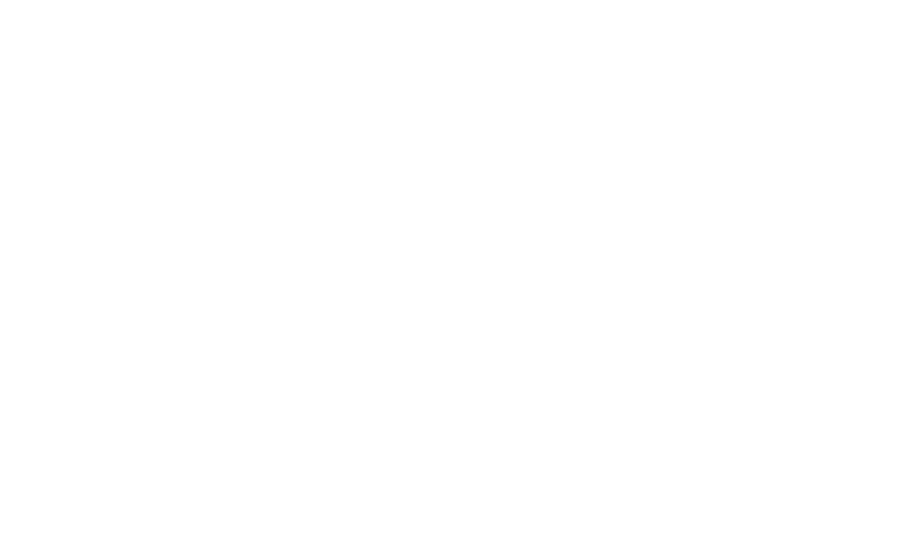

<IPython.core.display.Javascript object>


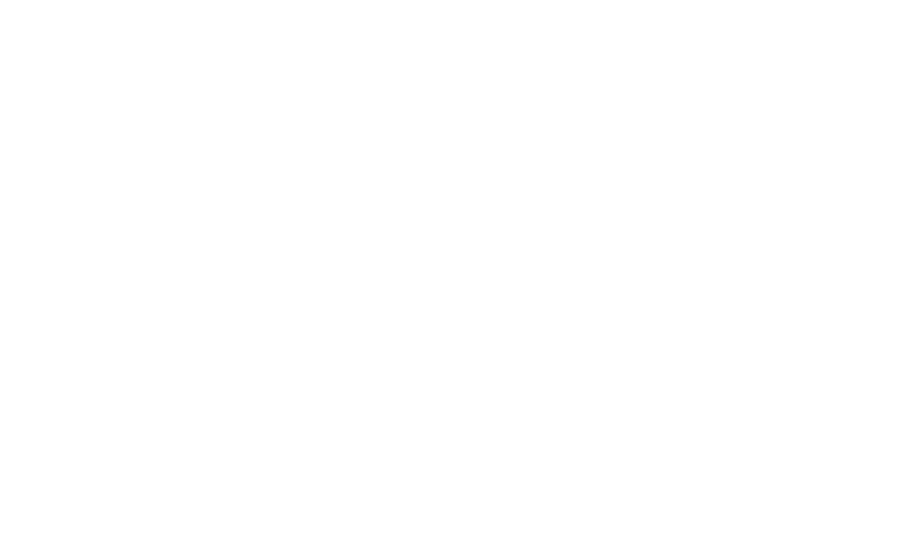

in
[ 5.11816888e-03  6.59145934e-03 -1.60184152e-02 -1.82311847e-01
  5.20146506e-03 -2.38385567e-02 -1.29449554e-02  1.55817160e-02
 -8.62945205e-03  3.85120075e-03 -7.07640793e-03 -1.05795115e-02
 -1.98851089e-02 -1.74405133e-02 -1.04642528e-02 -1.91786355e-02
 -7.01119343e-02 -4.84444464e-02 -1.11470628e-02  1.19425828e-02
 -6.42452217e-03 -1.92712571e-02  1.26297609e-02 -9.19008668e-03
  1.42602051e-02  3.49098142e-02  4.44736557e-03  1.14263069e-02
 -4.68855688e-05 -8.89565051e-03  1.34874792e-02  1.15676259e-02
  9.53560053e-04  1.39157203e-02  3.62445457e-02  7.35153181e-02
  2.07989086e-02  2.05467439e-03 -1.13272412e-02 -4.87405503e-03
 -8.53332184e-02  6.28798068e-03]
i:00 mean:-0.002460(0.005927) stdev:0.038411(0.004191) Nchanged:0 Nused:42 Nskipped:0
i:01 mean:-0.002837(0.004114) stdev:0.026340(0.002909) Nchanged:1 Nused:41 Nskipped:1
i:02 mean:-0.000775(0.003642) stdev:0.023035(0.002575) Nchanged:1 Nused:40 Nskipped:2
i:03 mean:-0.000905(0.002699) stdev:0.016637(0.001908) 

<IPython.core.display.Javascript object>


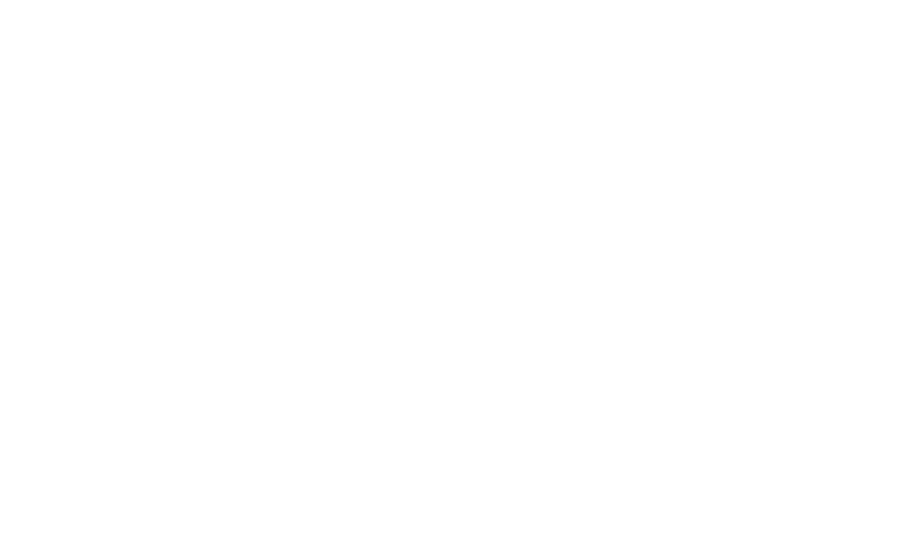

<IPython.core.display.Javascript object>


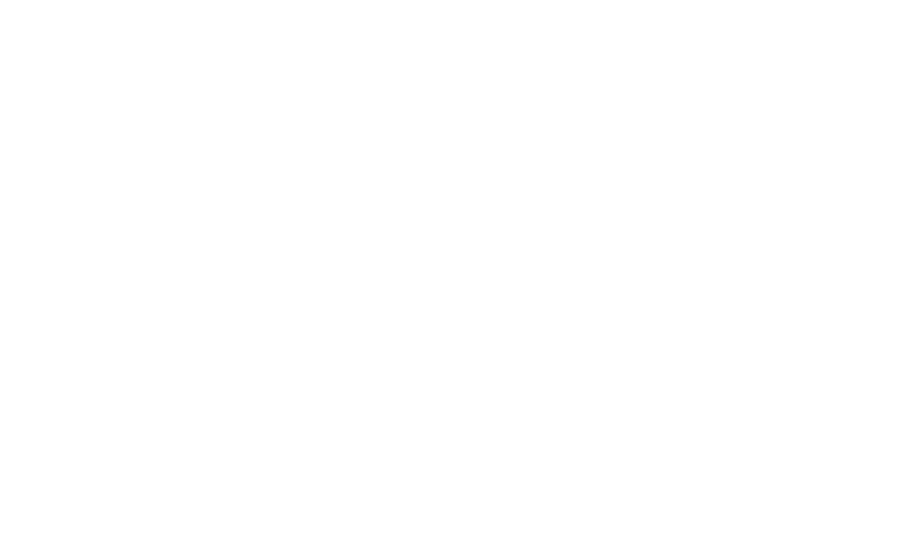

in
[-6.16325009e-03 -5.43820302e-02  1.62896833e-03 -1.48188793e-02
 -1.48866197e-02  3.53306168e-02 -1.10884587e-02  4.36332023e-03
  8.96781275e-04 -5.38755195e-02  1.06524991e-02  1.51869185e-02
 -3.70652419e-02  2.82194729e-02 -1.55089703e-02 -8.77290823e-03
 -4.50447520e-02 -3.52308082e-01  7.83664226e-03 -2.17908587e-02
  4.77943048e-03  1.08807589e-02 -5.55325484e+00 -2.15902448e-03
  1.95451425e-02  2.13446504e-02  2.27986177e-02  7.80964771e-03
  2.35608444e-02 -6.58503211e-02]
i:00 mean:-0.000631(0.190321) stdev:1.042432(0.134577) Nchanged:0 Nused:30 Nskipped:0
i:01 mean:-0.016858(0.013032) stdev:0.070180(0.009215) Nchanged:1 Nused:29 Nskipped:1
i:02 mean:-0.004878(0.005049) stdev:0.026717(0.003570) Nchanged:1 Nused:28 Nskipped:2
i:03 mean:-0.004878(0.005049) stdev:0.026717(0.003570) Nchanged:0 Nused:28 Nskipped:2


<IPython.core.display.Javascript object>


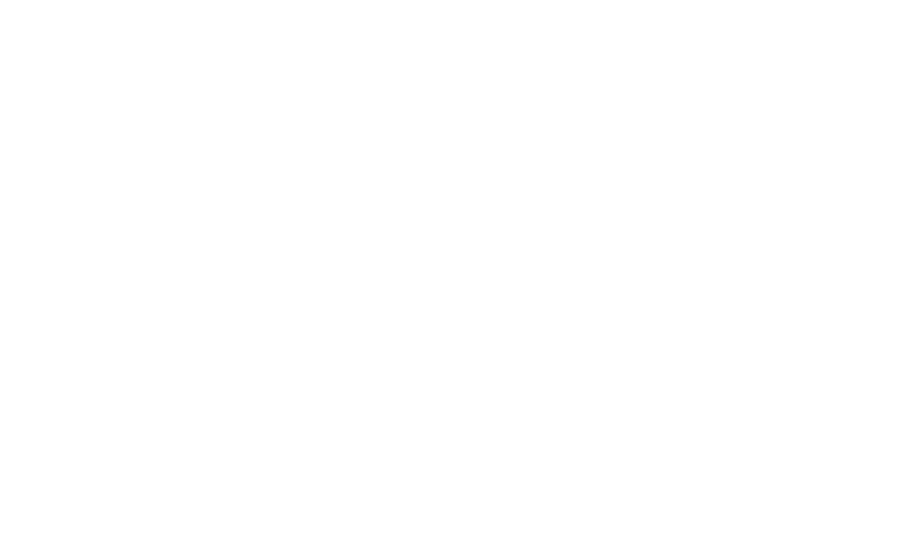

<IPython.core.display.Javascript object>


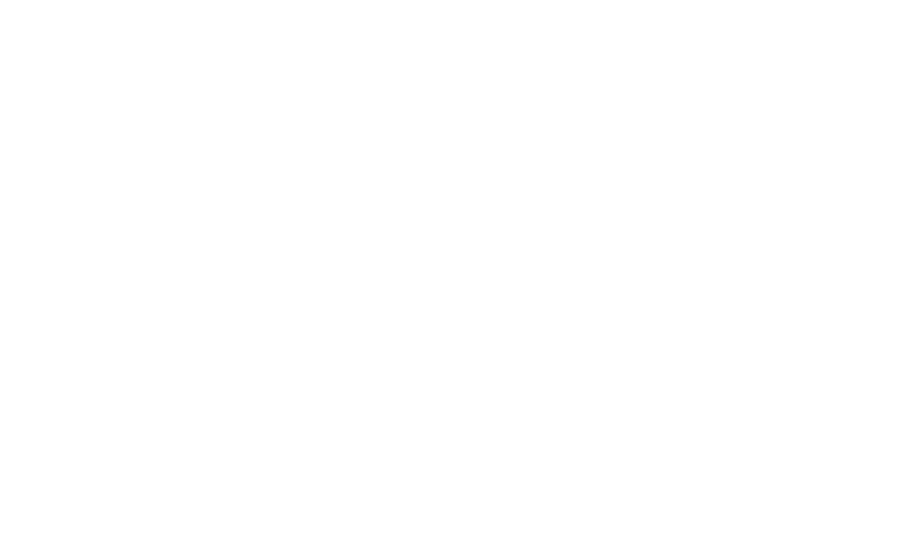

in
[-5.15962945e-02 -8.16037513e-03  8.89446232e-03 -3.56990866e-03
 -9.39020964e-03 -4.88343961e-03 -6.79858972e-03 -8.04019534e-01
 -2.96536877e-02 -2.26528108e-02  9.62217788e-03 -5.82009117e-02
  2.87889402e-02  5.97287028e-03  5.70019088e-02  8.62686846e-03
  8.50814395e-03 -1.00716235e-01 -2.46780727e-02 -8.75132050e-03
  1.69430646e-02  2.57575818e-02  1.71396686e-03 -4.10271365e-01
  2.79650850e-02  8.48351955e-03  8.74310869e-03 -3.48867639e-04
 -1.28132449e-02  1.79975995e-02 -2.50066380e-02  2.73890416e-02
 -8.63681661e-02  1.36674598e-02  1.37397826e-02 -5.62833244e-03
  4.68307742e-02  4.14996053e-02  2.16532326e-02]
i:00 mean:0.001714(0.024223) stdev:0.151271(0.017128) Nchanged:0 Nused:39 Nskipped:0
i:01 mean:-0.012360(0.012051) stdev:0.074289(0.008522) Nchanged:1 Nused:38 Nskipped:1
i:02 mean:-0.001606(0.005438) stdev:0.033077(0.003845) Nchanged:1 Nused:37 Nskipped:2
i:03 mean:-0.001606(0.005438) stdev:0.033077(0.003845) Nchanged:0 Nused:37 Nskipped:2


<IPython.core.display.Javascript object>


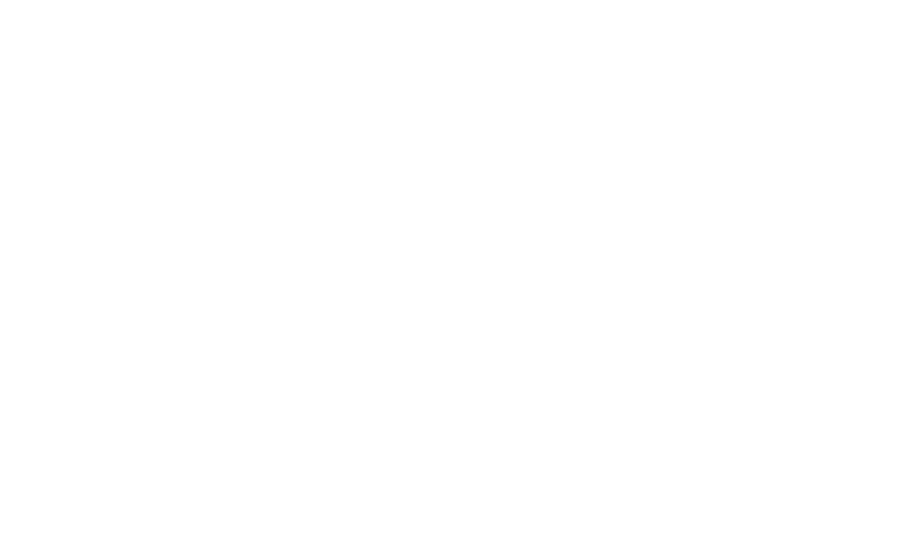

<IPython.core.display.Javascript object>


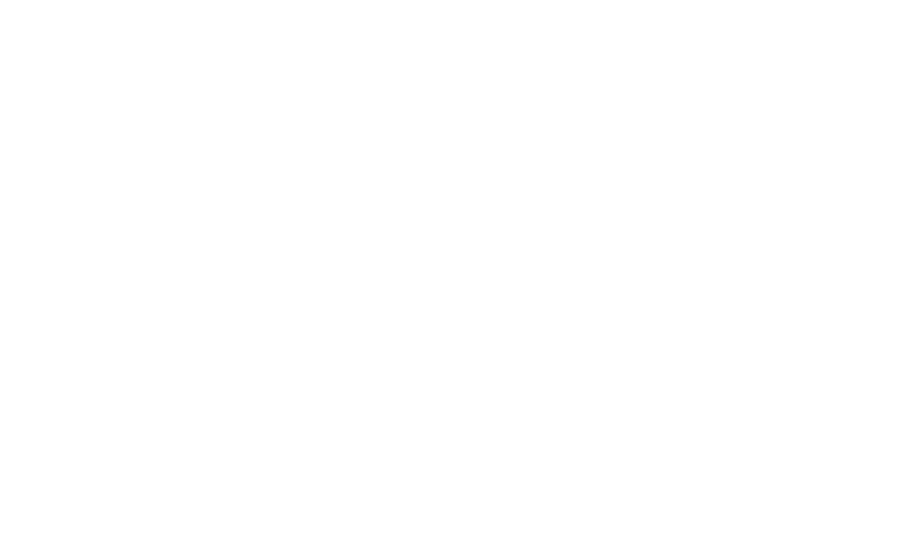

in
[-1.48097049e-02 -4.52952858e-02 -2.92498992e-02 -5.52194084e-03
  8.30211611e-03 -1.10438138e-02 -1.12395386e+00  2.20125736e-02
 -2.60460748e-02  5.60072258e-03 -2.26381207e-02 -5.48541256e-03
 -2.63061554e-03 -2.12640964e-02  2.33315140e-02 -4.77909322e-02
 -2.25248412e-02 -4.02273041e-03  1.10073569e-02 -2.09586511e-02
  2.70462550e-03  6.10177200e-03  7.98620211e-03 -1.29306602e-04
 -7.86102045e-03  6.74794531e-03  1.20449601e-03 -1.39911649e-02
 -2.83724086e-02 -3.23702555e-02  2.24452051e-02  7.64236921e-03
  9.75056921e-03  1.95479225e-02 -4.11248103e-02 -9.71217174e-03
  1.33045663e-02  7.51252734e-03  3.52086844e-03  6.46576744e-03
 -1.10767641e-01  1.08747469e-02]
i:00 mean:-0.003327(0.027445) stdev:0.177861(0.019406) Nchanged:0 Nused:42 Nskipped:0
i:01 mean:-0.007989(0.003898) stdev:0.024957(0.002756) Nchanged:1 Nused:41 Nskipped:1
i:02 mean:-0.005419(0.002991) stdev:0.018917(0.002115) Nchanged:1 Nused:40 Nskipped:2
i:03 mean:-0.005419(0.002991) stdev:0.018917(0.002115) 

<IPython.core.display.Javascript object>


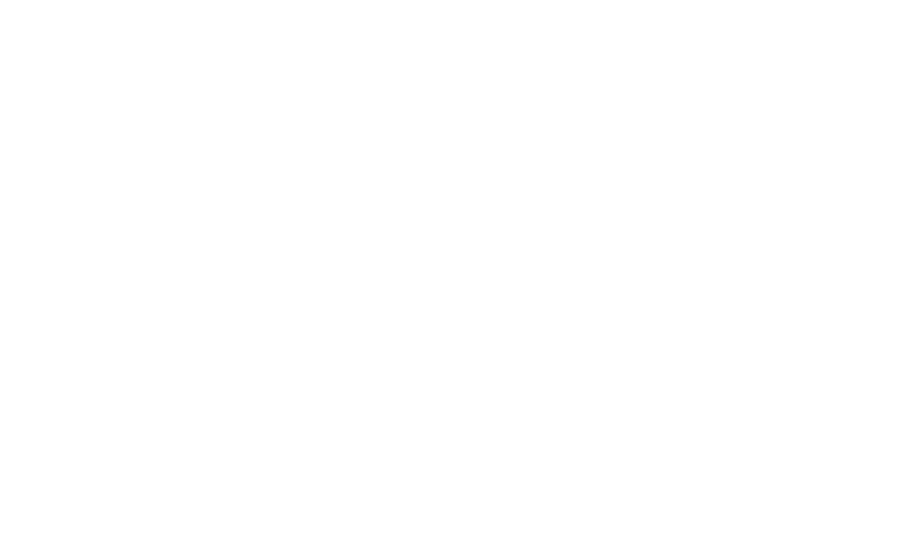

<IPython.core.display.Javascript object>


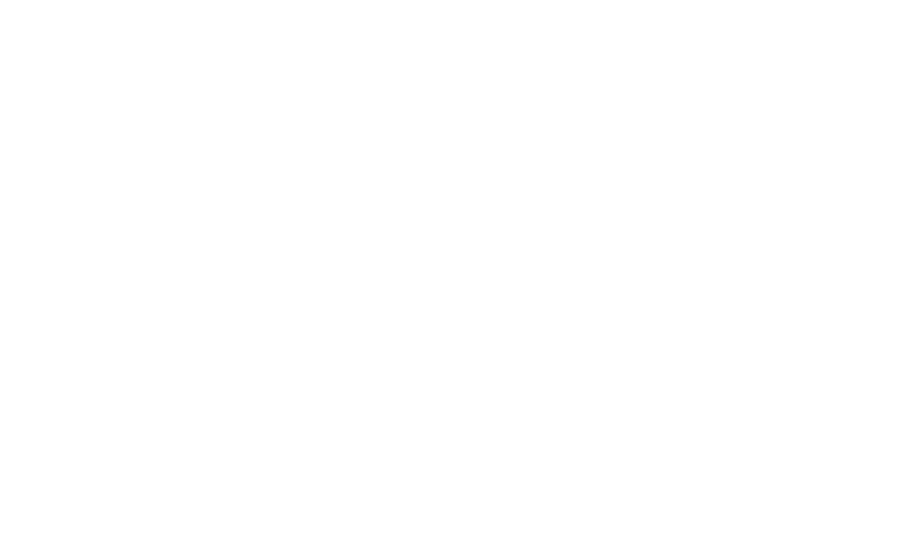

in
[ 0.01635973  0.0093339   0.02137639 -0.00764927 -0.00347482 -0.00602081
 -0.01453009 -0.00788197 -0.0085122   0.00258158  0.00543668  0.00159942
  0.01880772  0.00910381  0.01155813  0.00996338 -0.0035585   0.00524879
 -0.04235787  0.00658865 -0.00742623  0.00402425 -0.00309847 -0.00600293
  0.01196222 -0.03911926 -0.00465987 -0.0041745  -0.03951999 -0.00940277
  0.00204262 -0.14882633  0.00554358  0.00177392  0.0019033   0.01442233
 -0.00167695 -0.01867848]
i:00 mean:-0.000039(0.004655) stdev:0.028698(0.003292) Nchanged:0 Nused:38 Nskipped:0
i:01 mean:-0.001841(0.002438) stdev:0.014828(0.001724) Nchanged:1 Nused:37 Nskipped:1
i:02 mean:-0.001841(0.002438) stdev:0.014828(0.001724) Nchanged:0 Nused:37 Nskipped:1


<IPython.core.display.Javascript object>


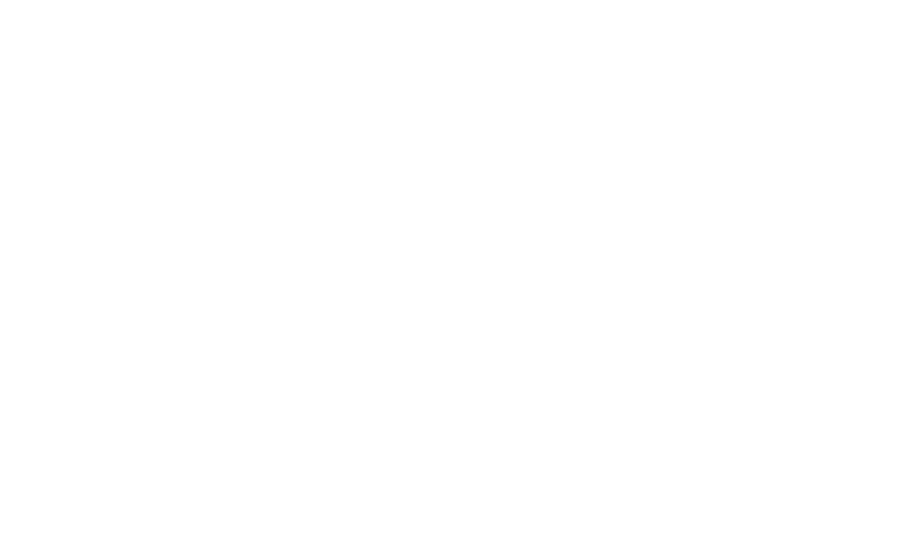

<IPython.core.display.Javascript object>


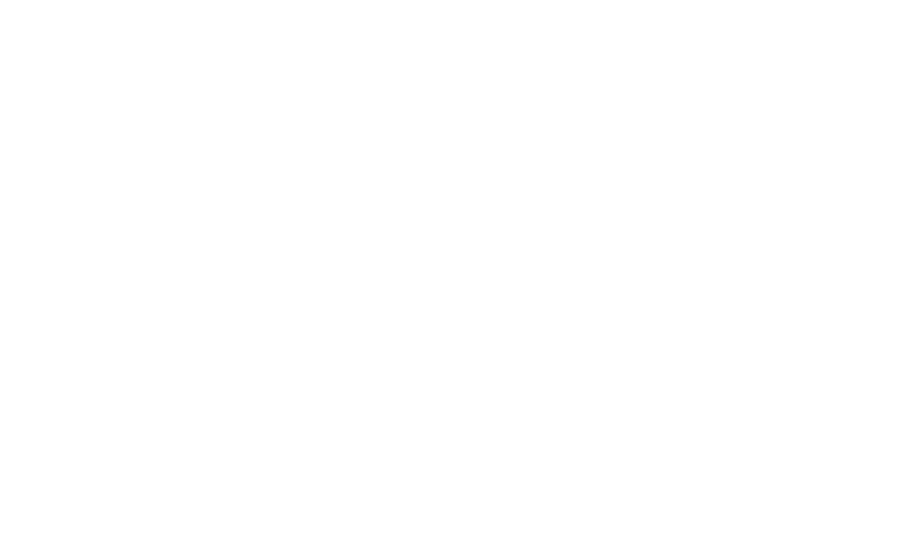

in
[ 0.00467457 -0.0067271  -0.00604252  0.01993856  0.01577587 -0.00714841
  0.02672682 -0.01757419 -0.01261021 -0.00165549  0.03029904  0.01128738
  0.00345514 -0.01706226 -0.00820589  0.01880641  0.04855999  0.02829499
  0.01537704 -0.00699262 -0.00946772 -0.005349    0.00119982 -0.17744384
  0.01488942 -0.03105779 -0.03270628 -0.0130806   0.00245694  0.00519633
  0.04742704 -0.01811867 -0.01327383  0.00167061  0.01189864 -0.02014098
 -0.01609584 -0.03186277  0.00422599 -0.01052553  0.02283459  0.00705517
 -0.0687184   0.01503639]
i:00 mean:-0.000228(0.005243) stdev:0.034780(0.003708) Nchanged:0 Nused:44 Nskipped:0
i:01 mean:0.000062(0.003348) stdev:0.021955(0.002367) Nchanged:1 Nused:43 Nskipped:1
i:02 mean:0.001700(0.002985) stdev:0.019348(0.002111) Nchanged:1 Nused:42 Nskipped:2
i:03 mean:0.001700(0.002985) stdev:0.019348(0.002111) Nchanged:0 Nused:42 Nskipped:2


<IPython.core.display.Javascript object>


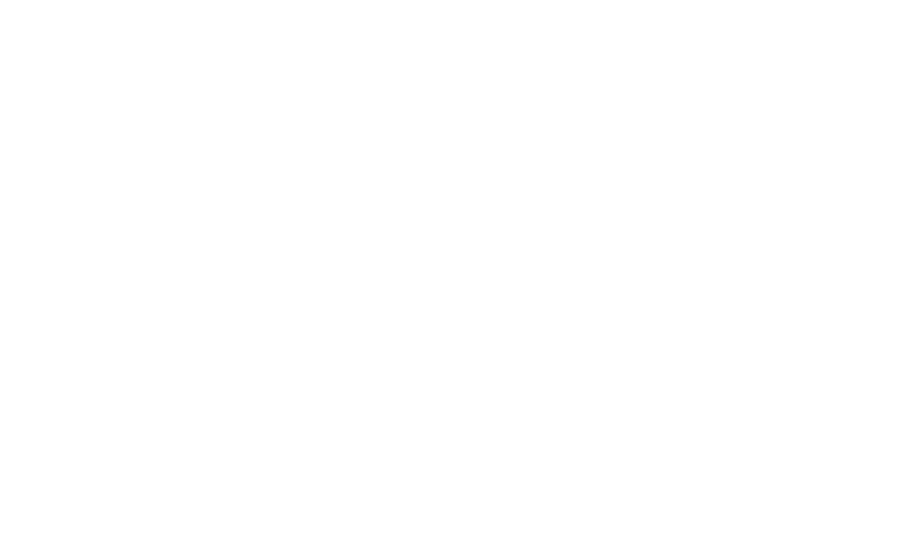

<IPython.core.display.Javascript object>


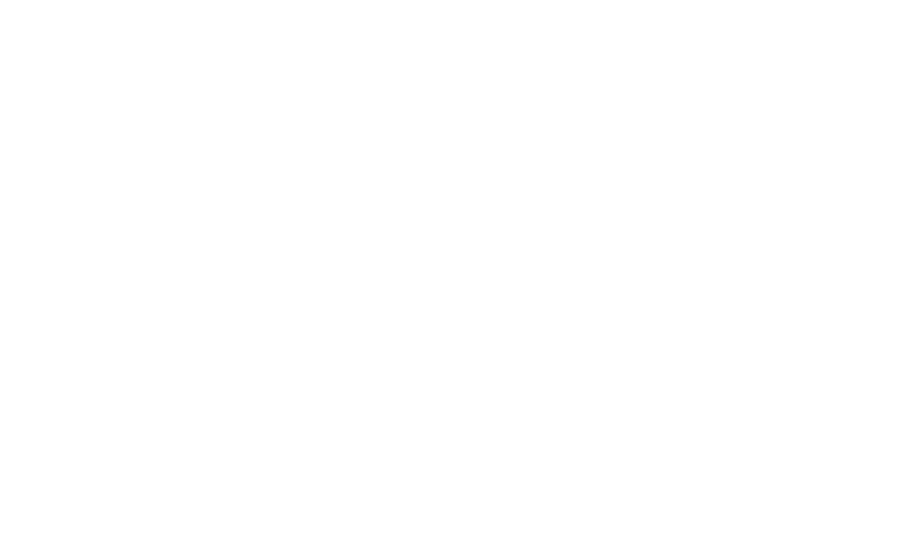

in
[ 0.01262335  0.00385229  0.010669   -0.59020925  0.01177149 -0.01153185
 -0.03114973  0.03405405 -0.00682507  0.01350602  0.00675852  0.00647176
  0.03527326  0.05129881 -0.13855342  0.02008377 -0.00864009 -0.01395962
 -0.01899635  0.01088762 -0.14561618 -0.00834609  0.00731661 -0.01392881
  0.00654476  0.06203151 -0.01062961 -0.00774263  0.01257374  0.01101204
 -0.01098951 -0.01201074  0.01682889 -0.00715564 -0.0115423  -0.0067461
 -0.01014421 -0.00512245  0.00958683]
i:00 mean:-0.005122(0.016455) stdev:0.102760(0.011635) Nchanged:0 Nused:39 Nskipped:0
i:01 mean:-0.003592(0.006216) stdev:0.038321(0.004396) Nchanged:1 Nused:38 Nskipped:1
i:02 mean:0.004102(0.003246) stdev:0.019476(0.002295) Nchanged:2 Nused:36 Nskipped:3
i:03 mean:0.004102(0.003246) stdev:0.019476(0.002295) Nchanged:0 Nused:36 Nskipped:3


<IPython.core.display.Javascript object>


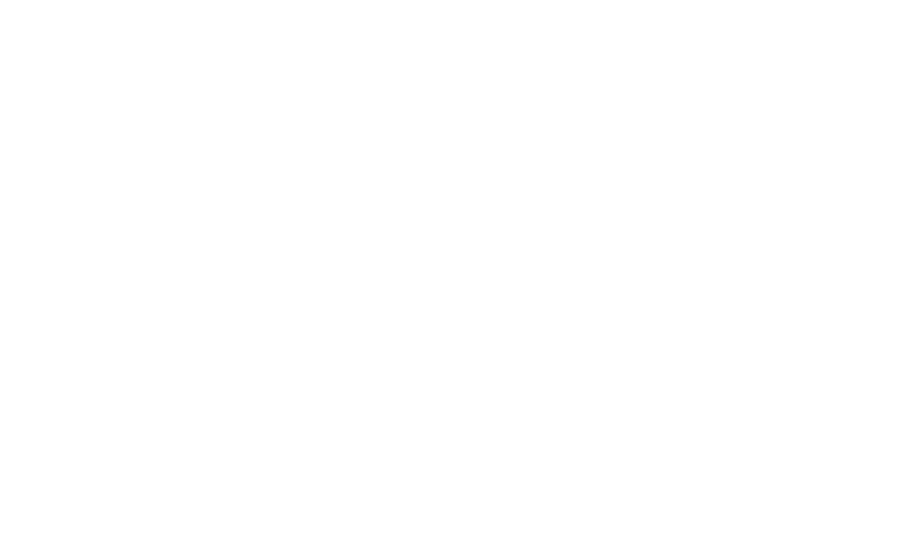

<IPython.core.display.Javascript object>


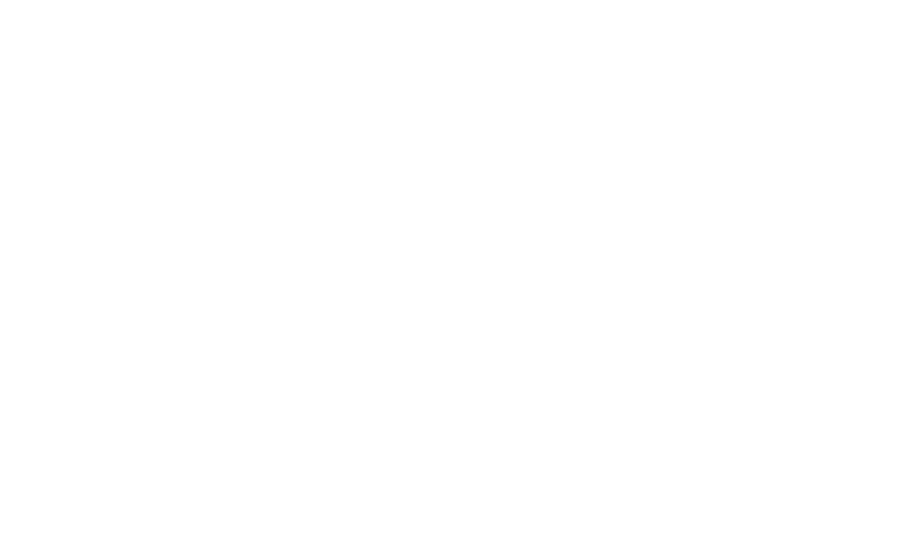

in
[ 4.74115812e-02  1.89939646e-03  3.22025960e-01  1.36289198e-02
  1.34553151e-02 -9.71607809e-03 -1.17599513e-02  3.62391025e-03
  2.15554548e-02 -1.90042642e-01 -2.39709261e-02  3.10535999e-02
 -1.27290330e-02  6.98134874e-03  9.79109931e-03  9.80387675e-03
 -4.06732230e-02 -4.02090768e-03  7.35871327e-03  1.63606247e-02
 -3.18612231e-02 -2.40632576e-02  1.25695026e-02 -1.37638734e-02
 -8.01542034e-03  2.27976699e-03 -2.43525942e-01 -2.52611795e-02
  1.69360019e-02 -2.70223419e-02 -2.23939558e-02  7.34935383e-03
 -1.50110843e-02  1.49226032e-02 -5.46000178e-02 -1.60837685e-02
  7.44149340e-07  6.54470690e-03]
i:00 mean:0.000950(0.012443) stdev:0.076704(0.008799) Nchanged:0 Nused:38 Nskipped:0
i:01 mean:-0.007985(0.006283) stdev:0.037699(0.004443) Nchanged:2 Nused:36 Nskipped:2
i:02 mean:-0.002783(0.003570) stdev:0.021120(0.002524) Nchanged:1 Nused:35 Nskipped:3
i:03 mean:-0.002783(0.003570) stdev:0.021120(0.002524) Nchanged:0 Nused:35 Nskipped:3


<IPython.core.display.Javascript object>


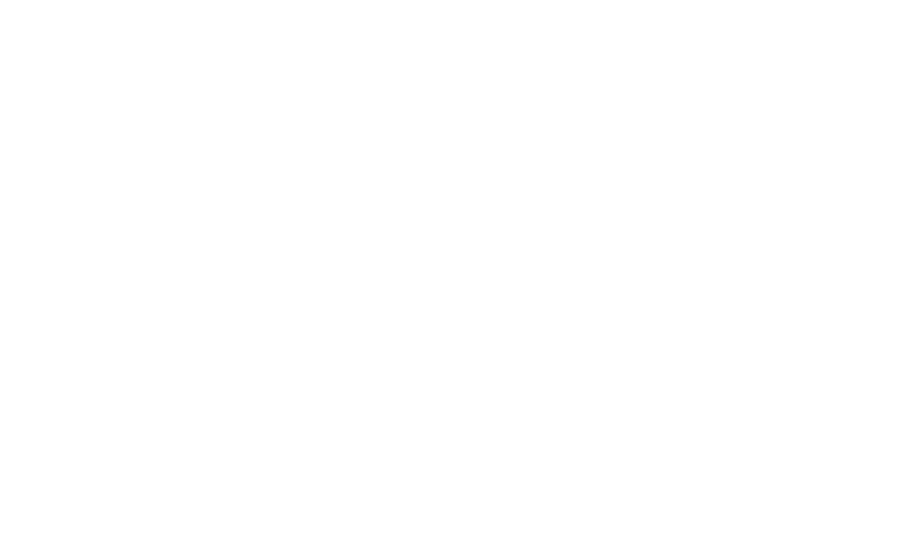

<IPython.core.display.Javascript object>


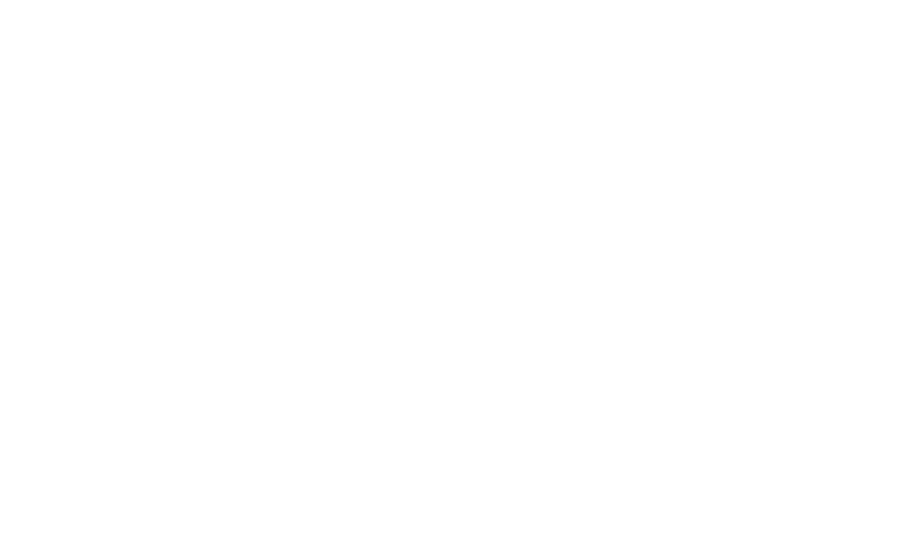

in
[-1.47545110e-02 -9.26341881e-03  2.69264192e-02  2.34389594e-02
  1.15931450e-02 -5.84166436e-02  1.43376330e-02  9.06790715e-01
  7.82335044e-03 -1.76552094e-02  2.30645172e-02 -2.30612634e-02
 -3.29682629e-01  1.14536429e-02  1.22769343e-03 -1.04306863e-02
 -4.53160976e-03  1.46168756e-02 -3.54613209e-03  1.57418533e-02
 -1.63372714e-03  5.09618085e-03  6.96482035e-01  1.05352439e-02
 -1.33108900e+00  6.48483514e-03  2.21062147e-01 -5.08945954e-02
 -5.40533978e-03 -1.84188863e-03  8.77841751e-03 -3.52676243e-03
  1.12547110e-02  7.45263534e-03  3.26170529e-02 -8.77771805e-03
 -8.23866434e-03  4.31787486e-03 -2.48170553e-03  1.23820309e-02]
i:00 mean:0.004707(0.045921) stdev:0.290433(0.032471) Nchanged:0 Nused:40 Nskipped:0
i:01 mean:0.016120(0.021559) stdev:0.132900(0.015245) Nchanged:2 Nused:38 Nskipped:2
i:02 mean:-0.002269(0.011354) stdev:0.069062(0.008028) Nchanged:1 Nused:37 Nskipped:3
i:03 mean:0.000705(0.003192) stdev:0.018885(0.002257) Nchanged:2 Nused:35 Nskipped:5
i:04 

<IPython.core.display.Javascript object>


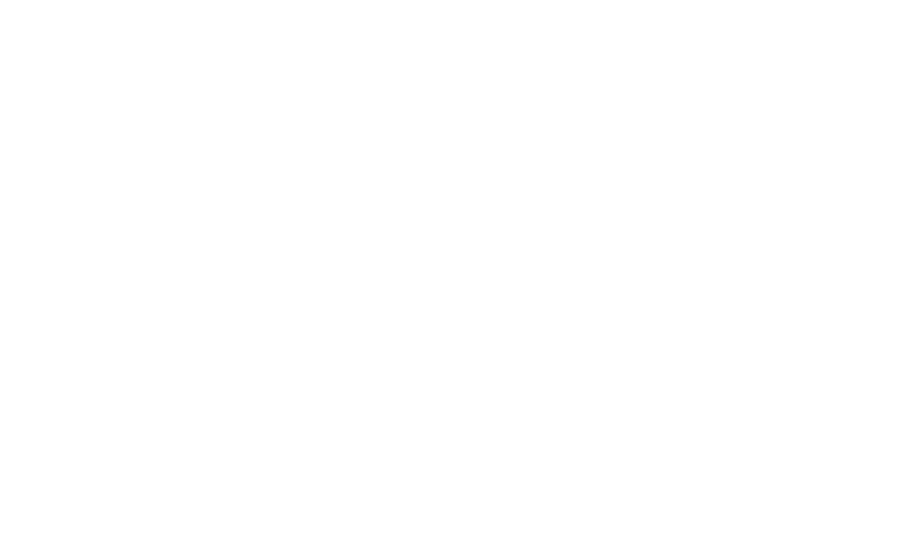

<IPython.core.display.Javascript object>


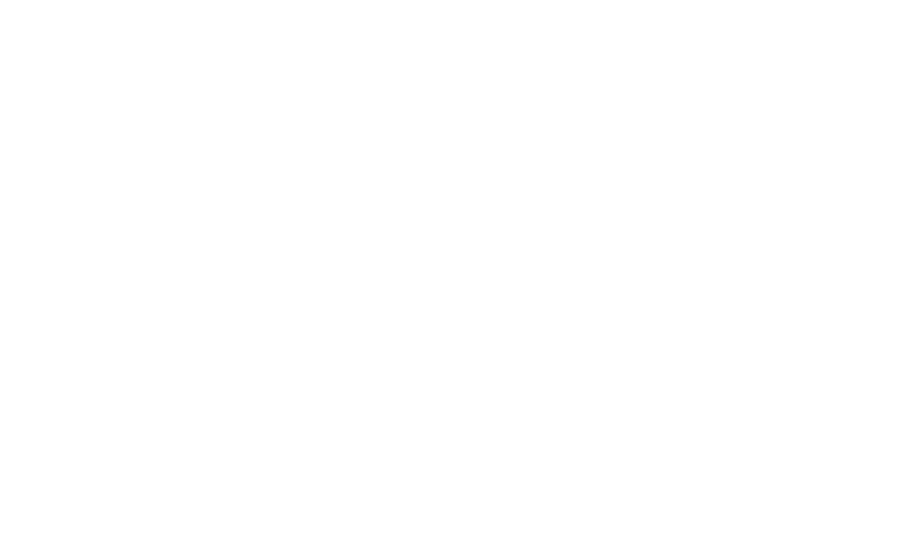

in
[ 0.01036285 -0.18508907 -0.00602569  0.00479486 -0.01338016  0.01690008
  0.00293802 -0.00455548 -0.07548591  0.01715804  0.00618807  0.00552386
 -0.00663555 -0.0054804   0.01295917  0.00493815  0.0136936  -0.00397955
  0.0039101   0.00888953 -0.00641626 -0.01836952 -0.0212818   0.02625356
  0.02407487 -0.01167289  0.01903159 -0.02889745 -0.00681733]
i:00 mean:0.002938(0.007639) stdev:0.041138(0.005402) Nchanged:0 Nused:29 Nskipped:0
i:01 mean:-0.001121(0.003803) stdev:0.020122(0.002689) Nchanged:1 Nused:28 Nskipped:1
i:02 mean:0.001633(0.002694) stdev:0.013996(0.001905) Nchanged:1 Nused:27 Nskipped:2
i:03 mean:0.001633(0.002694) stdev:0.013996(0.001905) Nchanged:0 Nused:27 Nskipped:2


<IPython.core.display.Javascript object>


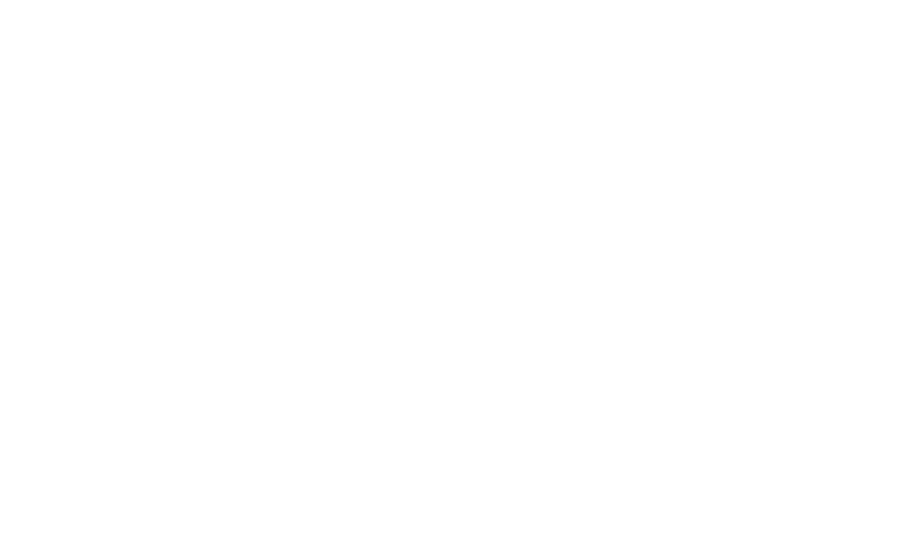

<IPython.core.display.Javascript object>


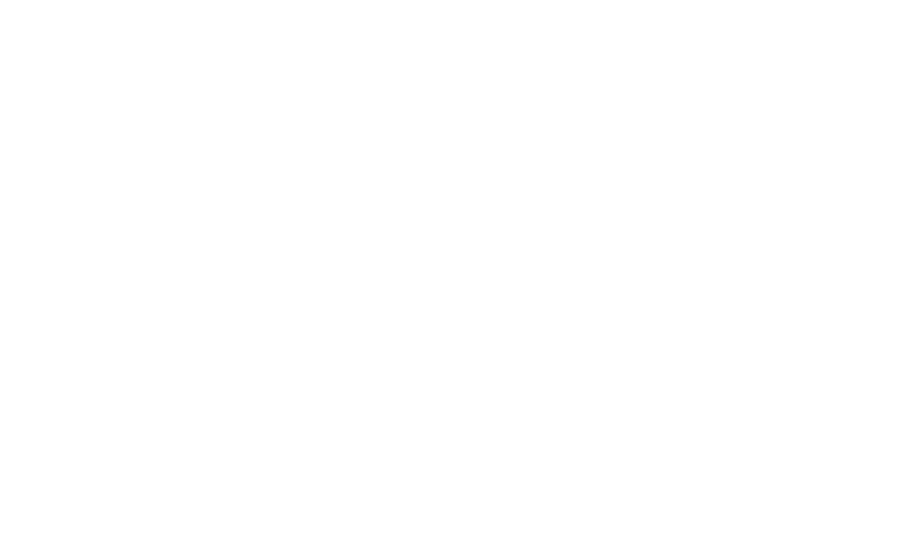

in
[-0.03286533 -0.00439669  0.00409074 -0.07731853  0.00762408 -0.01405447
 -0.00963369  0.01412753  0.02861847  0.04239551  0.00132072 -0.01067081
  0.04136101 -0.05470968  0.0072548  -0.00490489 -0.03173738  0.01785279
 -0.04516033  0.00643047  0.01098243  0.00799373 -0.00342966 -0.02576555
 -0.02367116  0.00032661  0.00708866 -0.01946826]
i:00 mean:-0.001552(0.005189) stdev:0.027457(0.003669) Nchanged:0 Nused:28 Nskipped:0
i:01 mean:-0.005726(0.005125) stdev:0.027120(0.003624) Nchanged:0 Nused:28 Nskipped:0


<IPython.core.display.Javascript object>


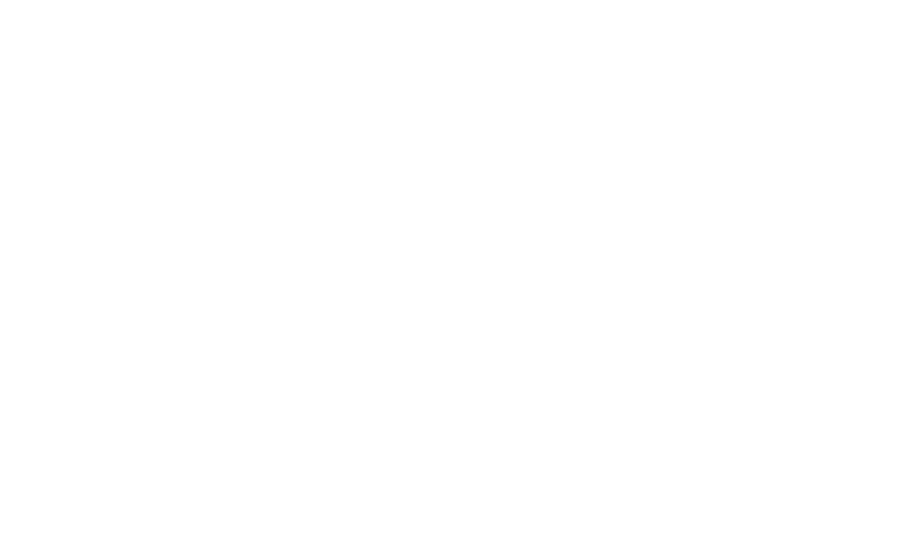

<IPython.core.display.Javascript object>


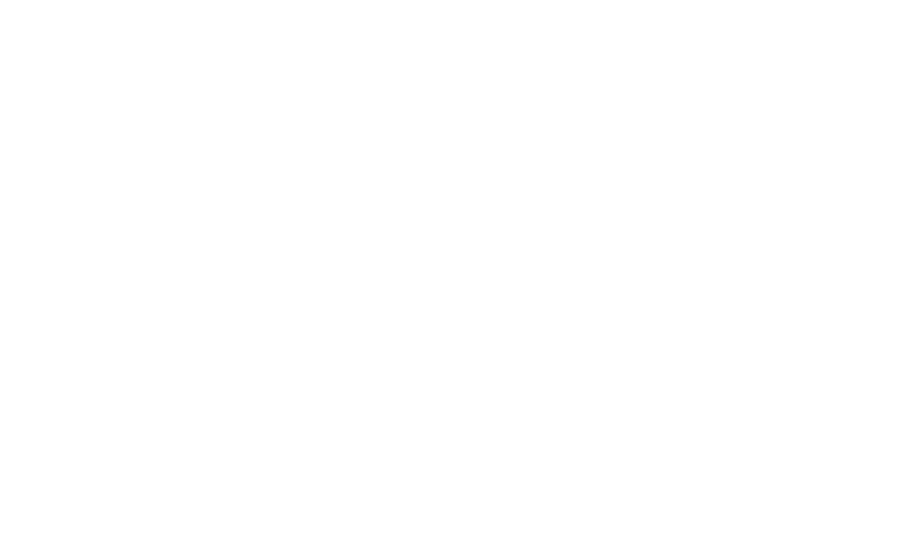

in
[ 2.94115705e-03  1.06608274e-02  2.30169674e-02 -1.23401790e-02
  2.47269853e-03  1.19001277e-02  1.55711084e-02 -3.54773665e-02
  1.70704525e-02  2.44654305e-04  1.15838907e-02  1.03248489e-02
  4.04575011e-03 -7.41221050e-03 -1.13607791e-02 -5.22654957e-03
 -6.98599653e-03 -5.44095064e-03  1.28960263e-02 -4.82648608e-04
 -1.28515805e-02 -6.21140279e-03  1.89399416e-02 -6.53427140e-02
  2.92533300e-03  1.06732803e-02 -1.40767840e-02 -1.96810811e-01
  6.45484620e-03 -1.52626572e-02  8.80267225e-03 -3.13372937e-02
 -2.27911170e-02 -6.12039580e-01  1.89807295e-02]
i:00 mean:0.000245(0.019028) stdev:0.112573(0.013455) Nchanged:0 Nused:35 Nskipped:0
i:01 mean:-0.007644(0.006561) stdev:0.038257(0.004639) Nchanged:1 Nused:34 Nskipped:1
i:02 mean:-0.001912(0.003209) stdev:0.018433(0.002269) Nchanged:1 Nused:33 Nskipped:2
i:03 mean:0.000070(0.002591) stdev:0.014659(0.001832) Nchanged:1 Nused:32 Nskipped:3
i:04 mean:0.000070(0.002591) stdev:0.014659(0.001832) Nchanged:0 Nused:32 Nskipped:3


<IPython.core.display.Javascript object>


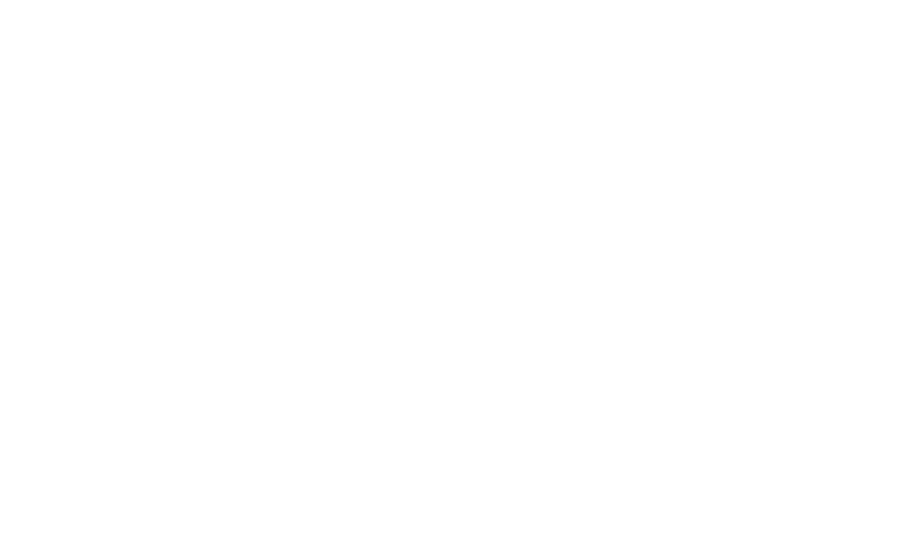

<IPython.core.display.Javascript object>


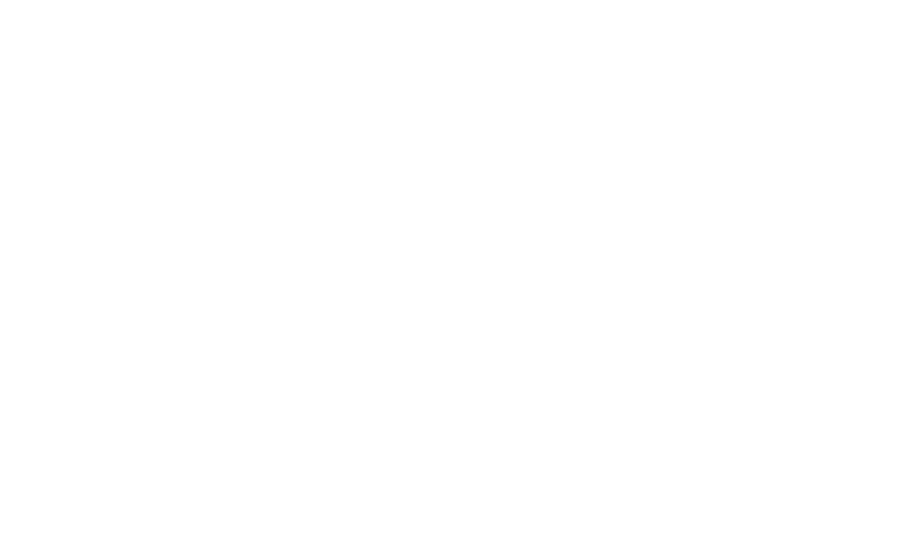

in
[ 0.00531835 -0.00691864 -0.00505441 -0.03019115  0.02029187  0.01759841
 -0.0224423  -0.04349135 -0.00480943 -0.26192998  0.0080143  -0.00116874
  0.0038587  -0.00721922  0.00999849  0.00893246 -0.00676361 -0.00916029
 -0.02042172  0.01349657  0.01438933 -0.01178021  0.00700293 -0.12985684
 -0.01338584 -0.05172442  0.00622509  0.01047972 -0.0311914   0.00585362
  0.0046339  -0.00478657 -0.04490502  0.00987537  0.00217484  0.01434393
  0.01600879  0.00417654  0.0306231   0.01530641 -0.02192009  0.01130149
 -0.00165735]
i:00 mean:0.002175(0.007554) stdev:0.049534(0.005341) Nchanged:0 Nused:43 Nskipped:0
i:01 mean:-0.005451(0.004174) stdev:0.027052(0.002952) Nchanged:1 Nused:42 Nskipped:1
i:02 mean:-0.002417(0.002917) stdev:0.018681(0.002063) Nchanged:1 Nused:41 Nskipped:2
i:03 mean:-0.002417(0.002917) stdev:0.018681(0.002063) Nchanged:0 Nused:41 Nskipped:2


<IPython.core.display.Javascript object>


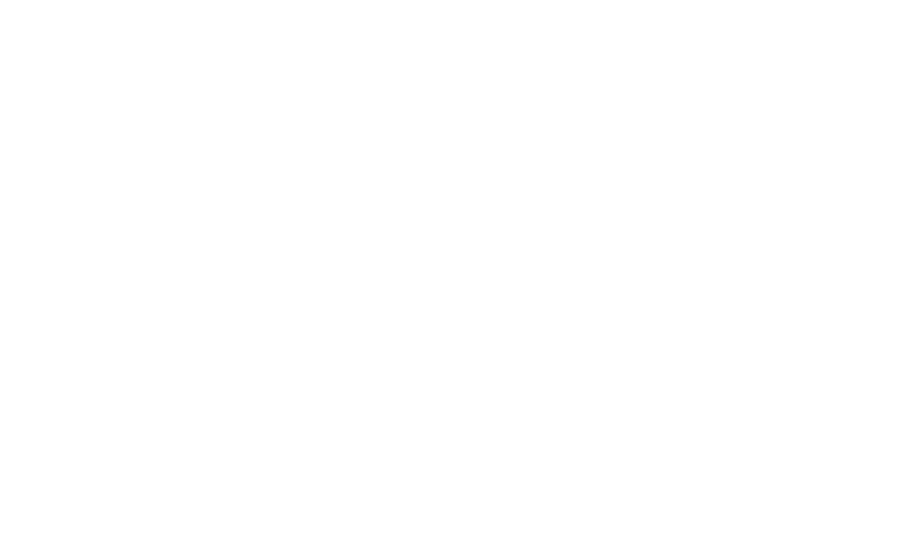

<IPython.core.display.Javascript object>


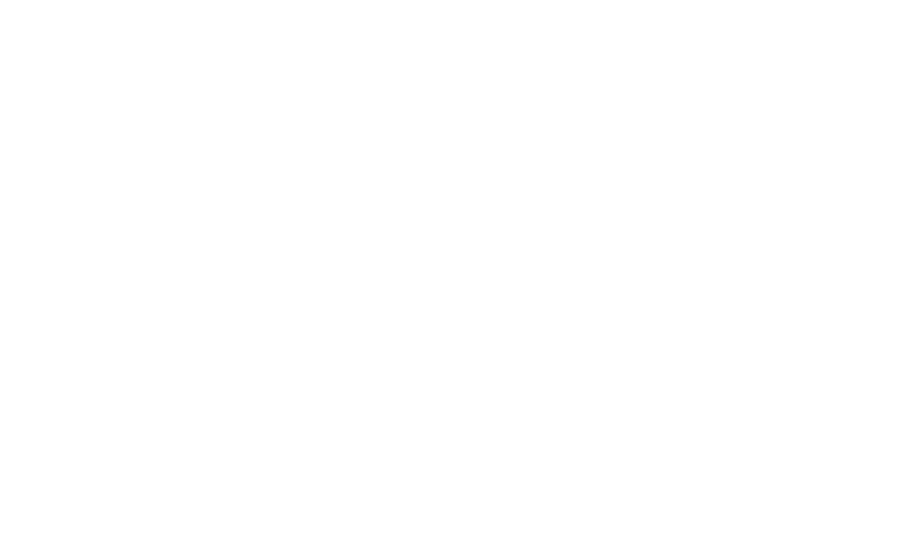

in
[-0.01759937 -0.00873969  0.00528025 -0.01084545 -0.04549209  0.00680767
 -0.00711904 -1.53793837 -0.04952042 -0.05993409 -0.02571921 -0.00250819
 -0.01707816 -0.00994228 -0.02070946 -0.04479211  0.03181859 -0.01020432
  0.01166505 -0.02603272 -1.00505441 -0.0162323  -0.00847509  0.01288721
  0.00903633  0.0237288   0.01453064  0.04452504 -0.25577902 -0.00369797
 -0.02004854 -0.15371436 -0.01031002  0.00487811 -0.00842712  0.01180738
  0.02143114 -0.22016695  0.00326191  0.01751038  0.00824705  0.02279527
 -0.00235586  0.00866416  0.0206167  -0.04793441  0.01078808  0.00394002
 -0.02443798  0.00968265 -0.00482675  0.01440633  0.01308093  0.03205263
 -0.00734411  0.00924193  0.01260728 -0.01520956 -0.00508137  0.02271592
 -0.00644694 -0.03505561  0.00916719 -0.01374836  0.00569797  0.01278249
 -0.00948697  0.01114457  0.02398883 -0.01552239  0.01847539  0.02283747
  0.01503002  0.01422542]
i:00 mean:-0.002432(0.025641) stdev:0.220573(0.018131) Nchanged:0 Nused:74 Nskipped:0
i:01 mean

<IPython.core.display.Javascript object>


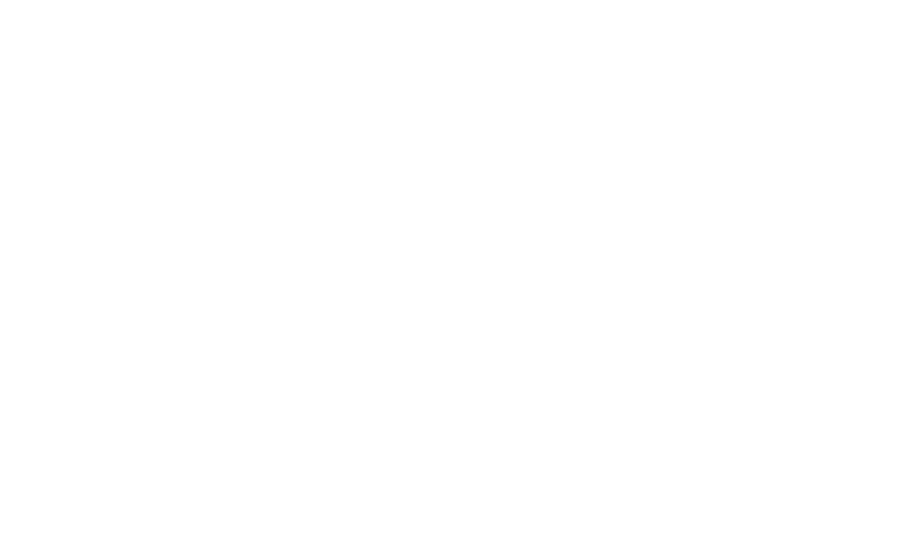

<IPython.core.display.Javascript object>


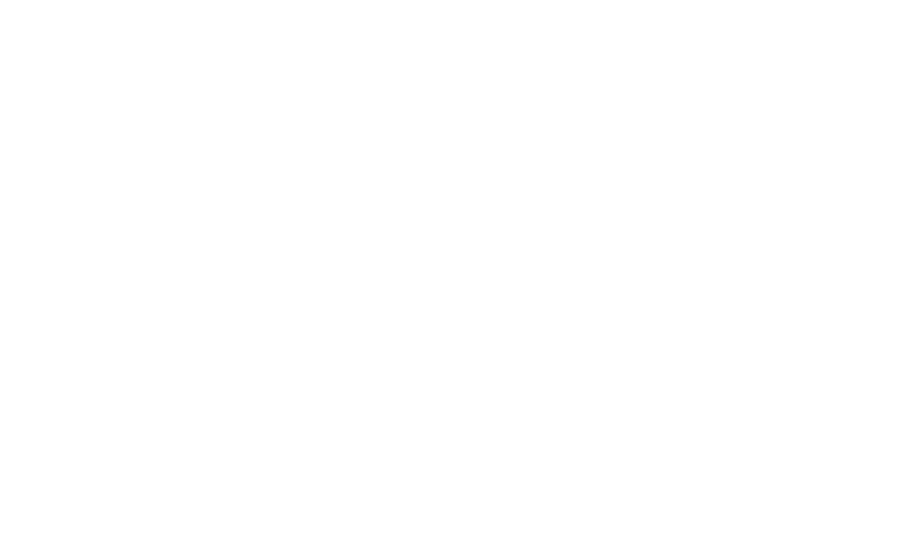

in
[ 2.41882957e-02 -6.57673736e-03  6.08542299e-03 -2.99440230e-02
  1.05264891e-02 -2.31374522e-02 -2.22465905e-02 -5.92435076e-02
  1.63509942e-03  4.90813980e-03 -2.55258494e-02 -1.07266992e-03
 -5.07842604e-03  1.84570602e-02  2.04267262e-02 -1.64208336e-02
 -1.15446554e-02  8.40535941e-03 -2.22595195e-03  1.33173451e-02
 -3.36989217e-03  1.60928683e-02 -4.69630715e-03  1.43662297e-02
 -1.05956571e-01 -1.11468386e-01  2.01507007e-02 -5.44552131e-03
 -1.25130060e-02 -8.61994802e-03 -1.33404253e+00  1.39886515e-02
  7.24220442e-03 -3.81099133e-03  2.08217806e-02  1.69043120e-02
  1.00674927e-02 -2.55653937e-02  1.42020223e-02  7.41669173e-03
  1.89000683e-02  2.53082713e-02]
i:00 mean:0.000281(0.032679) stdev:0.211784(0.023108) Nchanged:0 Nused:42 Nskipped:0
i:01 mean:-0.004660(0.004665) stdev:0.029872(0.003299) Nchanged:1 Nused:41 Nskipped:1
i:02 mean:0.000676(0.002920) stdev:0.018235(0.002065) Nchanged:2 Nused:39 Nskipped:3
i:03 mean:0.002253(0.002517) stdev:0.015514(0.001780) Nch

<IPython.core.display.Javascript object>


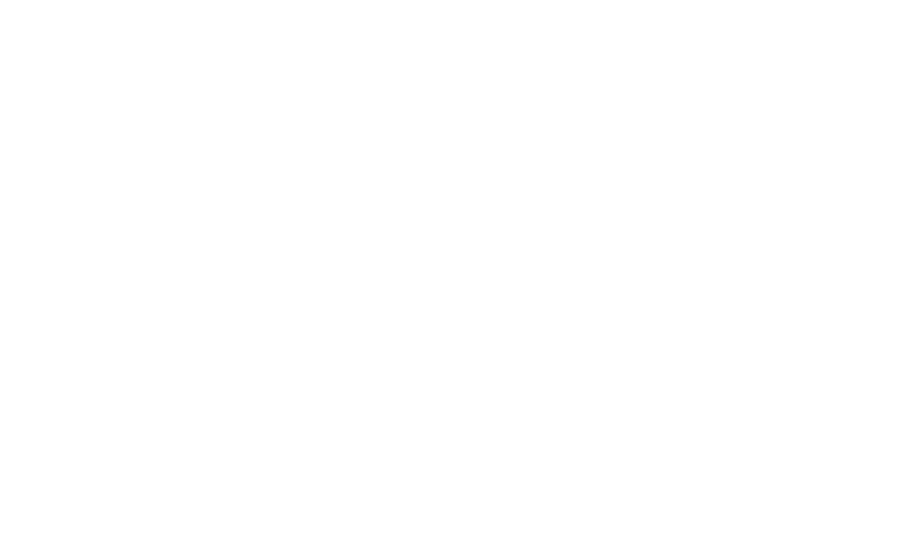

<IPython.core.display.Javascript object>


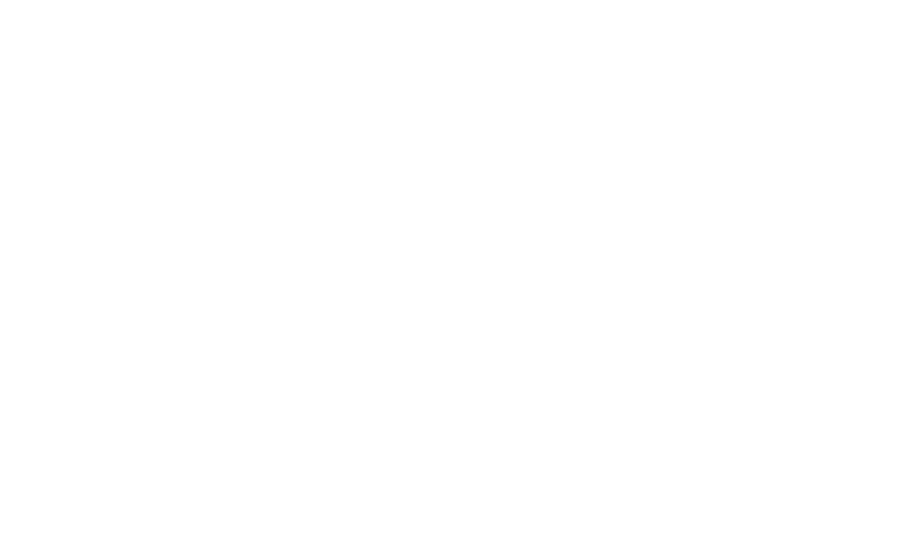

in
[ 0.02215517  0.0154896  -0.03496522  0.0058428   0.02116567 -0.00344075
  0.01066682  0.02053211 -0.16094302  0.01681792  0.02673661 -0.00213894
 -0.01276561  0.0185191  -0.01745673 -0.00527292 -0.00566228 -0.00544862
  0.03179594 -0.00431049 -0.00795304  0.00724081  0.00074531 -0.03104288
 -0.04036382  0.00794747 -0.00518891  0.01587321 -0.00164996  0.00498867
 -0.00565898  0.06227963 -0.02795278 -0.01664924  0.00964815 -0.00777413
 -0.01587772 -0.01416066  0.00349896 -0.73431611 -0.01005581 -0.02540853]
i:00 mean:-0.003876(0.018371) stdev:0.119061(0.012991) Nchanged:0 Nused:42 Nskipped:0
i:01 mean:-0.003907(0.005007) stdev:0.032061(0.003541) Nchanged:1 Nused:41 Nskipped:1
i:02 mean:0.000019(0.003155) stdev:0.019952(0.002231) Nchanged:1 Nused:40 Nskipped:2
i:03 mean:-0.001578(0.002786) stdev:0.017398(0.001970) Nchanged:1 Nused:39 Nskipped:3
i:04 mean:-0.001578(0.002786) stdev:0.017398(0.001970) Nchanged:0 Nused:39 Nskipped:3


<IPython.core.display.Javascript object>


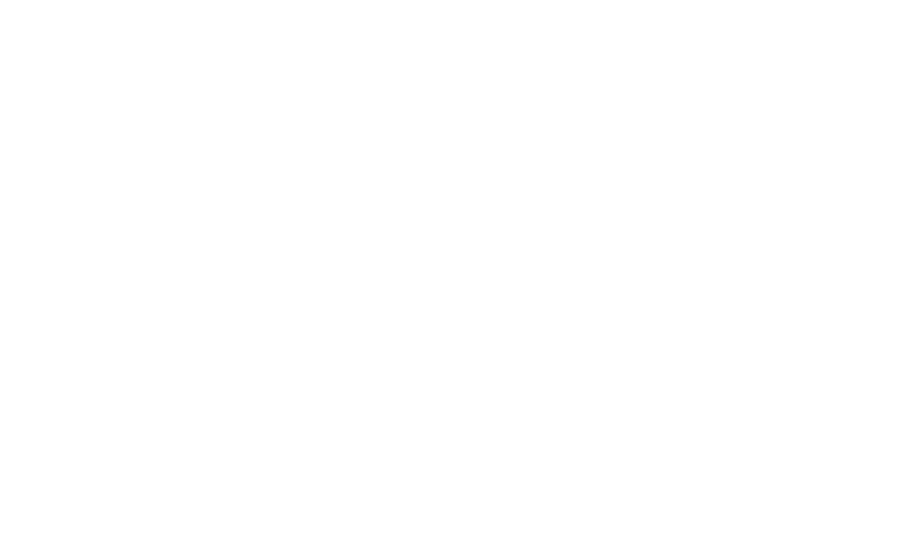

<IPython.core.display.Javascript object>


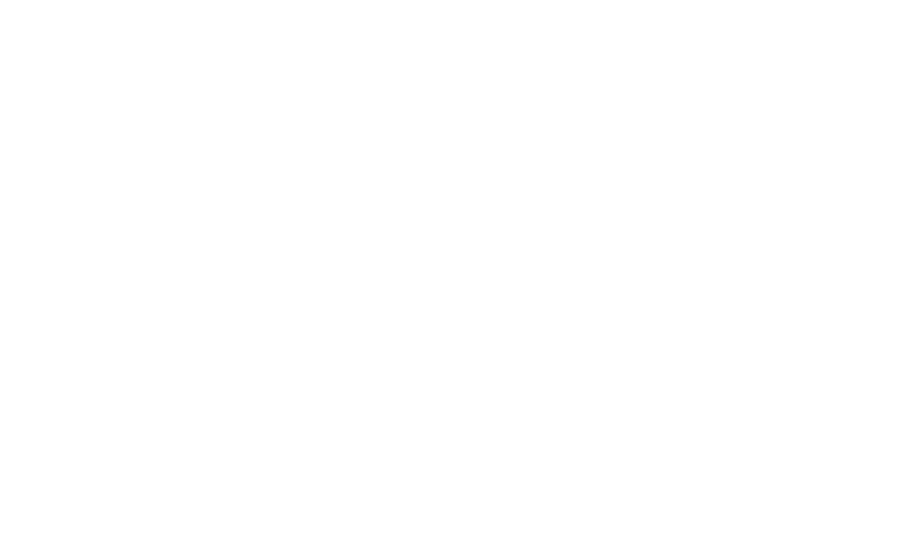

in
[-1.46246965e-02  8.98879203e-03 -2.52694907e-02 -1.29043319e-01
 -1.26541739e-02 -3.83702662e-03  7.09580067e-03  9.09483492e-04
  8.56926261e-03  2.43779489e-03  7.57476874e-03  4.87355480e-03
  1.69450825e-01 -1.99210755e-02  4.66726459e-02 -4.63440943e-03
 -1.03168477e-02 -2.42130765e-02 -2.91557669e-01  6.54232496e-03
  1.43360248e-02 -3.78845106e-03 -1.22493962e+00  1.92201986e-02
 -3.26328635e-03 -4.18885480e-04  9.51719085e-03  6.85467850e-03
 -1.01651519e-01  7.09315847e-03  2.14509500e-02  1.99835522e-02
  6.59804787e-03  2.12730301e-02 -2.07862021e-02 -1.18623088e-02
  1.56575351e-02  1.08909589e-02  4.87734024e-02  1.78257040e-02
  8.65821089e-03]
i:00 mean:0.006542(0.032129) stdev:0.205727(0.022719) Nchanged:0 Nused:41 Nskipped:0
i:01 mean:-0.004665(0.009880) stdev:0.062486(0.006986) Nchanged:1 Nused:40 Nskipped:1
i:02 mean:0.002691(0.006713) stdev:0.041925(0.004747) Nchanged:1 Nused:39 Nskipped:2
i:03 mean:0.001745(0.003972) stdev:0.024160(0.002809) Nchanged:2 Nused:37

<IPython.core.display.Javascript object>


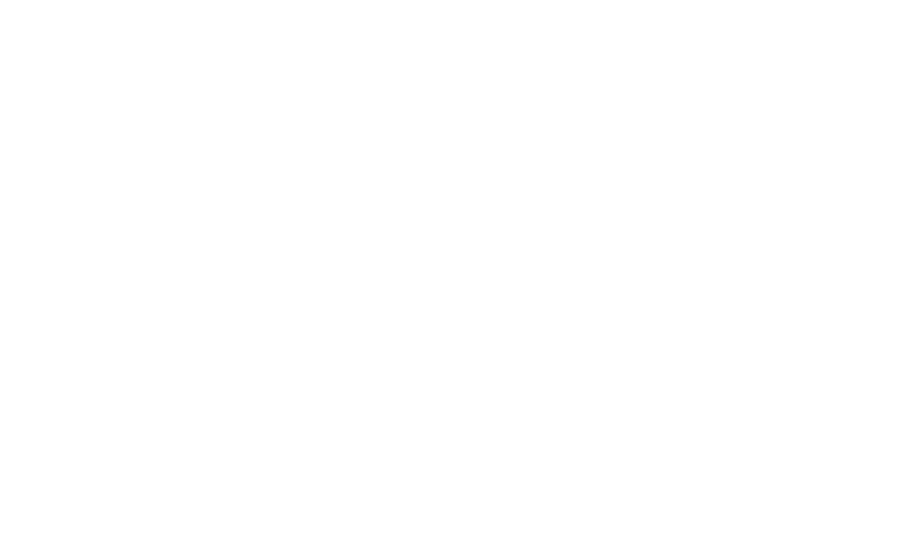

<IPython.core.display.Javascript object>


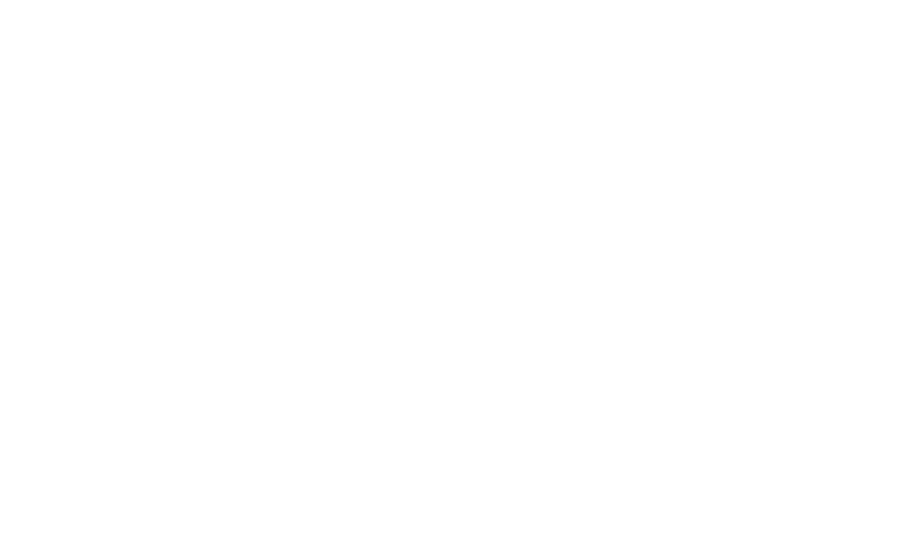

in
[-0.00397114 -0.01516816 -0.46218828 -0.02414128  0.00133456 -0.00603421
 -0.14287496 -0.00694402  0.0299656  -0.00416623 -0.0102412   0.00410129
 -0.01210245  0.01095498 -0.02174782  0.00857018  0.02407869  0.0047221
  0.01838035  0.00470258 -0.00854041  0.01548152 -0.01358504  0.0105133
 -0.02181191 -0.00886446  0.01315797 -0.00739579 -0.00391966 -0.0081855
  0.05056357  0.03686332  0.02589577]
i:00 mean:-0.003971(0.015200) stdev:0.087316(0.010748) Nchanged:0 Nused:33 Nskipped:0
i:01 mean:-0.001888(0.005552) stdev:0.031405(0.003926) Nchanged:1 Nused:32 Nskipped:1
i:02 mean:0.002660(0.003234) stdev:0.018006(0.002287) Nchanged:1 Nused:31 Nskipped:2
i:03 mean:0.002660(0.003234) stdev:0.018006(0.002287) Nchanged:0 Nused:31 Nskipped:2


<IPython.core.display.Javascript object>


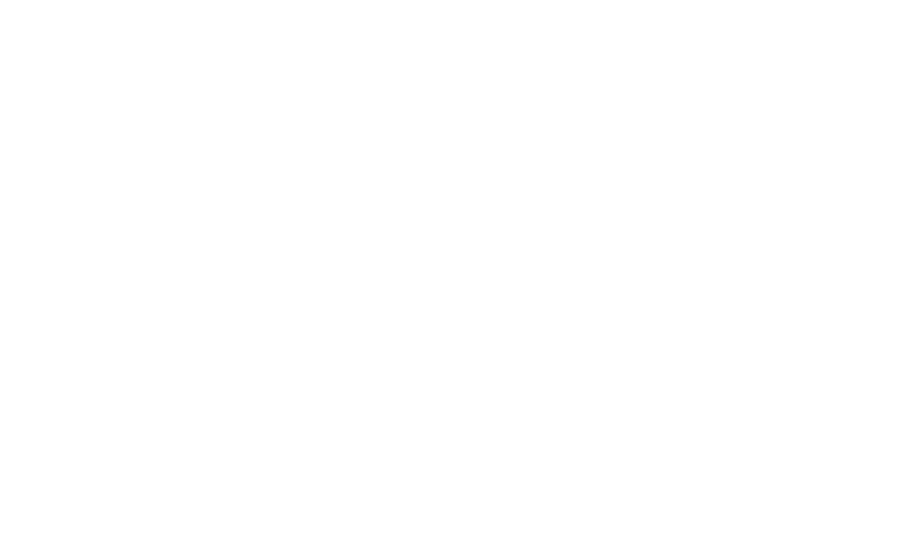

<IPython.core.display.Javascript object>


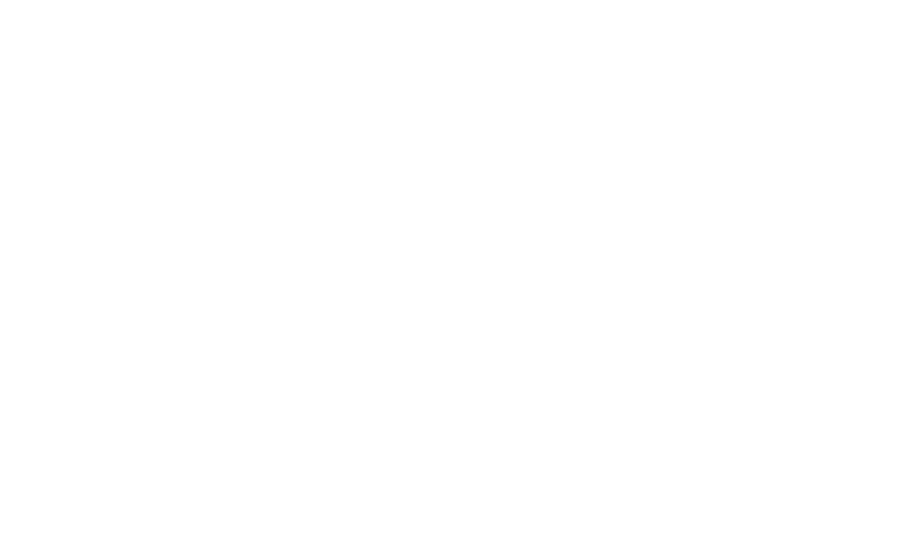

in
[-0.02508512 -0.00585833  0.0124822  -0.01607111 -0.02323066  0.00323746
  0.01478184 -0.0266872  -0.02069156  0.02302343  0.01010754  0.00110645
 -0.00510768 -0.00688964 -0.01307481 -0.01793515  0.02884574  0.01770296
 -0.00346805 -0.01926617  0.00861994]
i:00 mean:-0.005108(0.003727) stdev:0.017078(0.002635) Nchanged:0 Nused:21 Nskipped:0
i:01 mean:-0.003022(0.003697) stdev:0.016940(0.002614) Nchanged:0 Nused:21 Nskipped:0


<IPython.core.display.Javascript object>


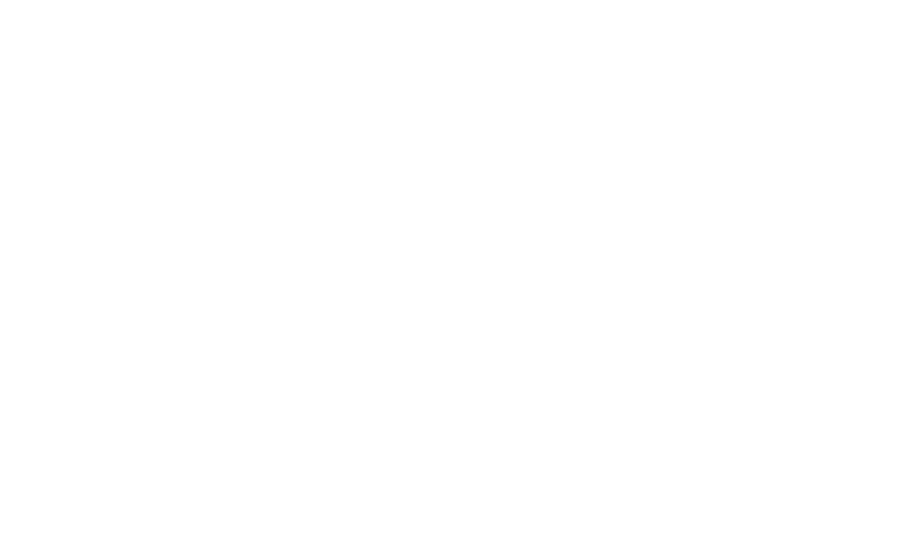

<IPython.core.display.Javascript object>


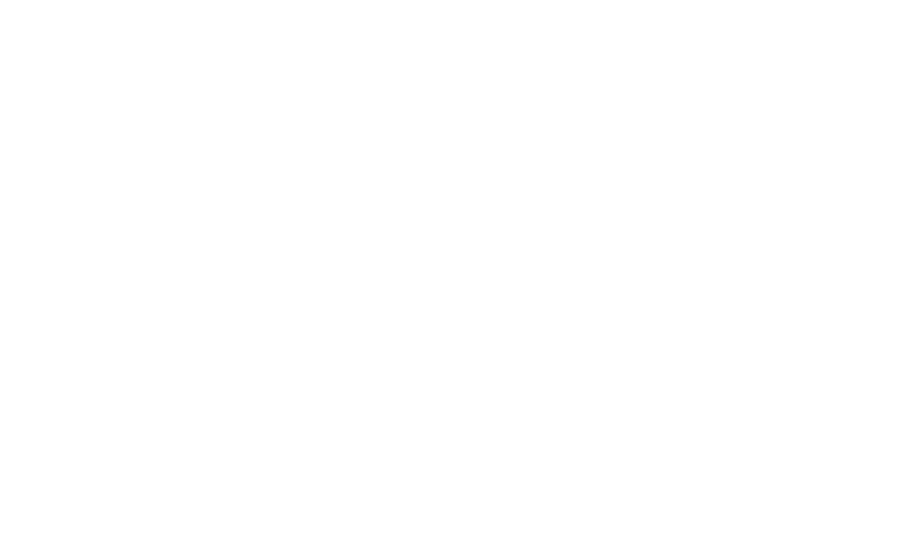

in
[-0.00424531 -0.00507364 -0.01001615 -0.01522432 -0.0089936  -0.01182097
  0.00665687 -0.01465521 -0.00595543 -0.04781077  0.00952161  0.00473048
 -0.01833294  0.00640524 -0.00612835 -0.01485416 -0.00415511 -0.02738272
  0.01224548  0.00569919  0.01217342 -0.00554657  0.00727941 -0.07416653
 -0.22640163  0.00784095  0.00252608 -0.00156948  0.01176656  0.0062877
  0.02944303  0.03098468 -0.00802874 -0.00703071  0.00647559  0.00360601
  0.00371118  0.00619712  0.00505607 -0.00890387]
i:00 mean:-0.002862(0.006376) stdev:0.040323(0.004508) Nchanged:0 Nused:40 Nskipped:0
i:01 mean:-0.003110(0.002939) stdev:0.018352(0.002078) Nchanged:1 Nused:39 Nskipped:1
i:02 mean:-0.001240(0.002317) stdev:0.014285(0.001639) Nchanged:1 Nused:38 Nskipped:2
i:03 mean:0.000019(0.001994) stdev:0.012128(0.001410) Nchanged:1 Nused:37 Nskipped:3
i:04 mean:0.000019(0.001994) stdev:0.012128(0.001410) Nchanged:0 Nused:37 Nskipped:3


<IPython.core.display.Javascript object>


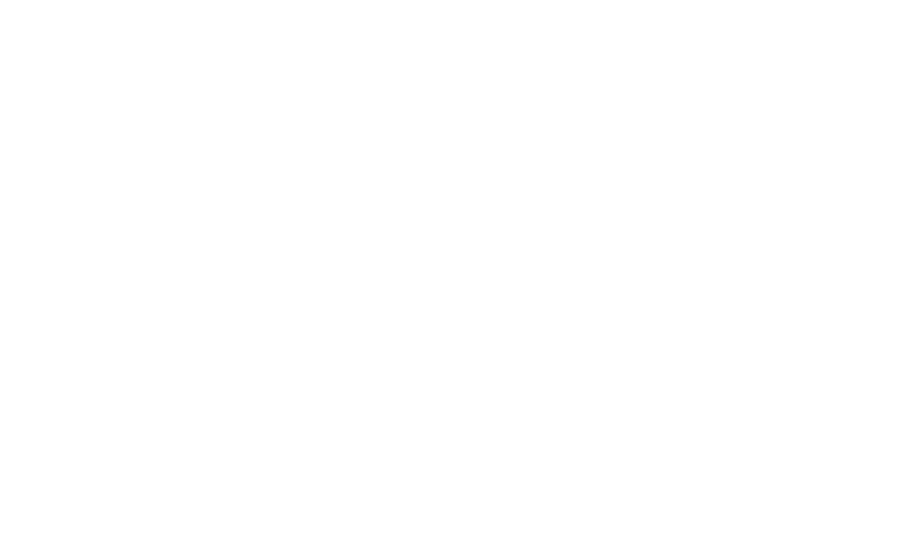

<IPython.core.display.Javascript object>


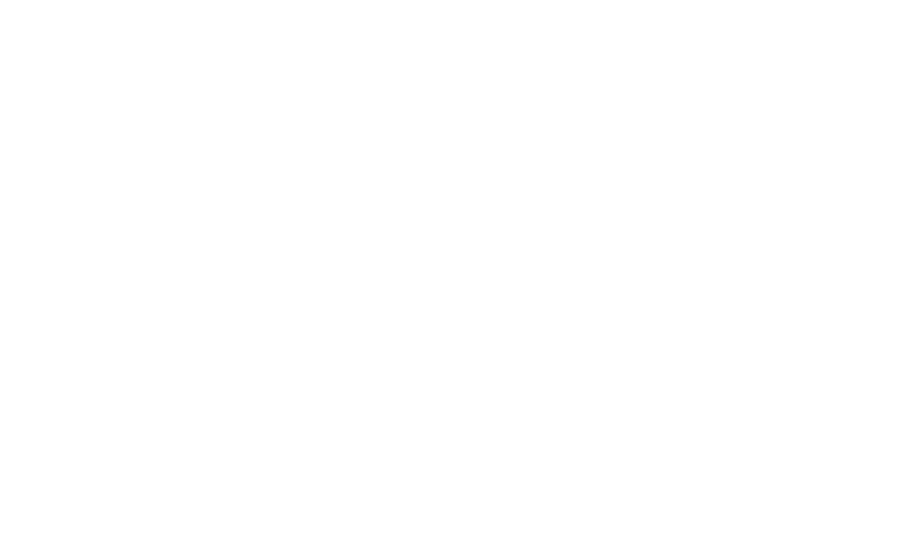

in
[-0.02804804 -0.01331449 -0.02068438 -0.04606614 -0.02421532  0.00929118
 -0.02275758 -0.0057877  -0.00750036 -0.04500546 -0.01373214  0.00764075
 -0.15193941 -0.00967229 -0.01018193  0.0134924  -0.01153042 -0.02998107
 -0.04013946  0.00473081  0.0099999   0.01457211  0.01271455  0.02025646
  0.00374396 -0.02864773  0.03265412  0.00565787 -0.00092913  0.03087526
  0.0299104  -0.02090533  0.04316115  0.03082623  0.01496847  0.0069305
 -0.02244567  0.02077082  0.06430687  0.02405606]
i:00 mean:0.001407(0.005556) stdev:0.035140(0.003929) Nchanged:0 Nused:40 Nskipped:0
i:01 mean:-0.000025(0.004046) stdev:0.025270(0.002861) Nchanged:1 Nused:39 Nskipped:1
i:02 mean:-0.000025(0.004046) stdev:0.025270(0.002861) Nchanged:0 Nused:39 Nskipped:1


<IPython.core.display.Javascript object>


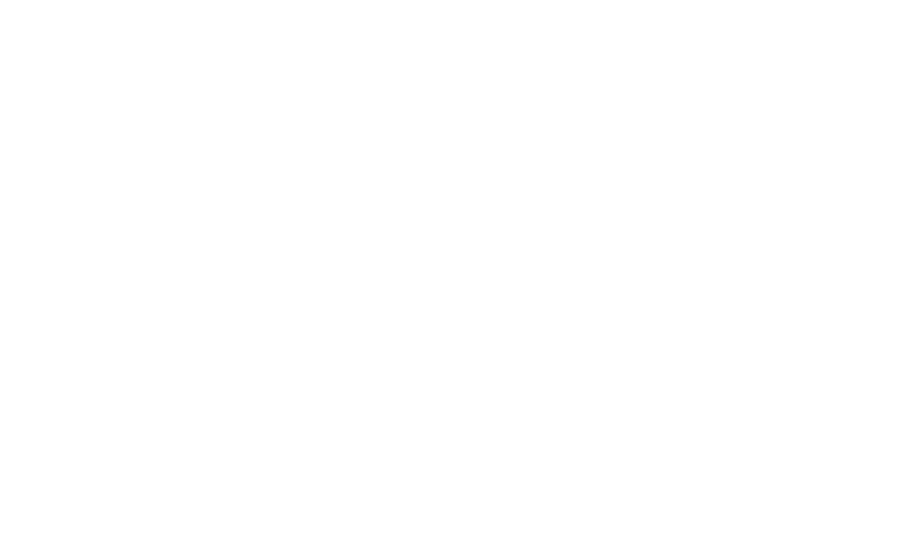

<IPython.core.display.Javascript object>


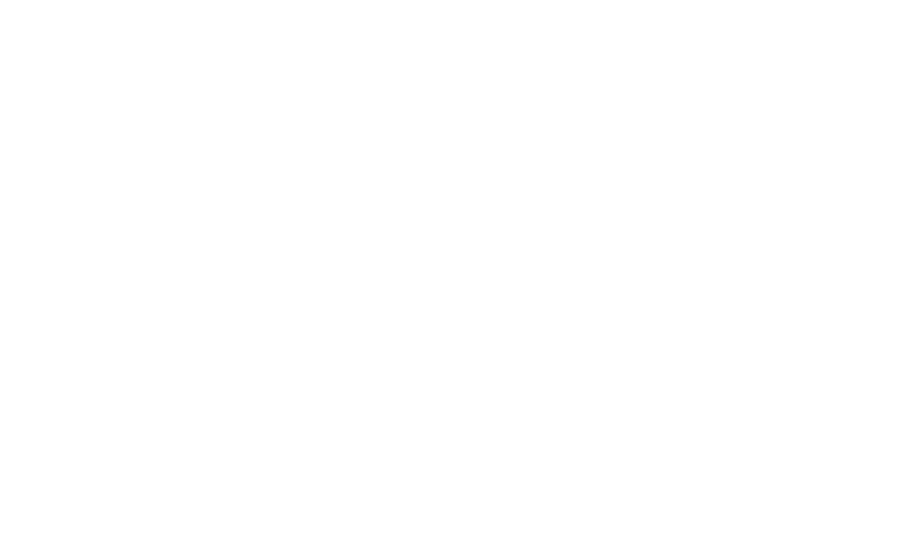

in
[-2.38201411e-02 -3.29786587e-01  9.05805907e-03 -2.42770994e-02
 -2.30186848e-02 -5.12421907e-03  2.39217465e-03  4.27858483e-01
 -5.15054893e-03  2.38008414e-01 -1.18787514e-02  2.34192169e-02
 -1.92526765e-02 -5.98672310e-03  1.80865047e-02 -1.92431268e-03
 -6.22600012e-02  2.03210857e-02  2.68459226e-02  8.19384098e-03
  2.34402793e-03  7.42680459e-03  4.31524199e-02 -7.81415952e-02
  3.67373484e-04 -6.22602312e-03  1.20256276e-02 -1.32668851e-02
 -1.92448782e-02 -1.19315632e-01  3.28805932e-02 -2.35570837e-02]
i:00 mean:-0.003524(0.019796) stdev:0.111984(0.013998) Nchanged:0 Nused:32 Nskipped:0
i:01 mean:-0.010571(0.014598) stdev:0.081277(0.010322) Nchanged:1 Nused:31 Nskipped:1
i:02 mean:-0.008136(0.006238) stdev:0.033595(0.004411) Nchanged:2 Nused:29 Nskipped:3
i:03 mean:-0.004165(0.004958) stdev:0.026233(0.003506) Nchanged:1 Nused:28 Nskipped:4
i:04 mean:-0.004165(0.004958) stdev:0.026233(0.003506) Nchanged:0 Nused:28 Nskipped:4


<IPython.core.display.Javascript object>


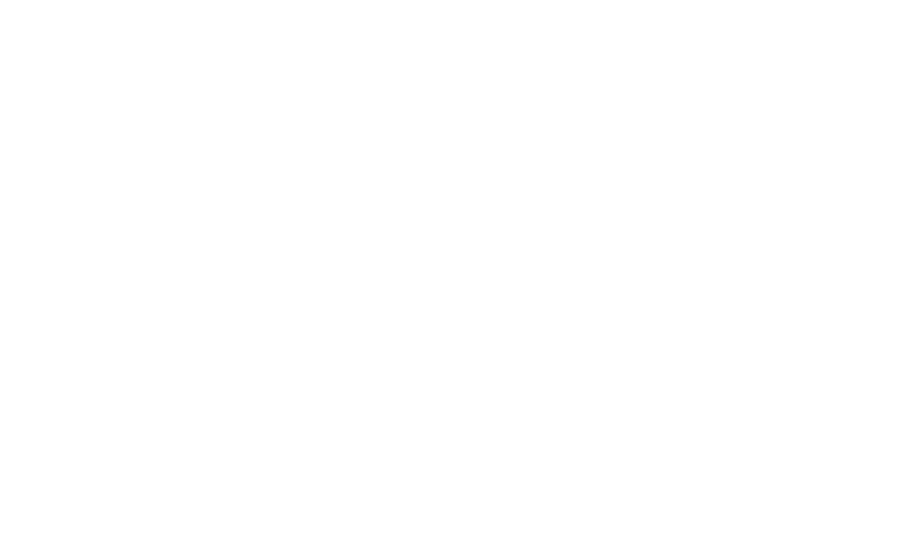

<IPython.core.display.Javascript object>


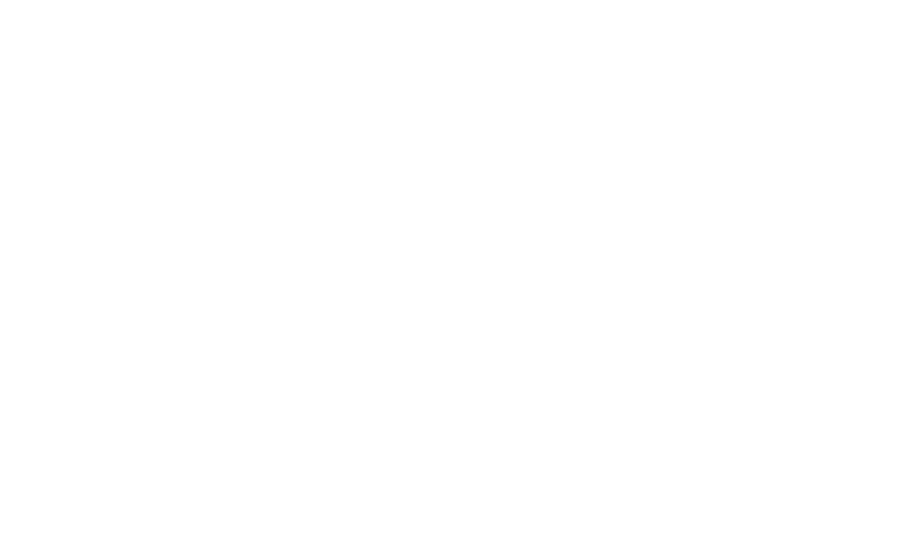

in
[ 0.00336256  0.00513785 -0.02457083  0.00834399 -0.0044475  -0.0071912
 -0.15406073 -0.02579449 -0.00326241  0.03914746  0.01979885 -0.00879996
 -0.36209959 -0.00460029 -0.03937489 -0.02172555  0.03141104 -0.00468685
 -0.04177223  0.01302991  0.02509908 -0.00497603 -0.00432577 -0.00457842
 -0.00756392  0.01182603  0.02374888  0.01705518  0.01142523  0.00570533
  0.00156898 -0.01099426]
i:00 mean:-0.004387(0.012858) stdev:0.072736(0.009092) Nchanged:0 Nused:32 Nskipped:0
i:01 mean:-0.005034(0.006044) stdev:0.033650(0.004274) Nchanged:1 Nused:31 Nskipped:1
i:02 mean:-0.000067(0.003497) stdev:0.019156(0.002473) Nchanged:1 Nused:30 Nskipped:2
i:03 mean:-0.000067(0.003497) stdev:0.019156(0.002473) Nchanged:0 Nused:30 Nskipped:2


<IPython.core.display.Javascript object>


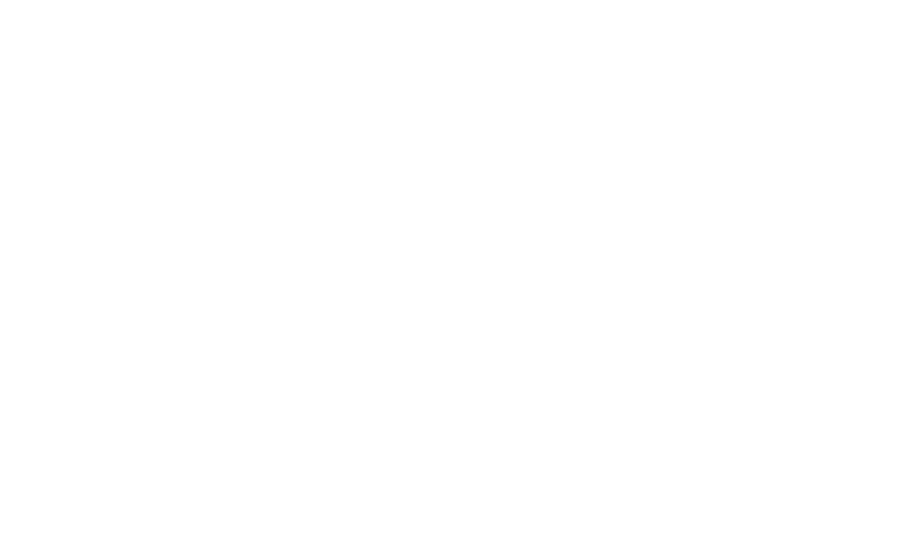

<IPython.core.display.Javascript object>


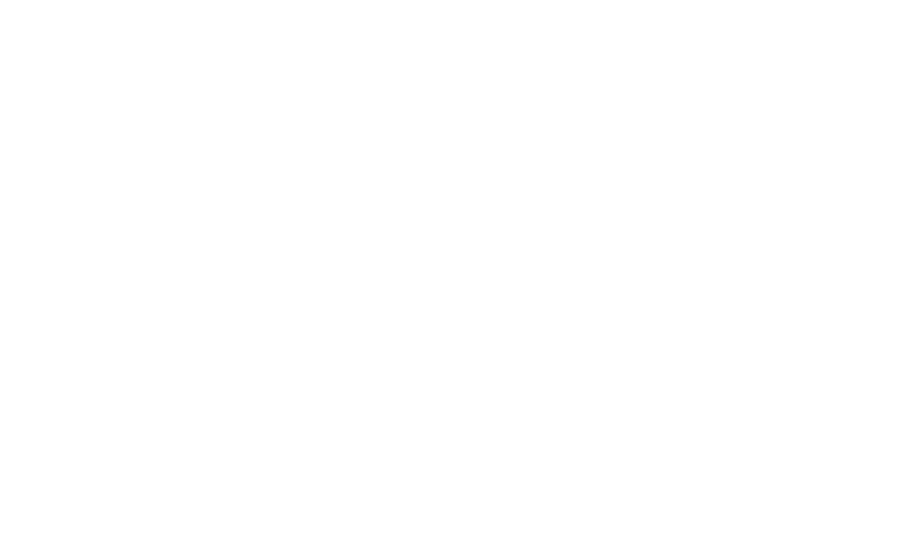

in
[-0.01951545  0.00696998  0.01317537  0.00555063 -0.0083543  -0.0039137
 -0.03778853  0.0041312   0.0040585  -0.03077861  0.04183005 -0.02858128
 -0.00375985 -0.0157017   0.01671685  0.02649541  0.02267732  0.00346998
  0.00205975 -0.71503314 -0.02229784  0.009567   -0.20934315  0.00745769
 -0.00287617 -0.00336455 -0.01430628  0.00519397 -0.03947807  0.07217473
 -0.00668946  0.0084014   0.00872793  0.03684282  0.02365487 -0.02841821
 -0.12983191  0.00374182]
i:00 mean:0.002765(0.020725) stdev:0.127759(0.014655) Nchanged:0 Nused:38 Nskipped:0
i:01 mean:-0.007624(0.007636) stdev:0.046446(0.005399) Nchanged:1 Nused:37 Nskipped:1
i:02 mean:-0.002021(0.005291) stdev:0.031744(0.003741) Nchanged:1 Nused:36 Nskipped:2
i:03 mean:0.001631(0.003914) stdev:0.023158(0.002768) Nchanged:1 Nused:35 Nskipped:3
i:04 mean:-0.000444(0.003409) stdev:0.019879(0.002411) Nchanged:1 Nused:34 Nskipped:4
i:05 mean:-0.000444(0.003409) stdev:0.019879(0.002411) Nchanged:0 Nused:34 Nskipped:4


<IPython.core.display.Javascript object>


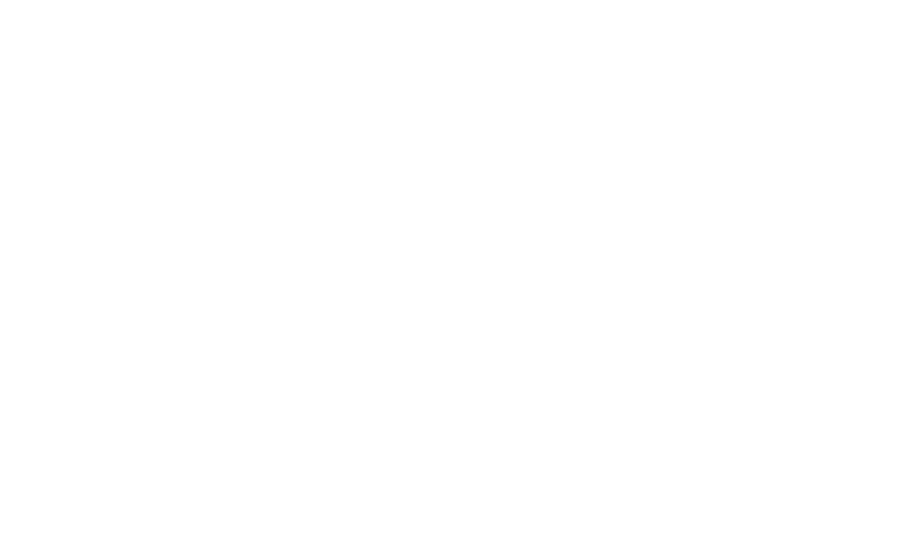

<IPython.core.display.Javascript object>


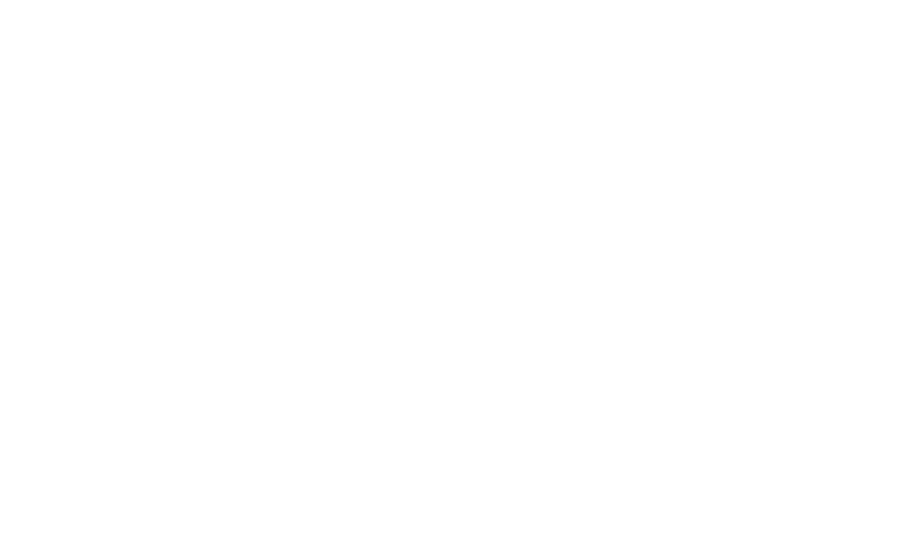

in
[ 0.00976315  0.02541116  0.00556827  0.0325744   0.04215944  0.03661975
 -0.01566237  0.01170157 -0.00580125  0.01774234 -1.38754966  0.00993635
 -0.01491047 -0.00810586 -0.00609115  0.01189321  0.01539472 -0.03396379
  0.00644639 -0.0046012  -0.02462572  0.03854175 -0.00928934  0.0026115
  0.00699424 -0.06620367  0.04620861 -0.01619215  0.01669246 -0.00255798
 -0.00346792  0.00996103 -0.1767931 ]
i:00 mean:0.005568(0.043758) stdev:0.251368(0.030941) Nchanged:0 Nused:33 Nskipped:0
i:01 mean:-0.001314(0.007035) stdev:0.039797(0.004975) Nchanged:1 Nused:32 Nskipped:1
i:02 mean:0.004347(0.004251) stdev:0.023667(0.003006) Nchanged:1 Nused:31 Nskipped:2
i:03 mean:0.004347(0.004251) stdev:0.023667(0.003006) Nchanged:0 Nused:31 Nskipped:2


<IPython.core.display.Javascript object>


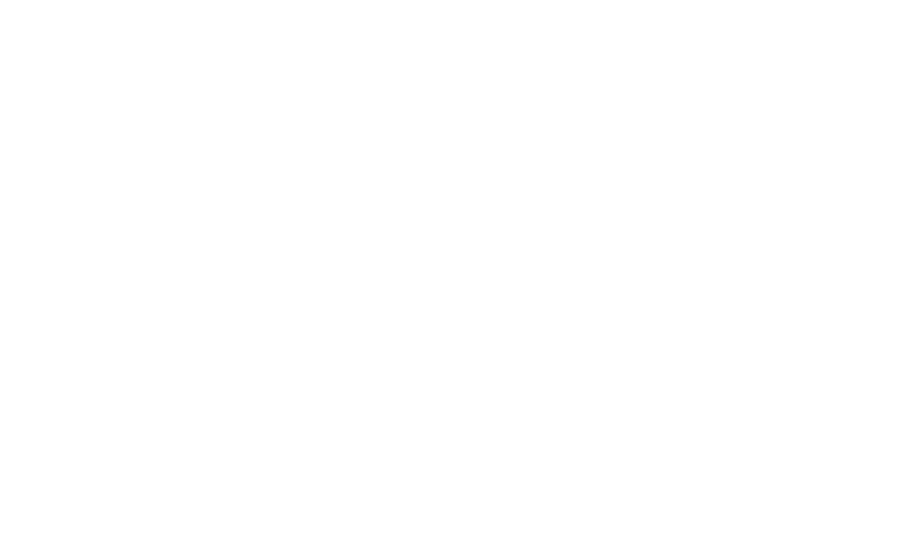

<IPython.core.display.Javascript object>


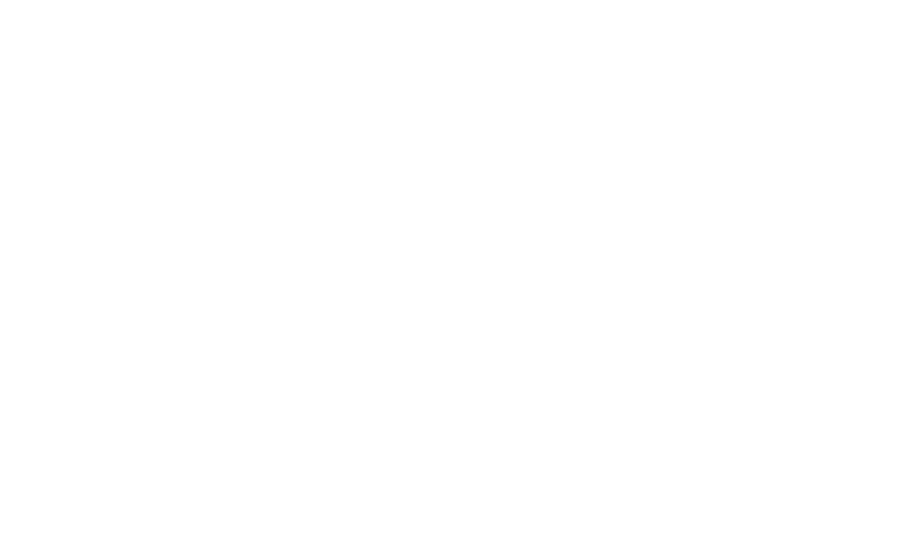

in
[ 1.23506555e-02  6.21386026e-03  1.22044977e-03  1.19399493e-02
  1.26017364e-02  1.50168236e-02 -6.69760090e-02  1.78667170e-03
  1.79119850e-02  5.16793760e-03 -4.90975603e-03 -1.85661179e-03
 -6.76846302e-05  9.75535563e-03  6.02921009e-03 -1.08212907e-02
  2.69578607e-02  1.08705960e-02 -1.04975079e-01 -4.26168648e-02
 -1.80978182e-02  1.63302158e-02 -3.32731204e-02 -1.79690298e-02
 -2.49266082e-02  8.91031784e-03 -1.49133789e-02]
i:00 mean:0.001787(0.005802) stdev:0.030150(0.004103) Nchanged:0 Nused:27 Nskipped:0
i:01 mean:-0.002822(0.004199) stdev:0.021411(0.002969) Nchanged:1 Nused:26 Nskipped:1
i:02 mean:-0.002822(0.004199) stdev:0.021411(0.002969) Nchanged:0 Nused:26 Nskipped:1


<IPython.core.display.Javascript object>


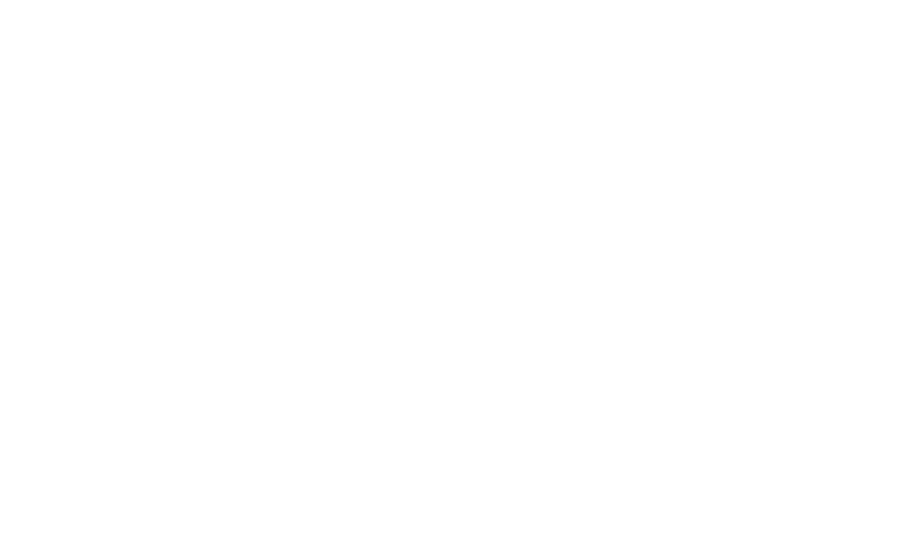

<IPython.core.display.Javascript object>


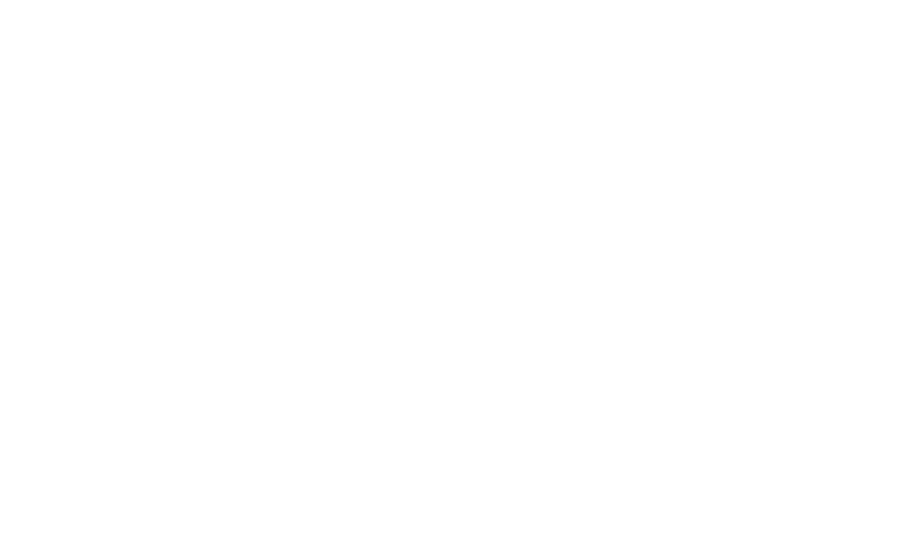

in
[-4.35018049e-03 -4.93466184e-03 -1.73075556e-01  1.35909871e-02
 -3.91281608e-03  1.25646323e-02  6.83956397e-03 -1.09024285e-01
  2.11341193e-02 -1.26291488e-01 -5.07303824e-03  1.53698542e-03
 -6.81466389e-03  2.23072787e-02  1.32477915e-02 -6.98635604e-03
 -3.13015175e-01 -4.22426234e-02  1.49754565e-02 -8.76192261e-03
  6.56882459e-03  6.79272713e-03  1.00827691e-02 -2.16074640e+00
  8.28239570e-03  1.42638841e-02 -2.74361102e-02  1.10933085e-02
 -1.13976634e-02  2.54642197e-02 -3.58041457e-01  3.61541934e-02
  6.04866442e-03]
i:00 mean:0.001537(0.069140) stdev:0.397177(0.048889) Nchanged:0 Nused:33 Nskipped:0
i:01 mean:-0.030325(0.016376) stdev:0.092637(0.011580) Nchanged:1 Nused:32 Nskipped:1
i:02 mean:-0.009978(0.008518) stdev:0.046654(0.006023) Nchanged:2 Nused:30 Nskipped:3
i:03 mean:-0.004354(0.006579) stdev:0.035429(0.004652) Nchanged:1 Nused:29 Nskipped:4
i:04 mean:0.000000(0.005076) stdev:0.026861(0.003589) Nchanged:1 Nused:28 Nskipped:5
i:05 mean:0.004038(0.003142) st

<IPython.core.display.Javascript object>


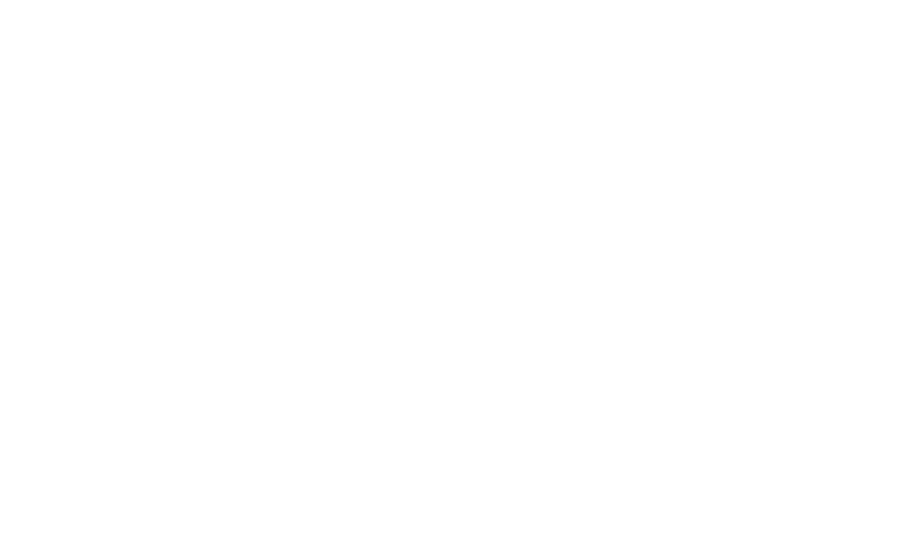

<IPython.core.display.Javascript object>


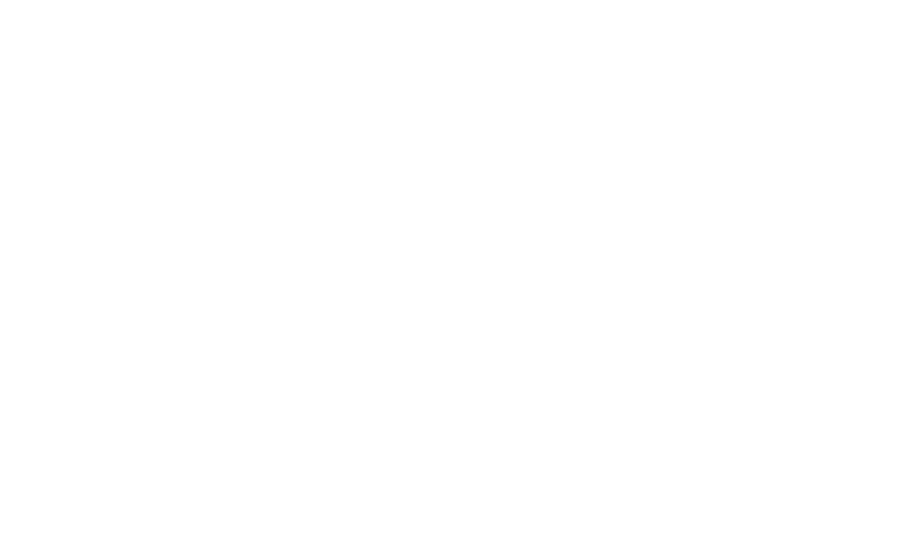

in
[-0.11321038  0.10394841  0.00973729  0.01934165 -0.01520337 -0.00421177
  0.01175209 -0.18732009  0.0205419   0.00918097 -0.02167318  0.01376987
  0.00826512  0.0228215  -0.6402728  -0.01223702 -0.08422076  0.00165774
  0.01438012 -0.02573066 -0.00518359  0.01039228 -0.00777603 -0.00584613
  0.00517989  0.01223551 -0.02528642 -0.01103565  0.00554282  0.00545924
 -0.01719344 -0.03028196  0.00655719 -0.01350221  0.00340856 -0.0220129
  0.00885641 -0.05370923 -0.29536412]
i:00 mean:-0.004212(0.019611) stdev:0.122470(0.013867) Nchanged:0 Nused:39 Nskipped:0
i:01 mean:-0.017315(0.010448) stdev:0.064403(0.007388) Nchanged:1 Nused:38 Nskipped:1
i:02 mean:-0.009800(0.007404) stdev:0.045035(0.005235) Nchanged:1 Nused:37 Nskipped:2
i:03 mean:-0.004869(0.005648) stdev:0.033886(0.003993) Nchanged:1 Nused:36 Nskipped:3
i:04 mean:-0.004883(0.003810) stdev:0.022214(0.002694) Nchanged:2 Nused:34 Nskipped:5
i:05 mean:-0.002479(0.003031) stdev:0.017415(0.002144) Nchanged:1 Nused:33 Nskipped:6
i:06 m

<IPython.core.display.Javascript object>


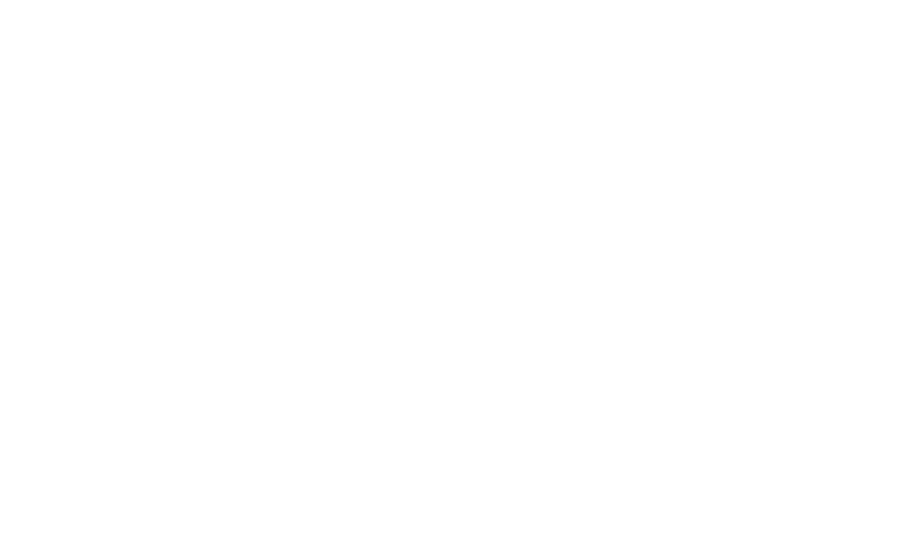

<IPython.core.display.Javascript object>


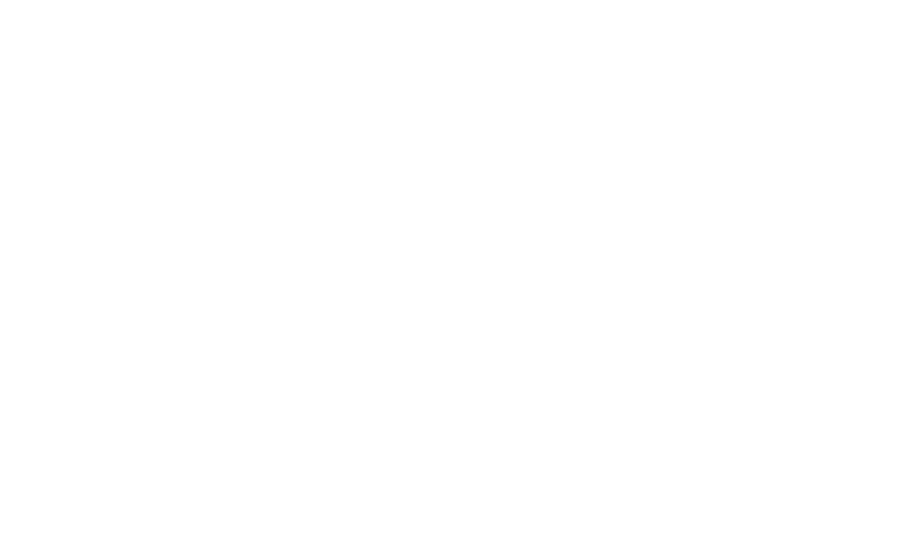

in
[ 0.03913096 -0.00761562  0.02592175 -0.00810274 -1.420269   -0.01252013
  0.04436027 -0.1837202  -0.00373305  0.00182803  0.01143798  0.0260518
 -0.00471003  0.03309873 -1.03794882  0.01187046 -0.02404826  0.03567079
  0.00830745 -0.00324548 -0.00540179 -0.01571695 -0.02925914  0.04904119
 -0.01995882  0.00814716  0.00389239  0.0036276   0.00498638 -0.29050851
 -0.03259124 -0.00798677  0.00727878  0.00695686 -0.02213193 -0.00390496
  0.01640158]
i:00 mean:-0.003245(0.049428) stdev:0.300661(0.034951) Nchanged:0 Nused:37 Nskipped:0
i:01 mean:-0.009633(0.010506) stdev:0.062153(0.007429) Nchanged:2 Nused:35 Nskipped:2
i:02 mean:-0.001372(0.006605) stdev:0.038514(0.004670) Nchanged:1 Nused:34 Nskipped:3
i:03 mean:0.004154(0.003664) stdev:0.021046(0.002591) Nchanged:1 Nused:33 Nskipped:4
i:04 mean:0.004154(0.003664) stdev:0.021046(0.002591) Nchanged:0 Nused:33 Nskipped:4


<IPython.core.display.Javascript object>


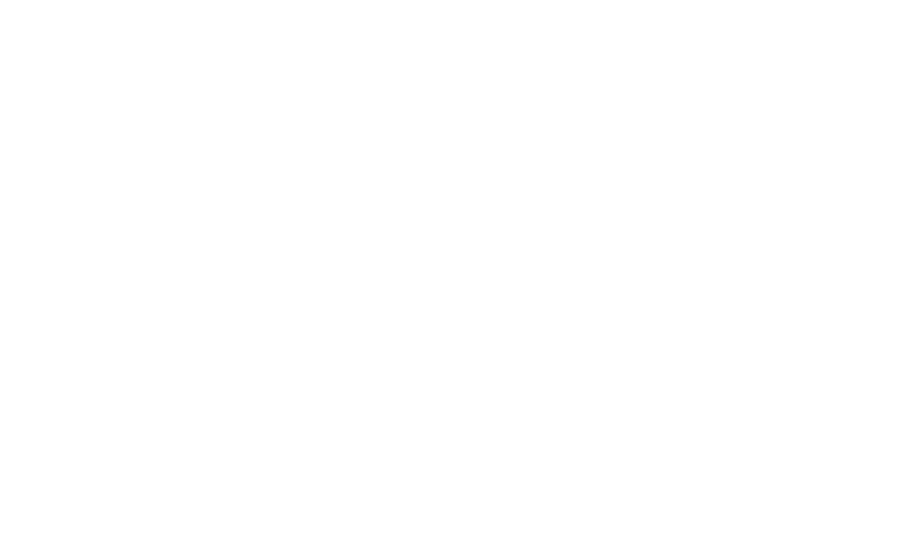

<IPython.core.display.Javascript object>


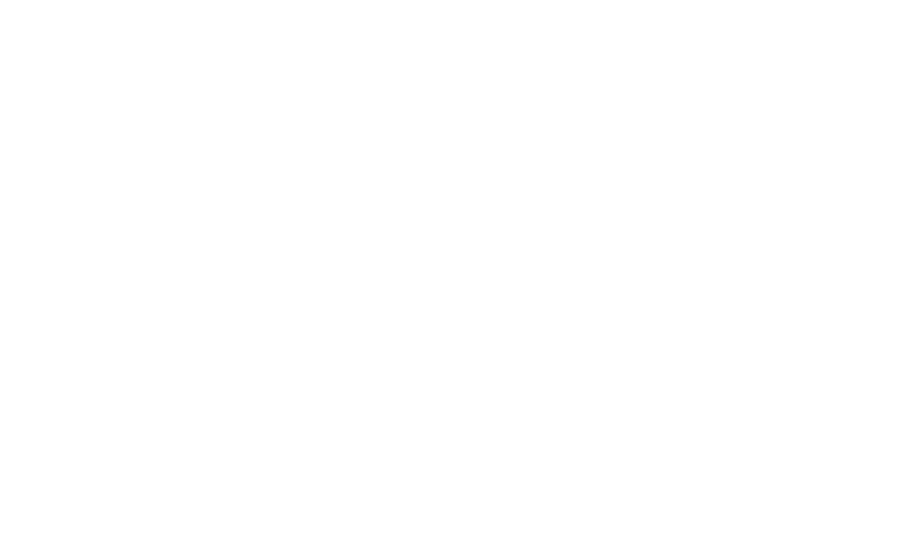

in
[ 0.00965654  0.00655567  0.01615738  0.01237262  0.01962998 -0.01958998
 -0.01640928  0.0013562  -0.00460967  0.01027192 -0.00370202  0.00649665
  0.02133374 -0.01534731 -0.01199592  0.01633847 -0.01383911  0.00438132
  0.01299661  0.0044371   0.01840973  0.00428775 -0.01138801 -0.00973609
 -0.00702673 -0.07852324 -0.11784441 -0.09708727 -0.02716493  0.0062178
  0.03360143 -0.01865751]
i:00 mean:0.002822(0.006181) stdev:0.034966(0.004371) Nchanged:0 Nused:32 Nskipped:0
i:01 mean:-0.004212(0.004815) stdev:0.026806(0.003404) Nchanged:1 Nused:31 Nskipped:1
i:02 mean:-0.001116(0.003791) stdev:0.020762(0.002680) Nchanged:1 Nused:30 Nskipped:2
i:03 mean:0.001553(0.002763) stdev:0.014879(0.001954) Nchanged:1 Nused:29 Nskipped:3
i:04 mean:0.001553(0.002763) stdev:0.014879(0.001954) Nchanged:0 Nused:29 Nskipped:3


<IPython.core.display.Javascript object>


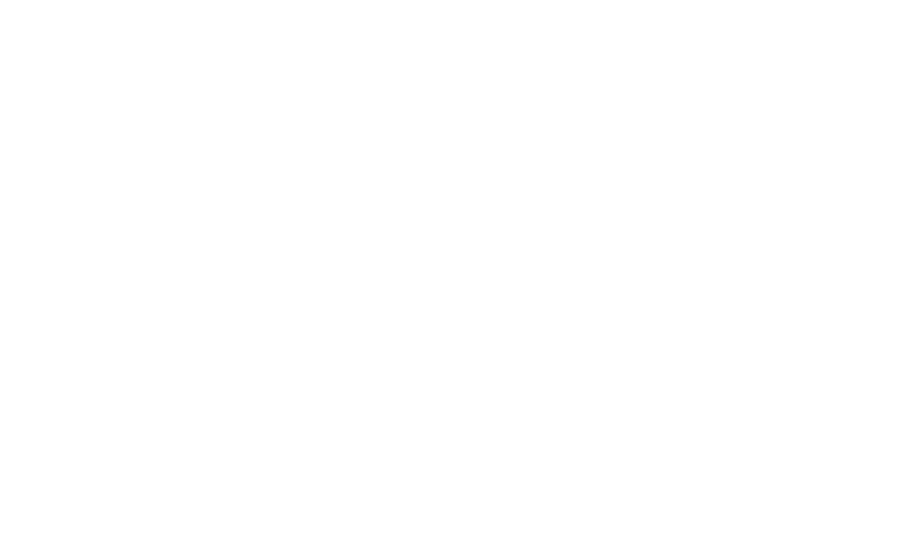

<IPython.core.display.Javascript object>


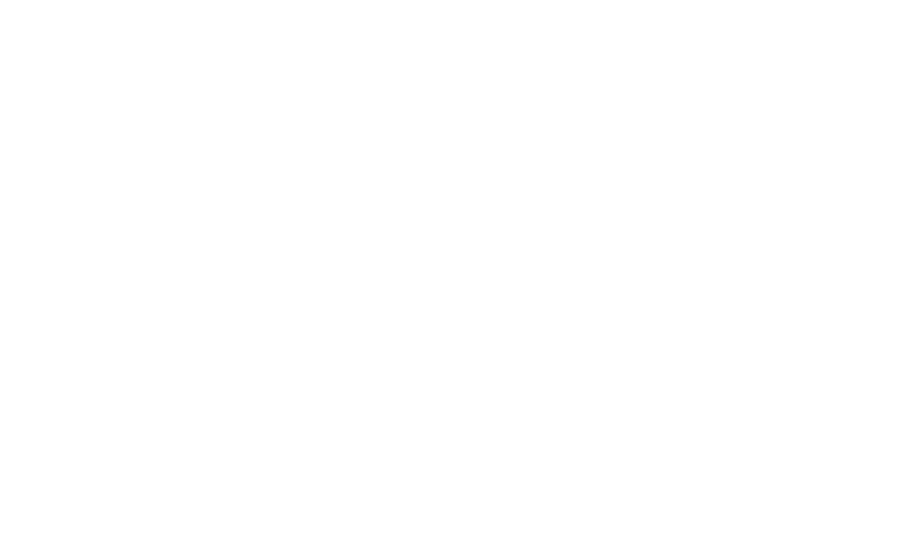

in
[-4.23187080e-03  4.33414643e-02 -2.01380189e-01 -1.45951836e-02
  1.39963908e-02 -1.48801066e-02  3.17902028e-02 -1.75252460e-02
 -3.50687380e-03  1.85865581e-02 -1.18526170e-02 -3.47361658e-02
  1.42874575e-02  2.60634056e-03 -4.55165016e-07 -7.96345681e-03
 -2.19134394e-02  1.28232555e-02 -8.74321872e-03  7.83903049e-03
 -7.10574787e-03 -1.54210254e-02  4.11069440e-03 -1.19085500e-01
  1.12605583e-02 -1.40211220e-03 -2.75324248e-03  6.72493673e-03
  4.66068340e-03  6.91485856e-03  1.47302790e-02  1.31924746e-02]
i:00 mean:-0.000701(0.007964) stdev:0.045051(0.005631) Nchanged:0 Nused:32 Nskipped:0
i:01 mean:-0.002544(0.004852) stdev:0.027016(0.003431) Nchanged:1 Nused:31 Nskipped:1
i:02 mean:0.001341(0.002961) stdev:0.016220(0.002094) Nchanged:1 Nused:30 Nskipped:2
i:03 mean:0.001341(0.002961) stdev:0.016220(0.002094) Nchanged:0 Nused:30 Nskipped:2


<IPython.core.display.Javascript object>


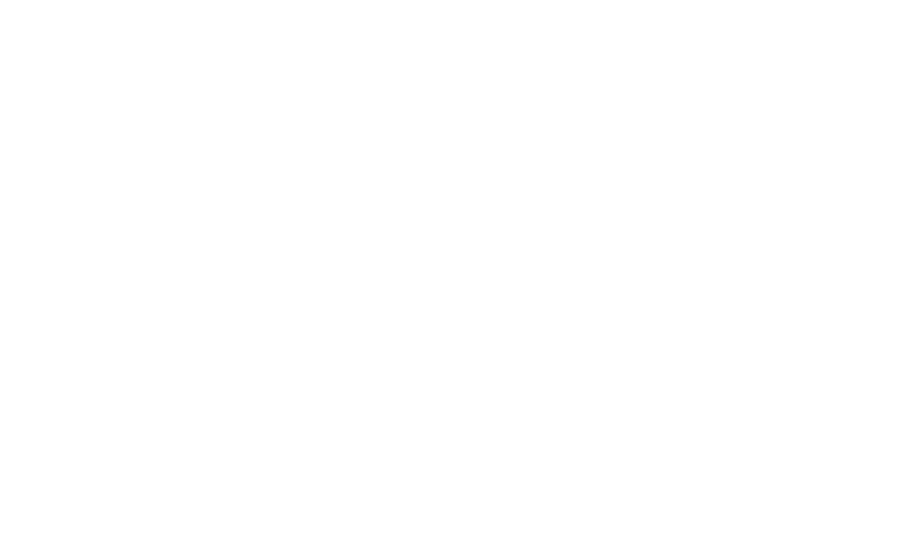

<IPython.core.display.Javascript object>


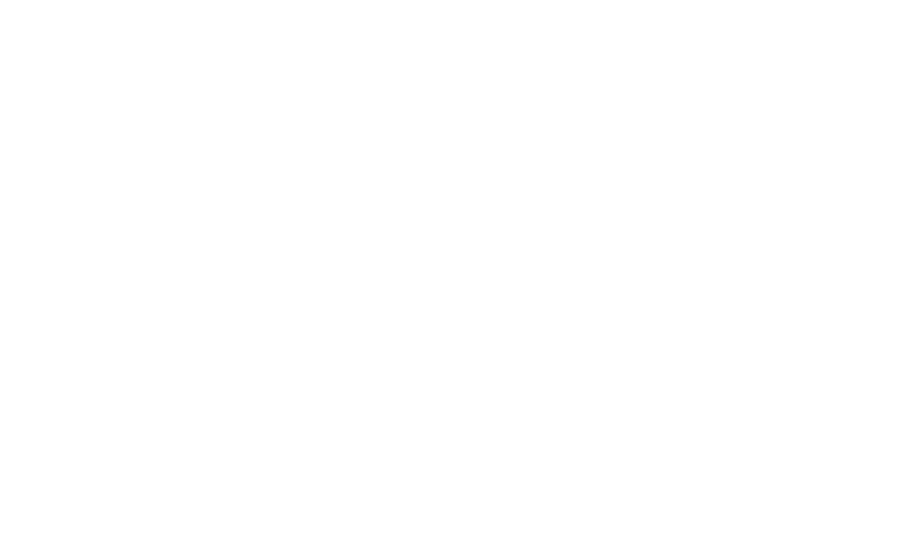

in
[-8.46946128e-03  6.12209702e-03 -1.89540151e-02 -8.56497016e-03
  1.02618424e-02 -4.35306243e-02 -1.04406154e-02  5.62652159e-04
 -6.69869225e-03 -1.08443247e-02  2.05640319e-02  8.64243978e-03
  3.60689314e-03  2.10560486e-02  1.35009654e-02 -1.84695636e-02
 -8.48886444e-01 -4.08618260e-02  1.95471264e-02  3.52098688e-02
  2.37592056e-02  8.84384044e-03 -1.28375768e-02 -1.12175431e-03
  7.36807381e-03  1.02483624e-02  5.19952971e-03 -3.90414627e-03
 -2.28558302e-02  3.56461793e-03 -1.30690074e-02 -7.30867055e-03
 -1.12295132e-02  7.62876890e-03]
i:00 mean:-0.000280(0.025695) stdev:0.149827(0.018169) Nchanged:0 Nused:34 Nskipped:0
i:01 mean:-0.001014(0.003023) stdev:0.017368(0.002138) Nchanged:1 Nused:33 Nskipped:1
i:02 mean:-0.001014(0.003023) stdev:0.017368(0.002138) Nchanged:0 Nused:33 Nskipped:1


<IPython.core.display.Javascript object>


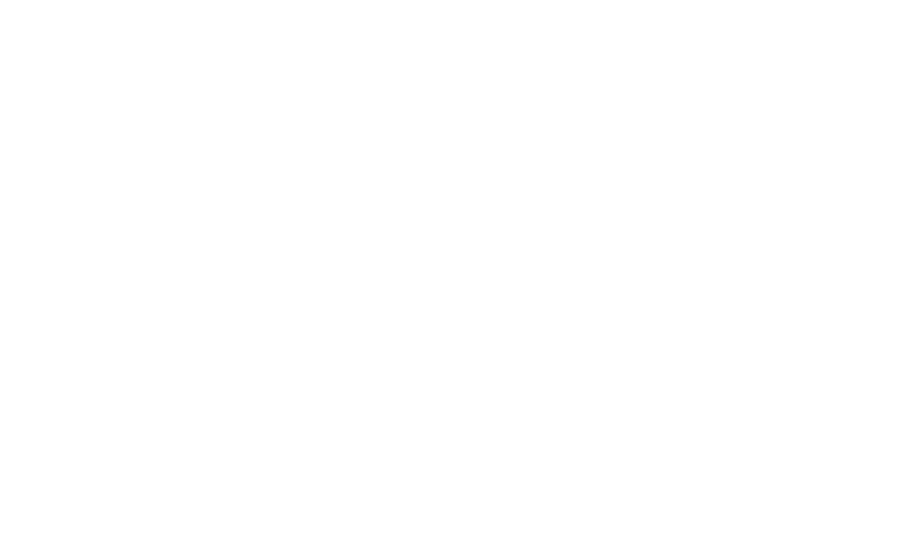

<IPython.core.display.Javascript object>


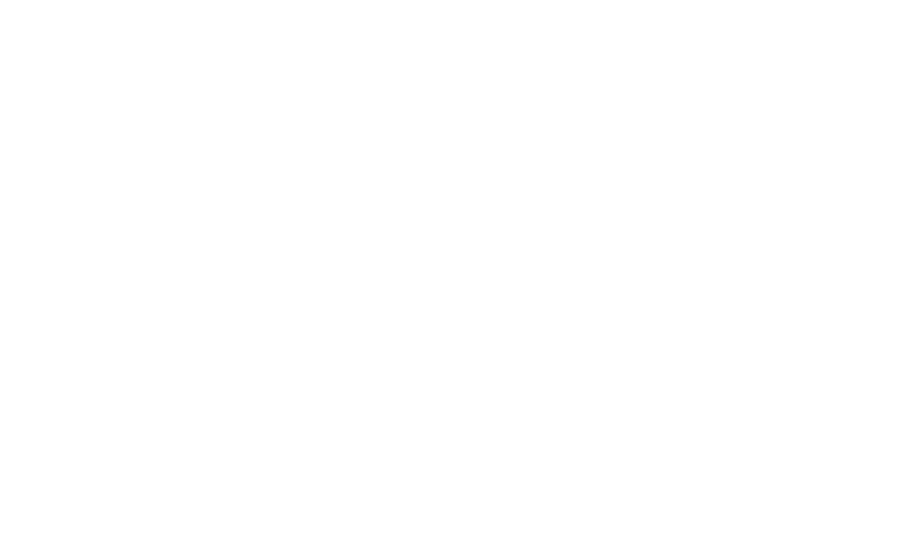

in
[ 5.01742505e-03  1.45993699e-02 -1.23427250e-02 -4.38025110e-03
  6.49664169e-03 -1.50310681e-02 -2.61140724e-03  3.38064048e-02
  7.57067208e-03 -8.27939765e-03  1.15744244e-02  8.67582031e-03
 -1.25222553e-02 -6.82714754e-03  1.19856124e-02 -2.02521202e-02
 -2.95279584e-02 -6.97441437e-03  4.39474811e-02 -4.22762385e-02
 -1.35439213e-02 -4.36284843e-03  1.41646741e-02 -4.94141905e-03
  7.80806312e-03 -1.36737238e-02  1.91033915e-02  1.60494732e-02
 -1.13654006e-02  1.62868251e-02  1.54130024e-02 -2.30822814e-02
 -3.10686837e-03 -5.38263092e+00 -1.03065474e-02]
i:00 mean:-0.004363(0.157088) stdev:0.929343(0.111078) Nchanged:0 Nused:35 Nskipped:0
i:01 mean:-0.000380(0.003028) stdev:0.017656(0.002141) Nchanged:1 Nused:34 Nskipped:1
i:02 mean:-0.000380(0.003028) stdev:0.017656(0.002141) Nchanged:0 Nused:34 Nskipped:1


<IPython.core.display.Javascript object>


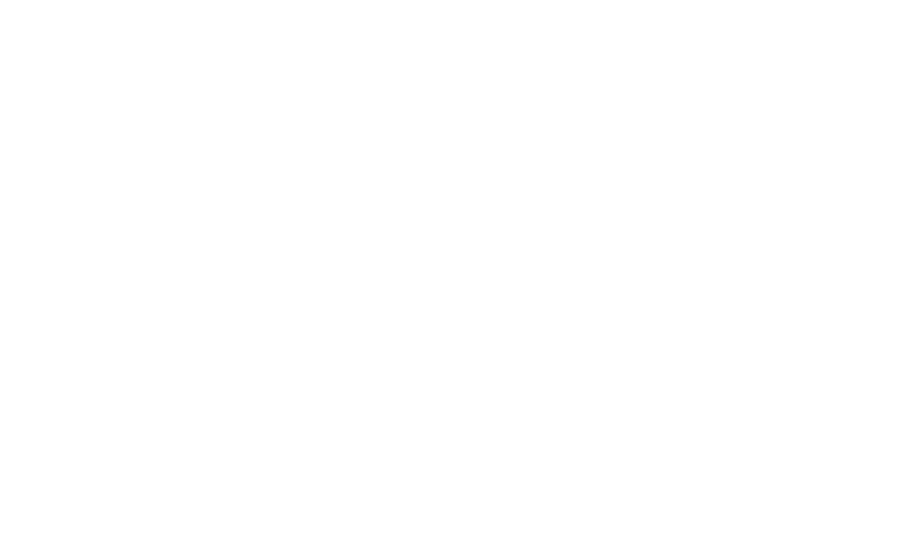

<IPython.core.display.Javascript object>


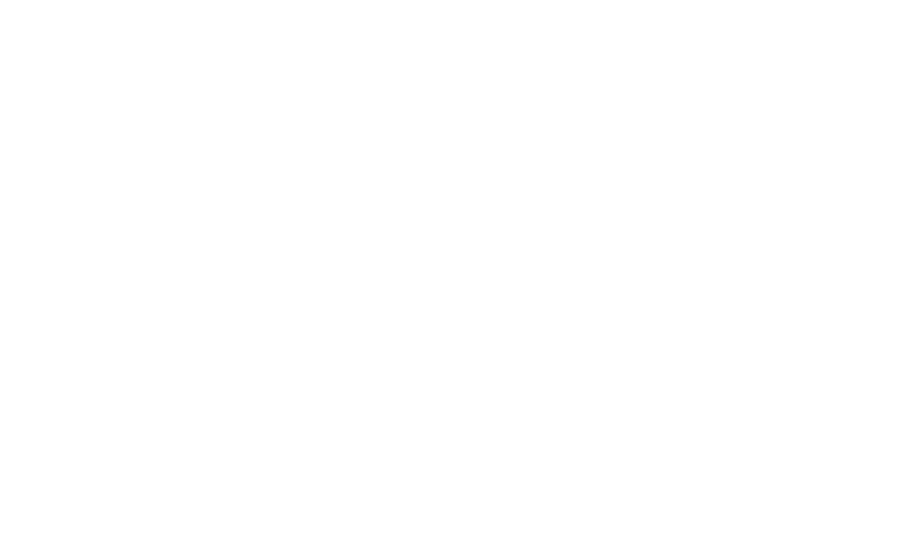

in
[-7.83405626e-03  1.55851177e-02 -1.41166280e-02 -4.66389237e-02
  2.86395106e-02 -1.34161532e-02  3.49294602e-03 -2.16587053e-02
  1.07812254e-02 -5.28660297e-03  2.46155592e-02 -2.18321211e-02
 -1.77693028e-02 -7.00642187e-03 -5.62542125e-03 -1.69853502e-06
 -1.16612499e-02  1.34783956e-02  1.77067983e-02  2.14749599e-02
  1.22508742e-02 -4.44548185e-03  2.63333212e-03 -7.30278412e-02
  2.44000280e-02  8.73902867e-03  1.03077155e-02 -5.06067069e-01
  9.90053646e-03  1.06974769e-02 -1.36372713e-01 -4.66353543e-03
  9.15523218e-03  3.41691743e-02 -2.01587483e-02  1.87597122e-02]
i:00 mean:0.001316(0.015329) stdev:0.091971(0.010839) Nchanged:0 Nused:36 Nskipped:0
i:01 mean:-0.003849(0.005344) stdev:0.031615(0.003779) Nchanged:1 Nused:35 Nskipped:1
i:02 mean:0.000048(0.003734) stdev:0.021772(0.002640) Nchanged:1 Nused:34 Nskipped:2
i:03 mean:0.002263(0.003087) stdev:0.017732(0.002183) Nchanged:1 Nused:33 Nskipped:3
i:04 mean:0.002263(0.003087) stdev:0.017732(0.002183) Nchanged:0 Nused

<IPython.core.display.Javascript object>


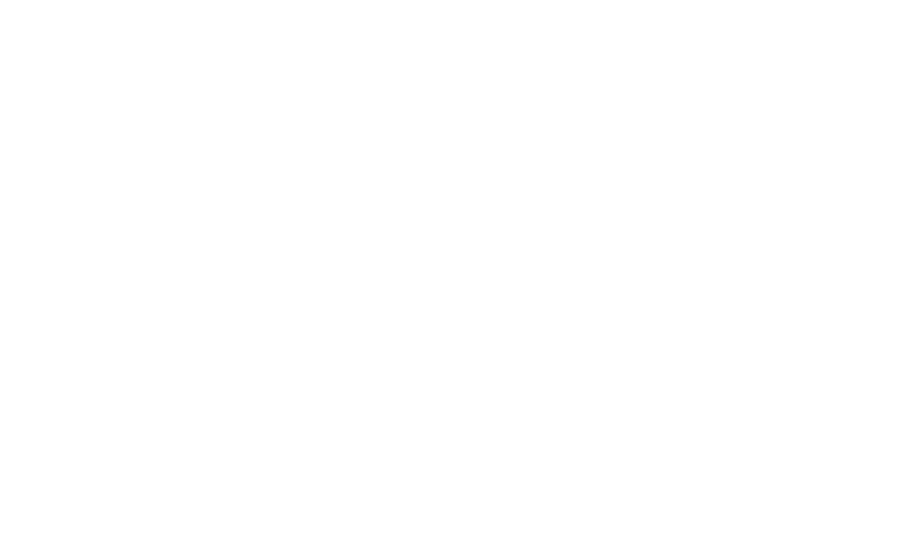

<IPython.core.display.Javascript object>


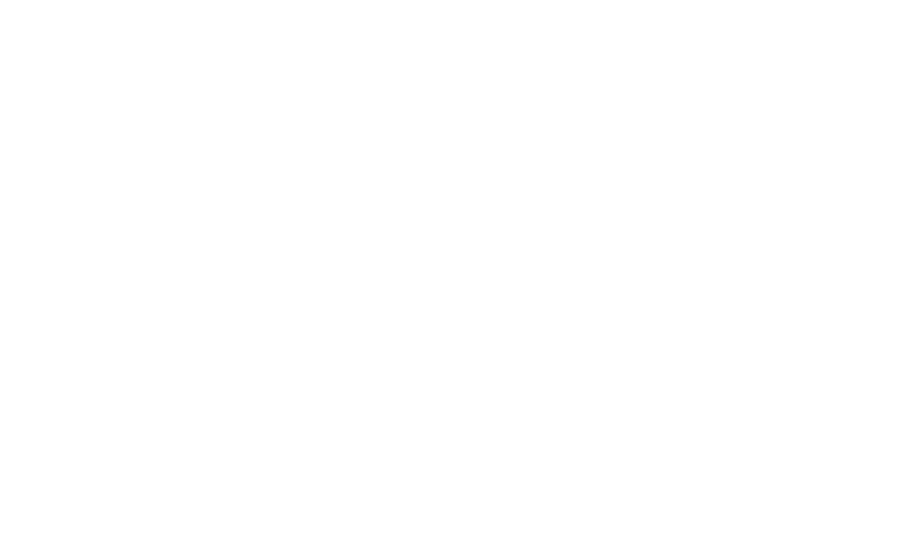

in
[ 0.03661272 -0.00412046 -0.1930552  -0.0126795   0.00430537  0.02368045
  0.01271652  0.00622758 -0.02166928  0.00906889 -0.01034973  0.00852113
 -0.0101419   0.01494846 -0.00405598  0.0116269  -0.00459617  0.00954077
 -0.00148467 -0.1138505   0.02005393 -0.00304001  0.00758786 -0.0017959
 -0.16194102 -0.01550123 -0.01484638 -0.02368085 -0.00298796 -0.02283529
 -0.00976338  0.03549075]
i:00 mean:-0.003014(0.009117) stdev:0.051576(0.006447) Nchanged:0 Nused:32 Nskipped:0
i:01 mean:-0.002567(0.004808) stdev:0.026333(0.003400) Nchanged:2 Nused:30 Nskipped:2
i:02 mean:0.001270(0.002953) stdev:0.015901(0.002088) Nchanged:1 Nused:29 Nskipped:3
i:03 mean:0.001270(0.002953) stdev:0.015901(0.002088) Nchanged:0 Nused:29 Nskipped:3


<IPython.core.display.Javascript object>


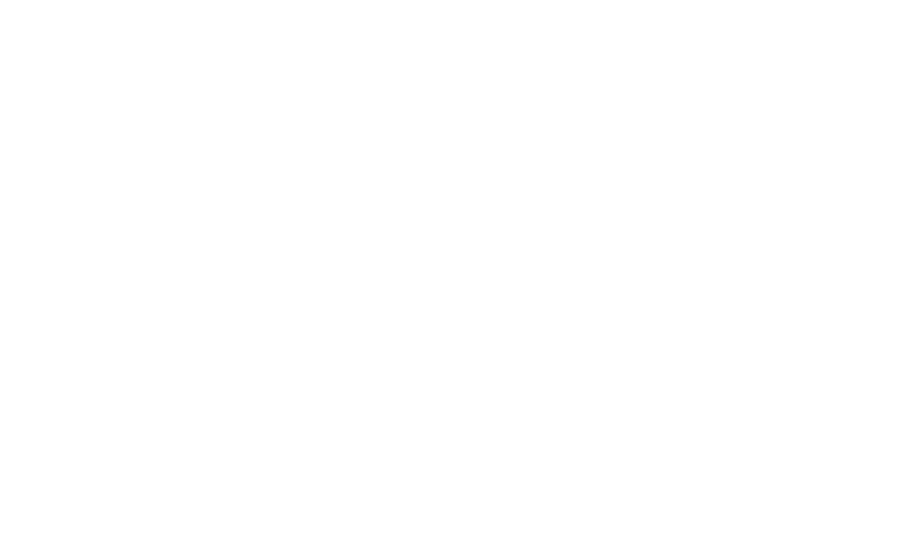

<IPython.core.display.Javascript object>


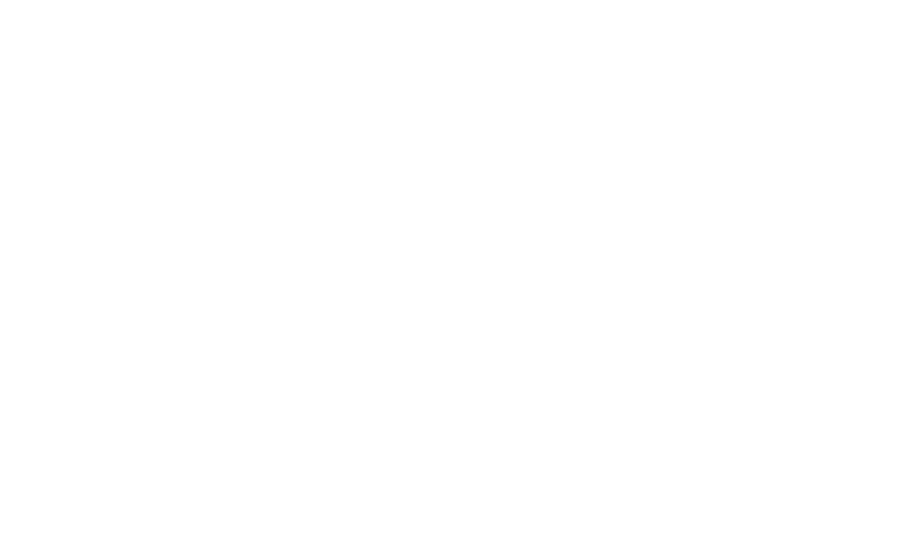

in
[ 0.00803225 -0.05869878 -0.00132814  0.03847056 -0.0219072  -0.00674865
  0.0132255  -0.0096486   0.03383685 -0.02179061  0.01331346 -0.0130161
 -0.01540958 -0.00854525  0.08055843 -0.08480631  0.01214276  0.00956029
  0.00702397 -0.01584636 -0.00260018  0.02048502 -0.02023476  0.00457514
  0.02503537 -0.10660339 -0.0069406   0.0081561  -0.00617319 -0.01294063
  0.03794671 -0.01011638  0.03188082  0.02516121 -0.06566427  0.03771281
  0.01703311 -0.00270705]
i:00 mean:-0.001964(0.005668) stdev:0.034937(0.004008) Nchanged:0 Nused:38 Nskipped:0
i:01 mean:-0.001778(0.005667) stdev:0.034936(0.004007) Nchanged:0 Nused:38 Nskipped:0


<IPython.core.display.Javascript object>


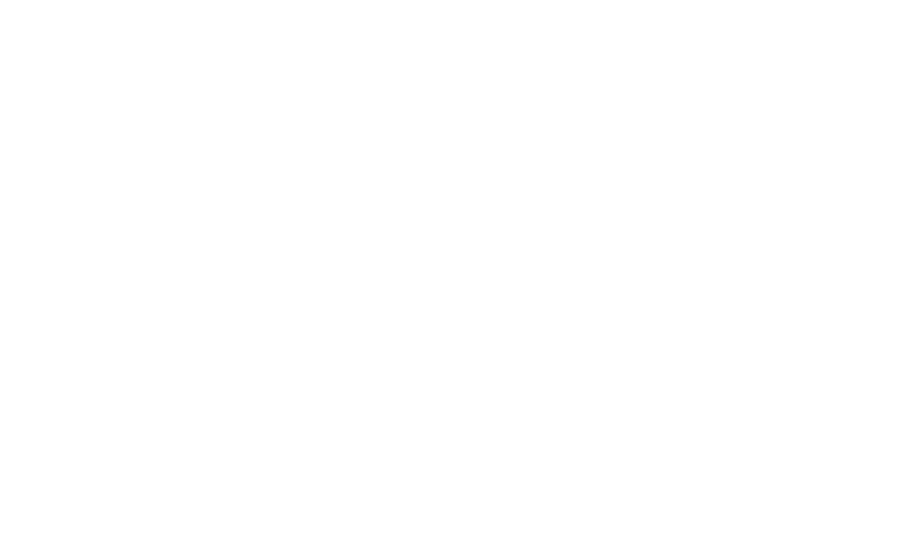

<IPython.core.display.Javascript object>


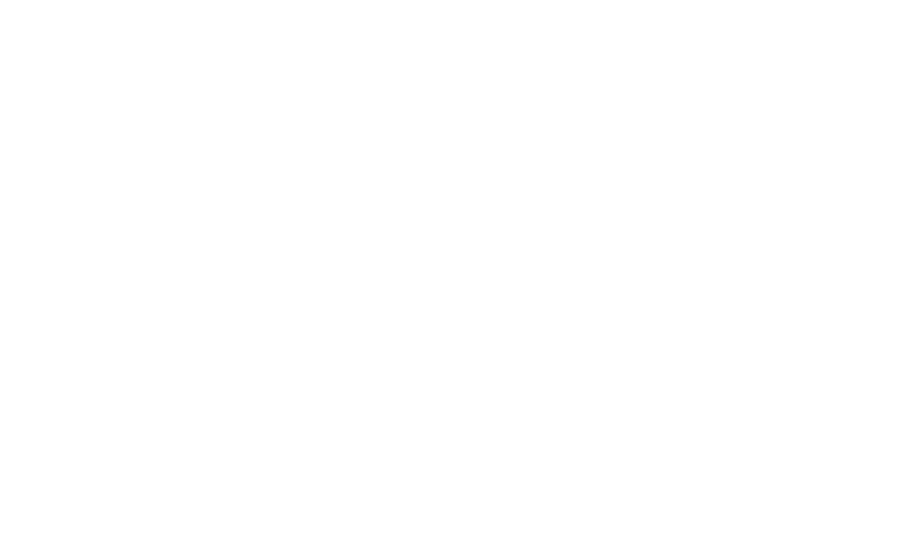

in
[-0.09995124 -0.14257818 -0.03050661 -0.01544496 -0.02127467 -0.00976858
 -0.02652301 -0.00370732 -0.05671084 -0.01325283  0.01101034 -0.02080355
  0.01436484 -0.02699857  0.00253554 -0.06308505  0.23288667 -0.01931368
  0.00944582  0.01135741  0.01134505 -0.44907316  0.04352085 -0.01969917
  0.0074993   0.00673017  0.00571778  0.0383167   0.03741117  0.03113116
  0.02709009  0.02574564  0.0370749   0.00521902]
i:00 mean:0.003877(0.016786) stdev:0.097876(0.011869) Nchanged:0 Nused:34 Nskipped:0
i:01 mean:-0.000340(0.010080) stdev:0.057903(0.007127) Nchanged:1 Nused:33 Nskipped:1
i:02 mean:-0.007628(0.007123) stdev:0.040295(0.005037) Nchanged:1 Nused:32 Nskipped:2
i:03 mean:-0.003275(0.005797) stdev:0.032274(0.004099) Nchanged:1 Nused:31 Nskipped:3
i:04 mean:-0.003275(0.005797) stdev:0.032274(0.004099) Nchanged:0 Nused:31 Nskipped:3


<IPython.core.display.Javascript object>


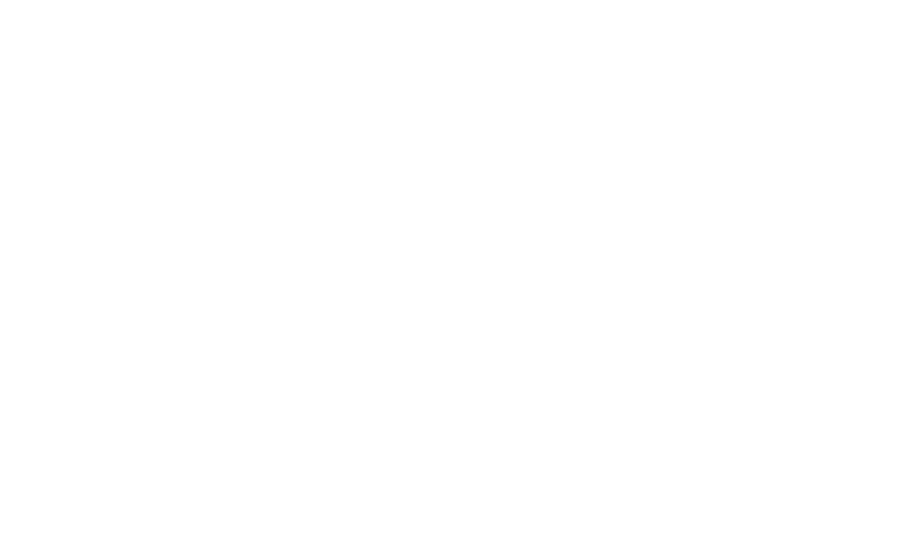

<IPython.core.display.Javascript object>


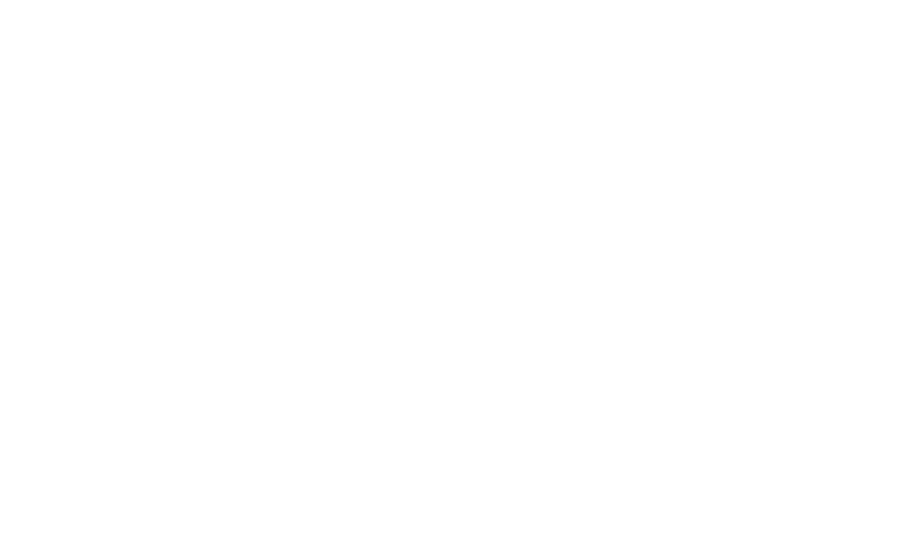

in
[-1.53989913e-01 -4.03855955e-02  4.33563117e-03 -4.18856991e-02
  5.22785721e-03 -3.48648791e-03  1.97809014e-02  1.11526687e-02
  8.60992745e-03  1.43061024e-02  4.10916890e-03 -4.28172175e-03
  3.54906076e-03  1.38604099e-02  9.64285764e-03  6.85748458e-03
  1.48417622e-02 -1.85063521e-02  1.27116418e-02 -1.13895243e-02
  2.12860443e-02 -1.21976103e-02  4.60454034e-03  2.25706979e-03
 -1.32452542e-01  1.27567523e-02 -1.12461419e-02 -6.80381694e-03
  1.31143714e-02 -2.47255630e-02 -7.27050309e-03 -2.78892221e-02
 -3.94525404e-01 -8.65564224e-03 -6.50189153e-01 -5.87922164e-02
 -1.11546976e+00 -4.31180778e-03 -8.19630431e-02  6.98596819e-03
 -4.93477179e-03 -5.36508334e-02  2.31661871e-02  8.31660536e-03
 -1.82882683e-02 -2.37798746e-02  6.00973308e-03 -1.93818994e-02
  8.62811717e-04  4.46433912e-03  4.04089653e-02  8.91054673e-03
  2.64429171e-03  4.04122737e-03  9.80218165e-03]
i:00 mean:0.002257(0.025418) stdev:0.188503(0.017973) Nchanged:0 Nused:55 Nskipped:0
i:01 mean:-0.0163

<IPython.core.display.Javascript object>


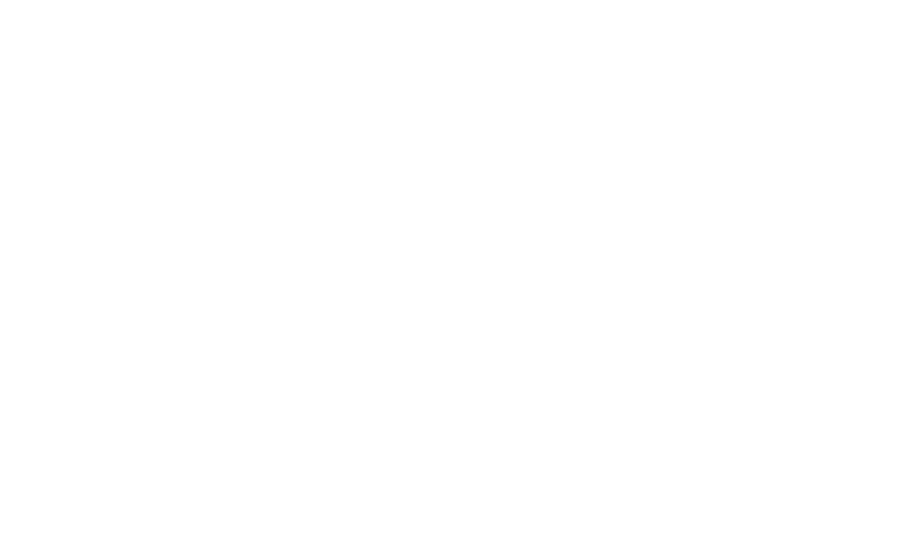

<IPython.core.display.Javascript object>


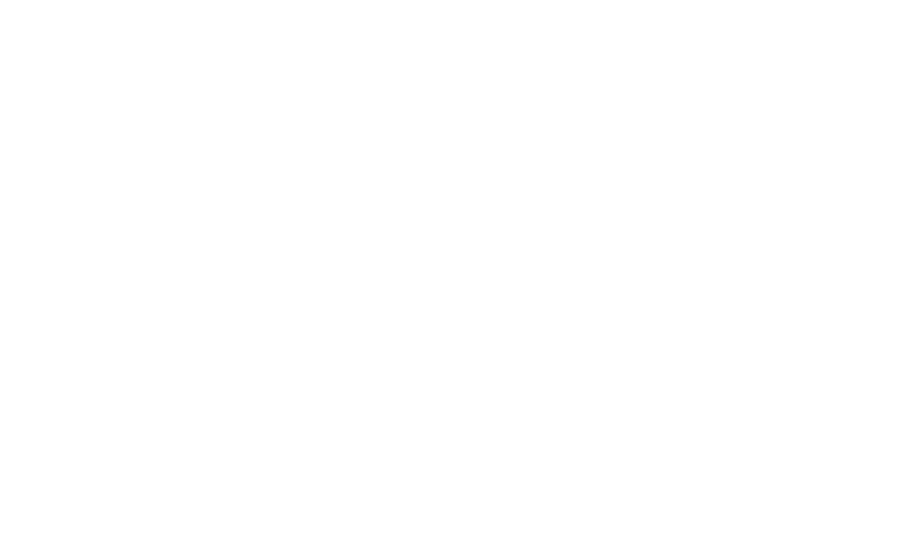

in
[-5.01990908e-03 -2.67009812e-01 -4.95978138e-02 -3.28293985e-02
 -6.11596953e-03 -1.25027101e-02 -1.58771481e-03  5.18399210e-03
  1.05974749e-02  1.82837843e-03 -3.15091984e+00  7.61181844e-03
  4.09298605e-03 -2.45604612e-02  1.94710097e-03 -8.11198112e-03
 -1.79147880e-03  2.07252412e-02  1.21720512e-02  8.00293634e-03
 -9.80327606e-03  8.43653655e-03 -9.00909560e-03 -2.03533267e-03
 -1.34343494e-02 -7.36739543e-03 -3.48218136e-02 -1.60540973e-02
  1.93606672e-02  1.36614997e-02 -5.02399710e-03 -4.18502286e-02
 -3.74442988e-03 -2.08170017e-01  2.30433928e-02  1.97241396e-02
  3.92435114e-03  9.77496629e-03  2.00766241e-02  7.03821764e-03
 -1.79918357e-02  7.49954517e-03  1.96861692e-02 -1.21693291e-03
  1.25915606e-02 -2.23785772e-02 -1.62575646e-02  1.88873460e-02
 -1.91883310e-02  4.82323708e-03  1.20488835e-02  2.87827794e-02
  1.69326228e-02  7.43566131e-03 -9.68226479e-03 -9.25583930e-03
  4.08482959e-03  1.14376938e-02 -8.44736060e-03  2.78741554e-02
  9.12212602e-03 -6.09

<IPython.core.display.Javascript object>


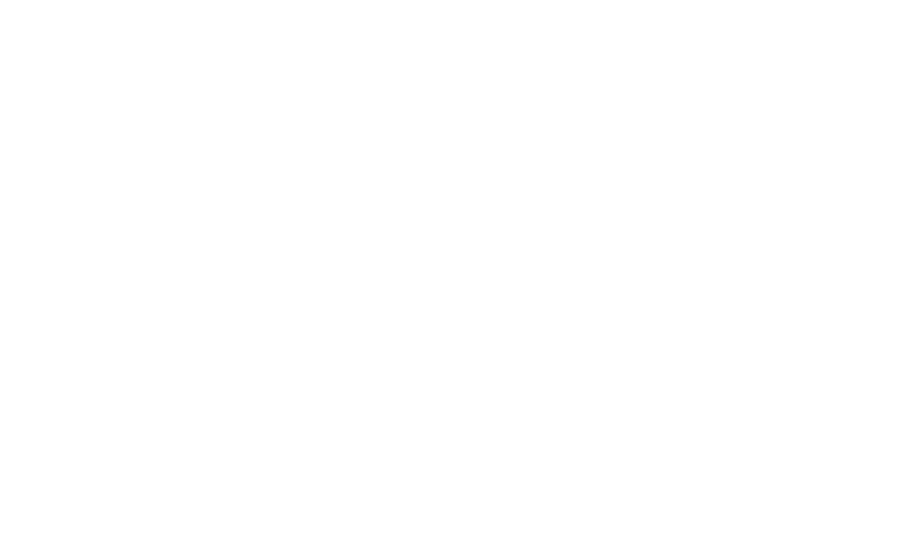

<IPython.core.display.Javascript object>


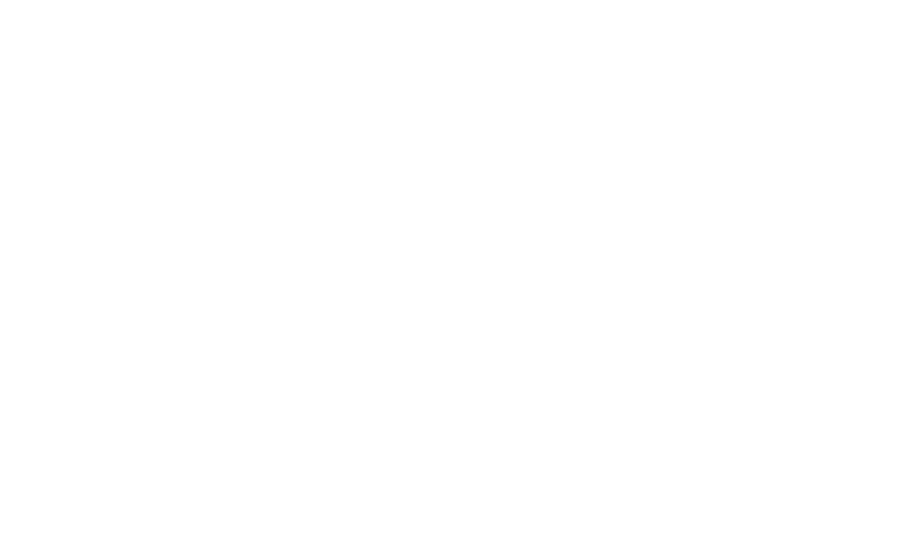

in
[ 0.03131057 -0.00503925  0.03302365 -0.00964704  0.00603288 -1.18830886
 -0.0693475   0.01822167  0.03281925 -0.00511762  0.00435599 -0.00200057
 -0.01275947  0.00397477 -0.05189903  0.00528507  0.05686768  0.00294621
  0.006285   -0.56141415 -0.02624687  0.01730689  0.01152245  0.00965666
 -0.01863338  0.00535596  0.01278368 -0.00798188 -0.1241387  -0.01712664
 -0.00371818  0.01234553 -0.01126299 -0.05236893 -0.01270435 -0.00950261
  0.00801447  0.0198324 ]
i:00 mean:0.000473(0.035671) stdev:0.219890(0.025223) Nchanged:0 Nused:38 Nskipped:0
i:01 mean:-0.018999(0.016035) stdev:0.097538(0.011339) Nchanged:1 Nused:37 Nskipped:1
i:02 mean:-0.003932(0.005337) stdev:0.032024(0.003774) Nchanged:1 Nused:36 Nskipped:2
i:03 mean:-0.000498(0.004183) stdev:0.024749(0.002958) Nchanged:1 Nused:35 Nskipped:3
i:04 mean:-0.000498(0.004183) stdev:0.024749(0.002958) Nchanged:0 Nused:35 Nskipped:3


<IPython.core.display.Javascript object>


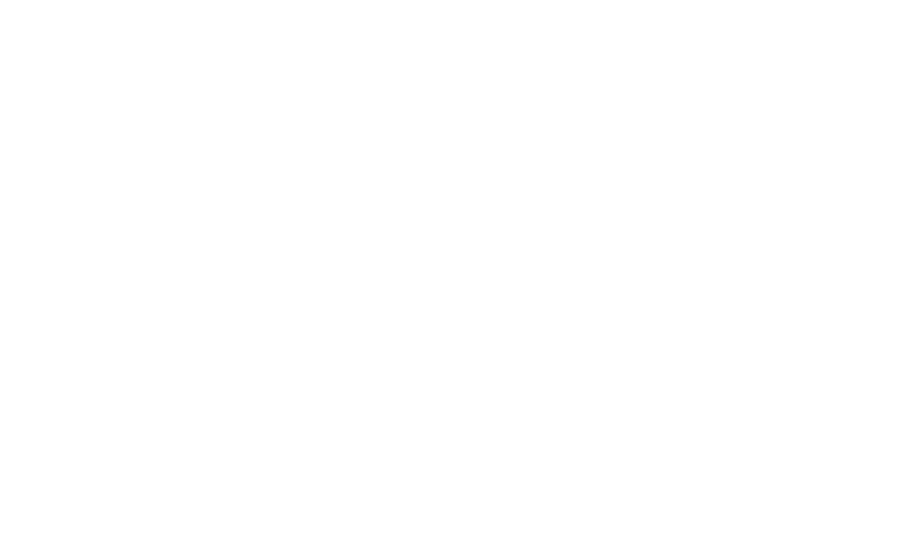

<IPython.core.display.Javascript object>


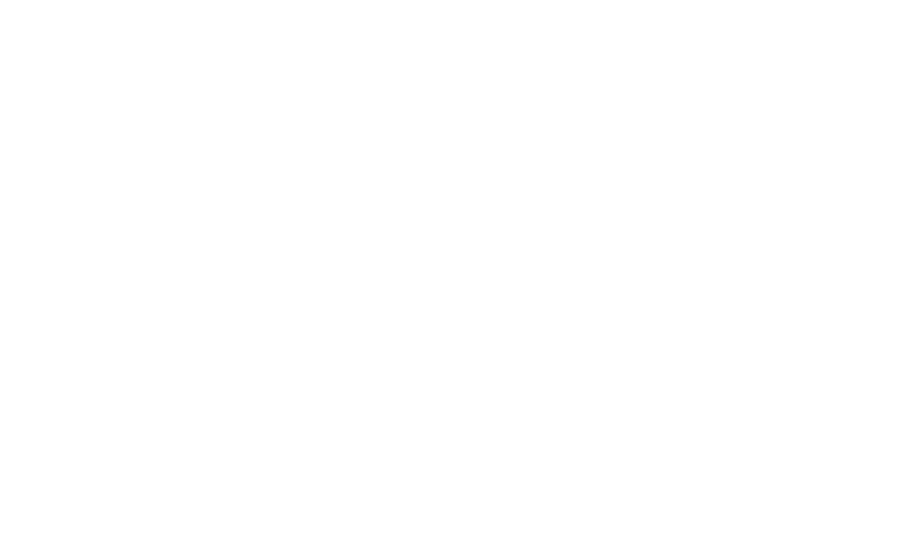

in
[-0.01691152  0.00257477 -0.28451921 -0.01489993  0.02071983 -0.10377355
  0.01101797  0.00617142  0.00716609 -0.02614207 -0.00707948  0.01514257
 -0.02139512  0.01261423 -0.14102669 -0.02522148  0.00239271 -0.0104981
 -0.07311684 -0.01161894 -0.00655727  0.0281391   0.03648743 -0.00740581
  0.01243792  0.01912309  0.01661614 -0.02150296  0.00619041  0.01468453
  0.03277801  0.0065028   0.00997834  0.02483873]
i:00 mean:0.004373(0.010889) stdev:0.063495(0.007700) Nchanged:0 Nused:34 Nskipped:0
i:01 mean:-0.006108(0.006503) stdev:0.037355(0.004598) Nchanged:1 Nused:33 Nskipped:1
i:02 mean:-0.001892(0.005080) stdev:0.028736(0.003592) Nchanged:1 Nused:32 Nskipped:2
i:03 mean:0.001394(0.003978) stdev:0.022149(0.002813) Nchanged:1 Nused:31 Nskipped:3
i:04 mean:0.003878(0.003196) stdev:0.017508(0.002260) Nchanged:1 Nused:30 Nskipped:4
i:05 mean:0.003878(0.003196) stdev:0.017508(0.002260) Nchanged:0 Nused:30 Nskipped:4


<IPython.core.display.Javascript object>


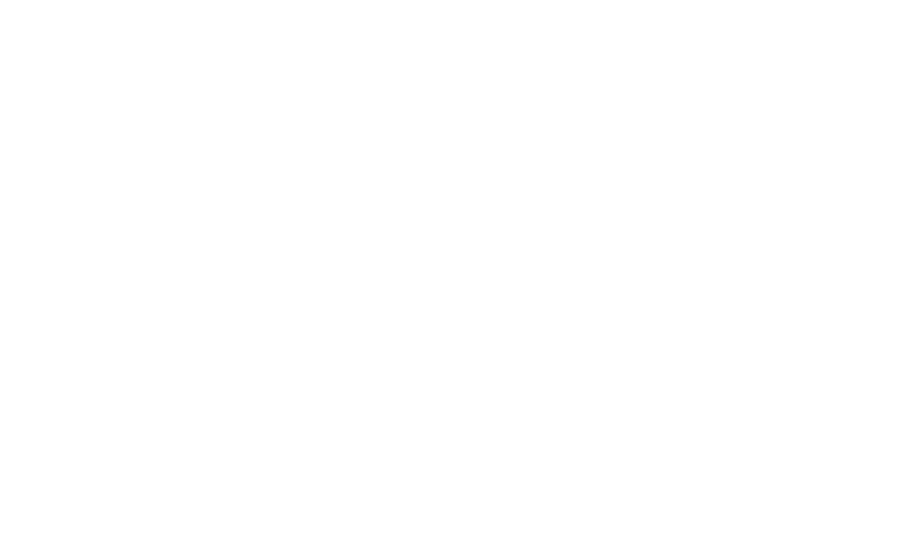

<IPython.core.display.Javascript object>


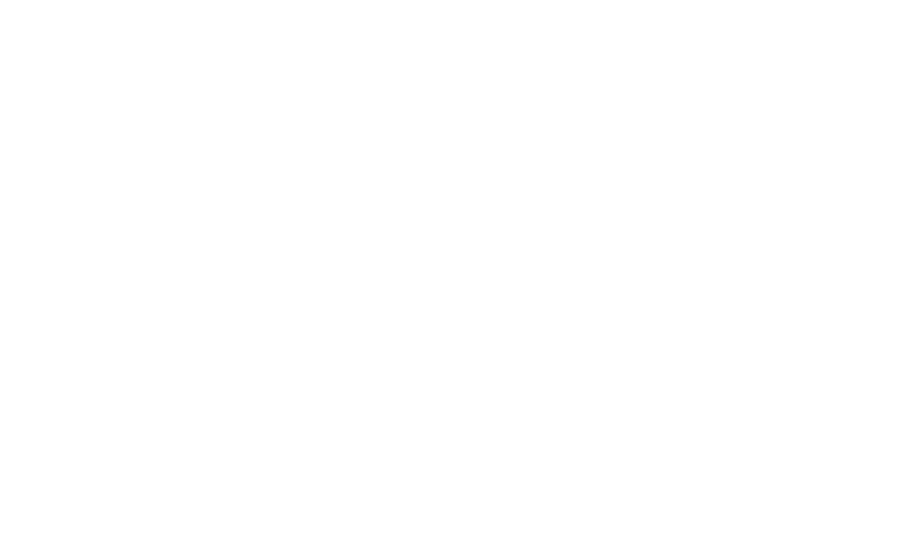

in
[-0.0119987  -0.00544309 -0.00340168 -0.00580009 -0.01932257 -0.01375476
  0.00344108  0.01580835  0.01263514  0.00728406 -0.12380969  0.03459626
  0.0074657   0.00274069 -0.01235263  0.01211546 -0.0239405  -0.01376641
  0.04459696 -0.01010688 -0.00076565  0.14295715  0.00741464 -0.00376666
  0.02543137 -0.00166225 -0.04604581  0.00502338  0.09192295 -0.00328524
  0.02249567 -0.00693299  0.01091284  0.01756834  0.01395125]
i:00 mean:0.002741(0.006739) stdev:0.039869(0.004765) Nchanged:0 Nused:35 Nskipped:0
i:01 mean:0.004638(0.004098) stdev:0.023542(0.002898) Nchanged:2 Nused:33 Nskipped:2
i:02 mean:0.001910(0.003137) stdev:0.017744(0.002218) Nchanged:1 Nused:32 Nskipped:3
i:03 mean:0.001910(0.003137) stdev:0.017744(0.002218) Nchanged:0 Nused:32 Nskipped:3


<IPython.core.display.Javascript object>


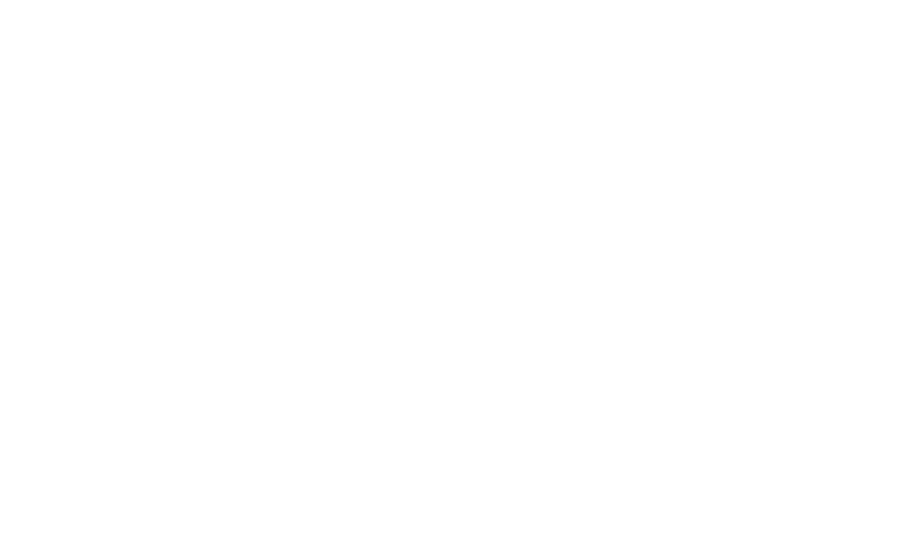

<IPython.core.display.Javascript object>


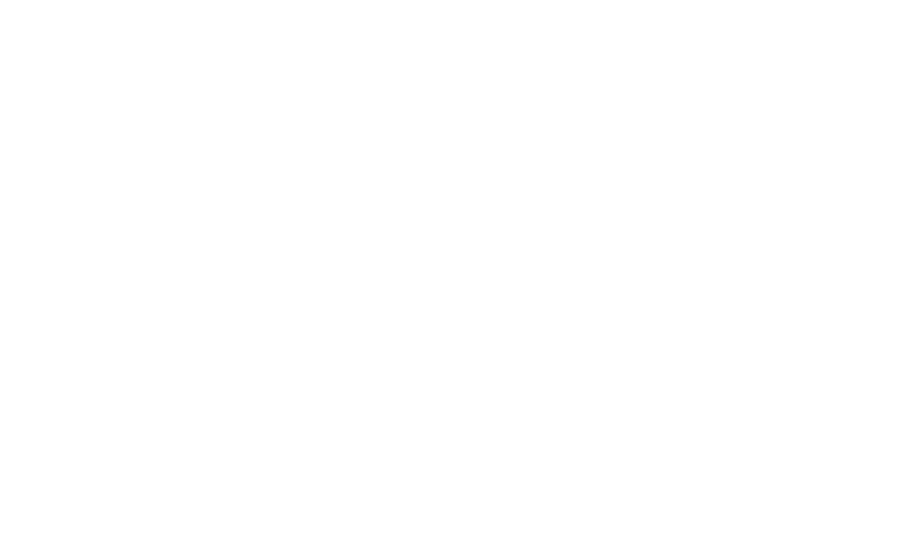

in
[-0.09449096  0.01789441  0.00807438  0.0107178   0.00952553  0.03045967
 -0.00520215  0.02423048  0.01379337 -0.15371002 -1.83281404 -0.05442692
 -0.00490619 -0.75588117  0.01743728 -0.00859475 -0.00463629 -0.0036061
 -0.02996846  0.0129509  -0.00885154  0.02131711  0.01449325 -0.00560423
 -0.02027673  0.02127087  0.00300352 -0.02985968  0.00479388 -0.0115131
  0.00988438  0.06132648  0.01451844  0.03976544  0.03227025 -0.01045053]
i:00 mean:0.003899(0.056753) stdev:0.340516(0.040130) Nchanged:0 Nused:36 Nskipped:0
i:01 mean:-0.023836(0.022626) stdev:0.133857(0.015999) Nchanged:1 Nused:35 Nskipped:1
i:02 mean:-0.002305(0.006635) stdev:0.038691(0.004692) Nchanged:1 Nused:34 Nskipped:2
i:03 mean:0.002283(0.004908) stdev:0.028192(0.003470) Nchanged:1 Nused:33 Nskipped:3
i:04 mean:0.005307(0.003970) stdev:0.022456(0.002807) Nchanged:1 Nused:32 Nskipped:4
i:05 mean:0.005307(0.003970) stdev:0.022456(0.002807) Nchanged:0 Nused:32 Nskipped:4


<IPython.core.display.Javascript object>


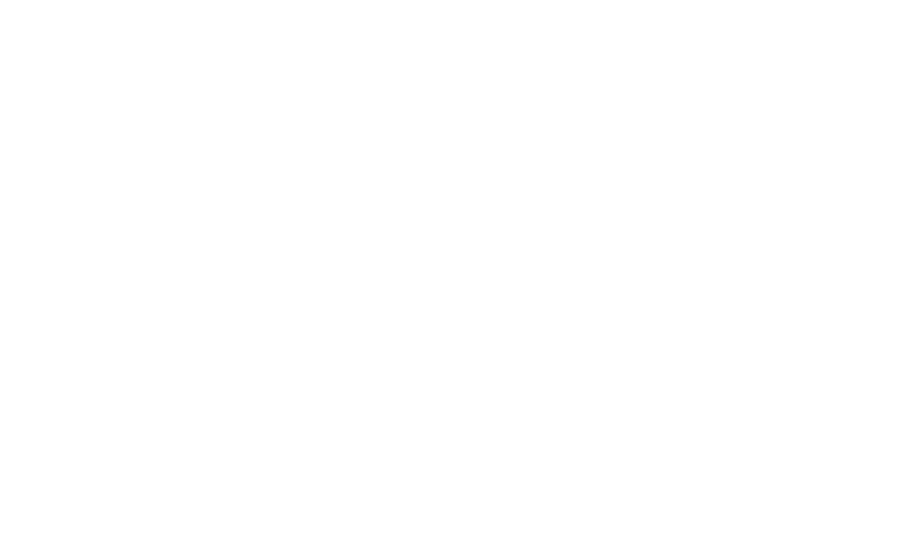

<IPython.core.display.Javascript object>


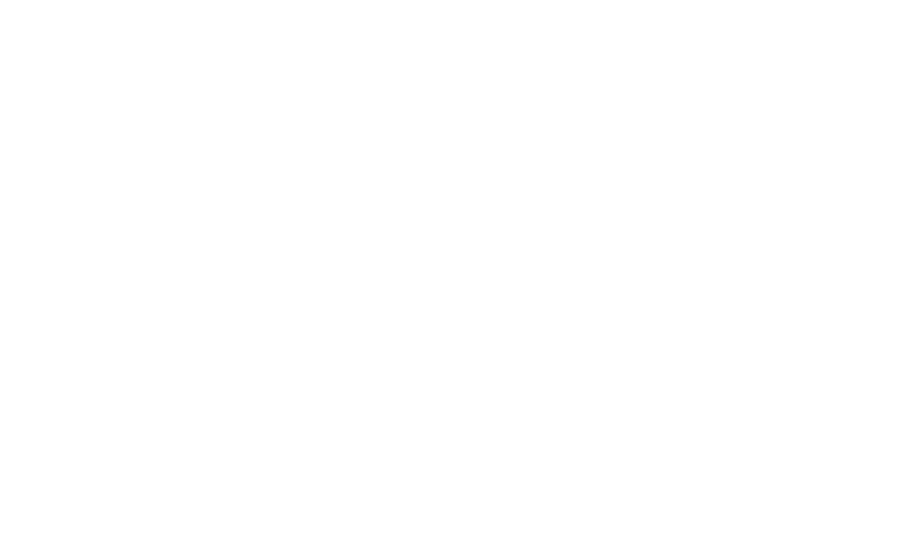

in
[ 0.02911597  0.00253673 -0.00109812 -0.0015953  -0.01574551  0.00042137
 -0.031984   -0.01522447 -0.0083215   0.02098965 -0.00461748 -0.01147791
 -0.01749939 -0.00876117  0.01322849  0.01153414 -0.20464853 -0.00385109
  0.00711944 -0.00402151  0.01695232 -0.01453322  0.01449901 -0.02597141
 -0.00499401  0.02345578  0.00300368  0.00221719  0.03674027  0.00466872
  0.03666889 -0.06124659]
i:00 mean:-0.001347(0.007410) stdev:0.041919(0.005240) Nchanged:0 Nused:32 Nskipped:0
i:01 mean:-0.000251(0.003657) stdev:0.020363(0.002586) Nchanged:1 Nused:31 Nskipped:1
i:02 mean:-0.000251(0.003657) stdev:0.020363(0.002586) Nchanged:0 Nused:31 Nskipped:1


<IPython.core.display.Javascript object>


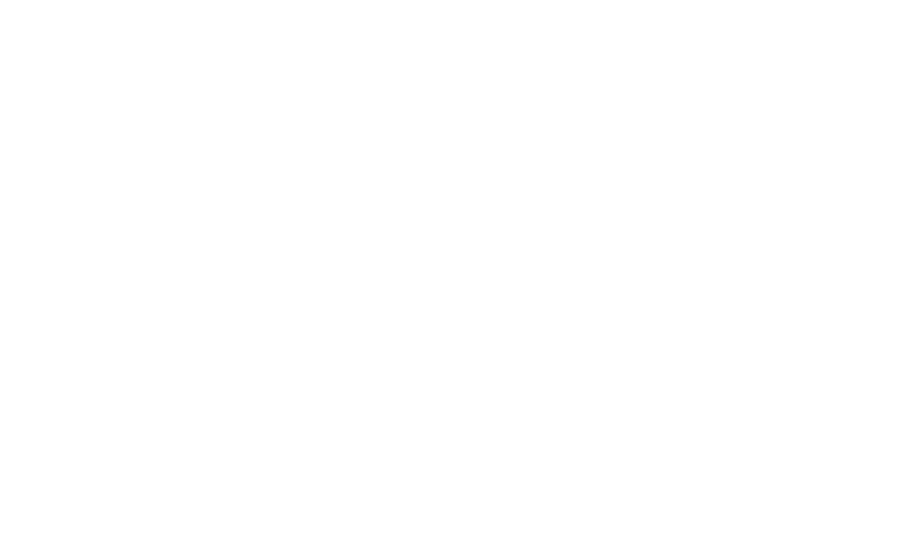

<IPython.core.display.Javascript object>


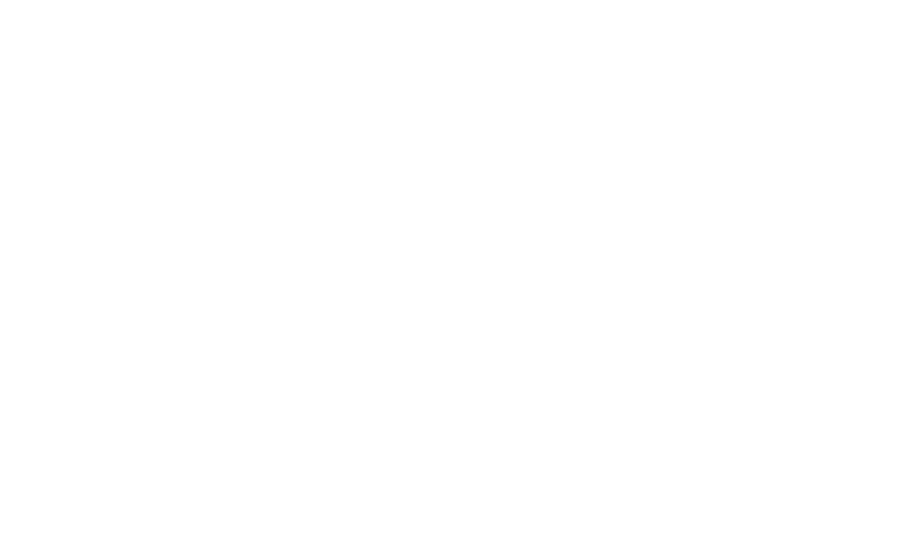

in
[-0.01187191 -0.01047706  0.0052102   0.01018147  0.02277829 -0.01046469
 -0.92807198  0.00486683  0.00790574 -0.00355155 -0.00768908  0.02460285
 -0.01762736 -0.54752764  0.02339943 -0.02036527  0.19549247 -2.92712877
  0.00986648 -0.00516402 -0.02099773  0.01020241 -0.01827658 -0.01003693
  0.01887214  0.00539154 -0.01160751  0.02100137 -0.01111981  0.04467029
  0.01223022 -0.0196731  -0.10653241]
i:00 mean:-0.005164(0.096808) stdev:0.556122(0.068454) Nchanged:0 Nused:33 Nskipped:0
i:01 mean:-0.042012(0.034502) stdev:0.195171(0.024396) Nchanged:1 Nused:32 Nskipped:1
i:02 mean:-0.013429(0.019605) stdev:0.109154(0.013863) Nchanged:1 Nused:31 Nskipped:2
i:03 mean:0.004374(0.008147) stdev:0.044623(0.005761) Nchanged:1 Nused:30 Nskipped:3
i:04 mean:-0.002216(0.004877) stdev:0.026264(0.003449) Nchanged:1 Nused:29 Nskipped:4
i:05 mean:0.001509(0.003222) stdev:0.017048(0.002278) Nchanged:1 Nused:28 Nskipped:5
i:06 mean:0.001509(0.003222) stdev:0.017048(0.002278) Nchanged:0 Nused:28 Nskipp

<IPython.core.display.Javascript object>


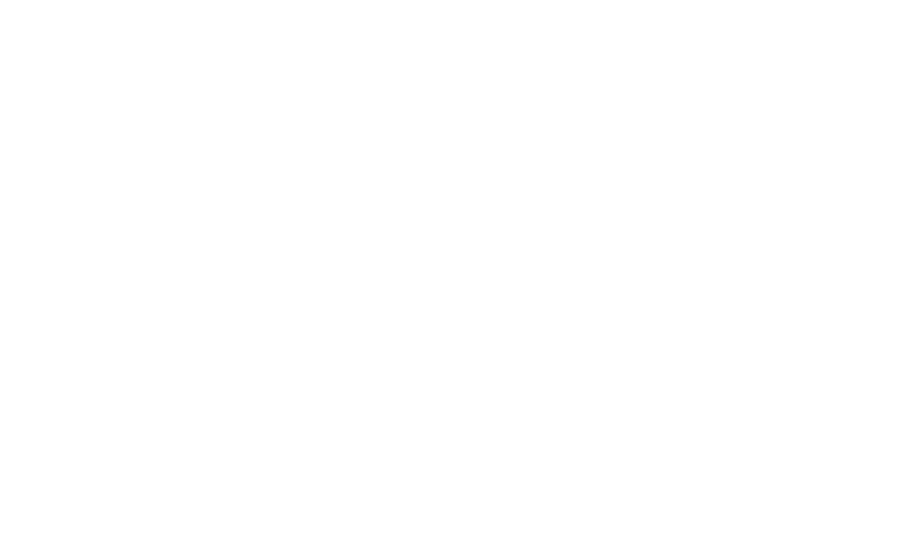

<IPython.core.display.Javascript object>


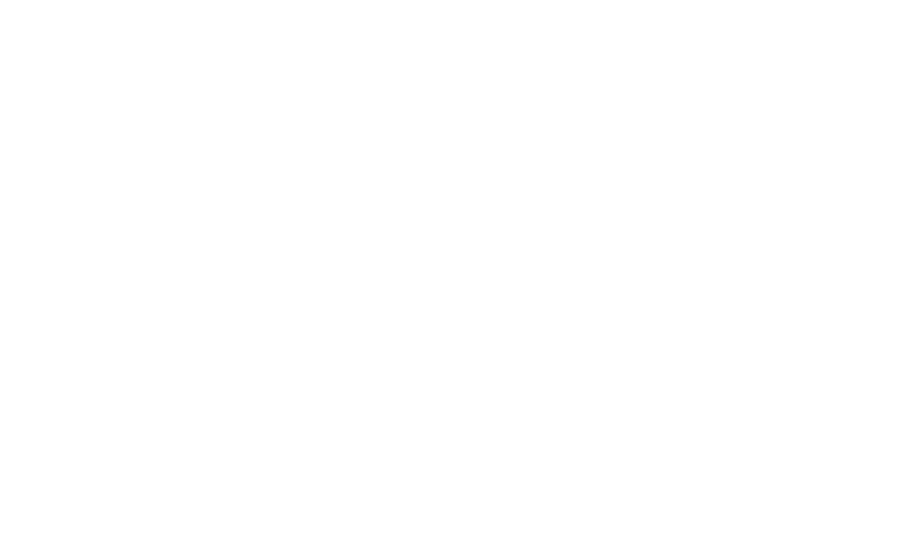

in
[-1.63949267e-02  5.86424131e-03 -3.52472110e-01 -1.87918326e-01
 -5.24375018e-02 -2.48830294e-02  3.25258366e-03  3.26676290e-02
  1.38545342e-02  5.70645363e-03  2.32965348e-01 -1.65276653e-02
  2.14700230e-02  1.15672842e-02 -9.89401672e-03 -2.96085382e-02
  1.81035063e-02 -5.11632480e-01  6.24589173e-03  1.21532061e-02
 -1.76905461e-02 -7.39708313e-03 -2.75310508e-03 -5.04901944e-04
  3.50465754e-02 -5.33831789e-03  5.59875292e-03 -1.05129777e-02
  4.03558479e-02 -3.46056470e-02 -4.37028219e-02 -3.19928355e-03
  2.12427397e-02  1.28318493e-02  2.25872369e-02  1.11154765e-03
  4.34542888e-03]
i:00 mean:0.001112(0.019362) stdev:0.117774(0.013691) Nchanged:0 Nused:37 Nskipped:0
i:01 mean:0.001246(0.009441) stdev:0.055856(0.006676) Nchanged:2 Nused:35 Nskipped:2
i:02 mean:-0.000044(0.003798) stdev:0.021819(0.002686) Nchanged:2 Nused:33 Nskipped:4
i:03 mean:-0.000044(0.003798) stdev:0.021819(0.002686) Nchanged:0 Nused:33 Nskipped:4


<IPython.core.display.Javascript object>


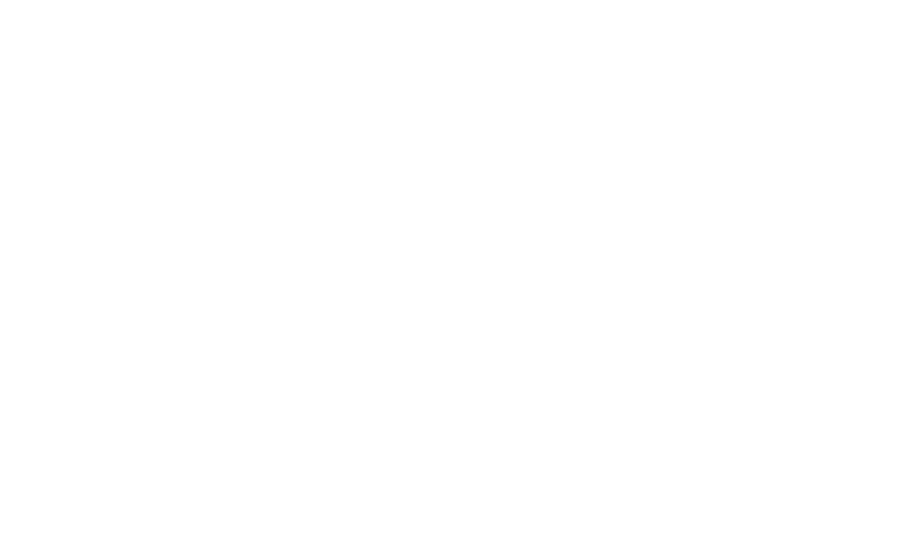

<IPython.core.display.Javascript object>


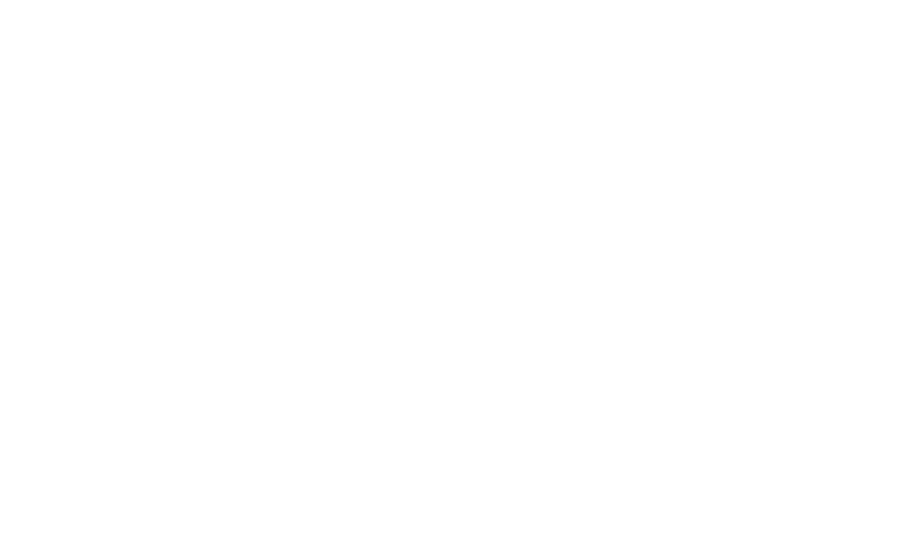

in
[-0.00502472 -0.01433994 -0.01259633  0.03799482 -0.02125943  0.00592619
  0.0021727  -0.01344655 -0.01650449 -0.25995099  0.02092012  0.0422665
  0.00533071 -0.01272127 -0.05884869 -0.00732599 -0.00972485  0.00628555
  0.02694415 -0.00818631  0.0079027   0.00746879  0.01011229  0.0244101
  0.00973455 -0.0140048   0.00868158  0.00077468 -0.01857839 -0.00137062
 -0.01260936 -0.02931663 -0.02335267  0.02675211  0.00572776 -0.0150134
  0.00889857  0.01975666  0.03074827  0.00785469 -0.02654874  0.00698073
 -0.02707578 -0.00116394]
i:00 mean:-0.000195(0.006707) stdev:0.044491(0.004743) Nchanged:0 Nused:44 Nskipped:0
i:01 mean:-0.000590(0.003055) stdev:0.020032(0.002160) Nchanged:1 Nused:43 Nskipped:1
i:02 mean:-0.000590(0.003055) stdev:0.020032(0.002160) Nchanged:0 Nused:43 Nskipped:1


<IPython.core.display.Javascript object>


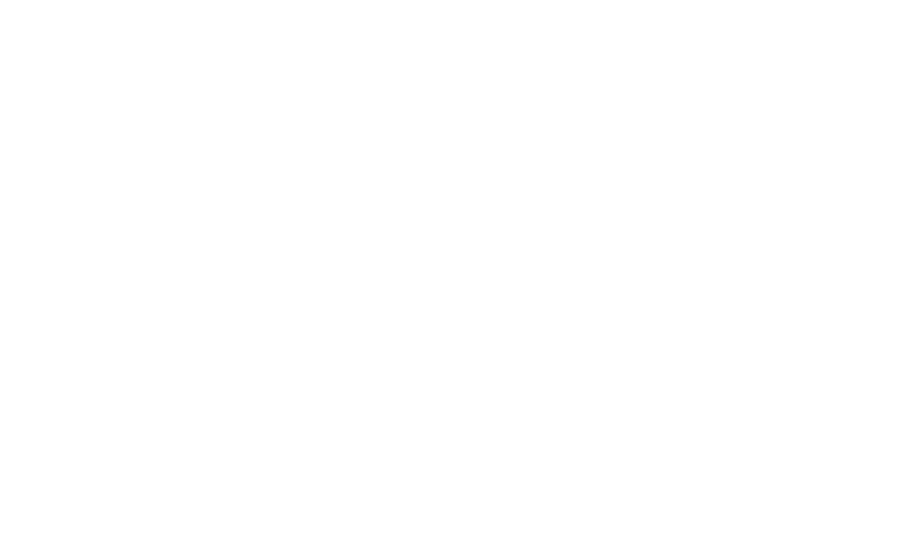

<IPython.core.display.Javascript object>


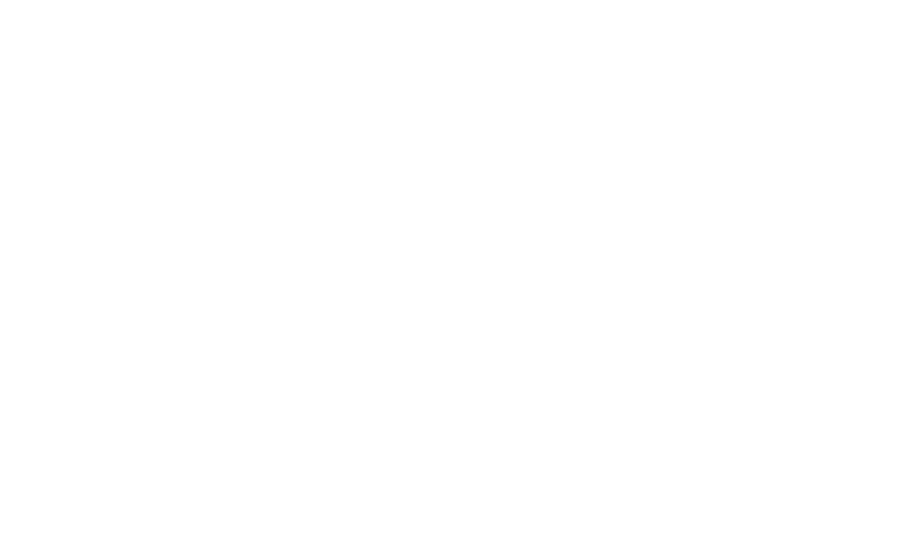

in
[-0.01361367  0.02417089  0.02314562 -0.02198771 -0.02568348 -0.0193171
  0.00825101 -0.03446546  0.02319484  0.015136   -0.00289375  0.00037224
 -0.01997372 -0.07061787  0.02378618 -0.00524853 -0.01154889  0.06571135
 -0.01149903  0.00353303  0.00423891 -0.03160432  0.02315801  0.00733959
  0.03084995 -0.00817798 -0.04065867 -0.00417109  0.02512154  0.04502249
  0.0076056  -0.09454171  0.0080171  -0.00515467  0.007353   -0.01737002
  0.00445553  0.02890239 -0.01421241 -0.00237149 -0.08272483  0.02565273
 -0.03132179 -0.02758123  0.02595143 -0.00868577  0.00030453 -0.00356065]
i:00 mean:-0.002633(0.004353) stdev:0.030156(0.003078) Nchanged:0 Nused:48 Nskipped:0
i:01 mean:-0.001770(0.003976) stdev:0.027258(0.002811) Nchanged:1 Nused:47 Nskipped:1
i:02 mean:-0.001770(0.003976) stdev:0.027258(0.002811) Nchanged:0 Nused:47 Nskipped:1


<IPython.core.display.Javascript object>


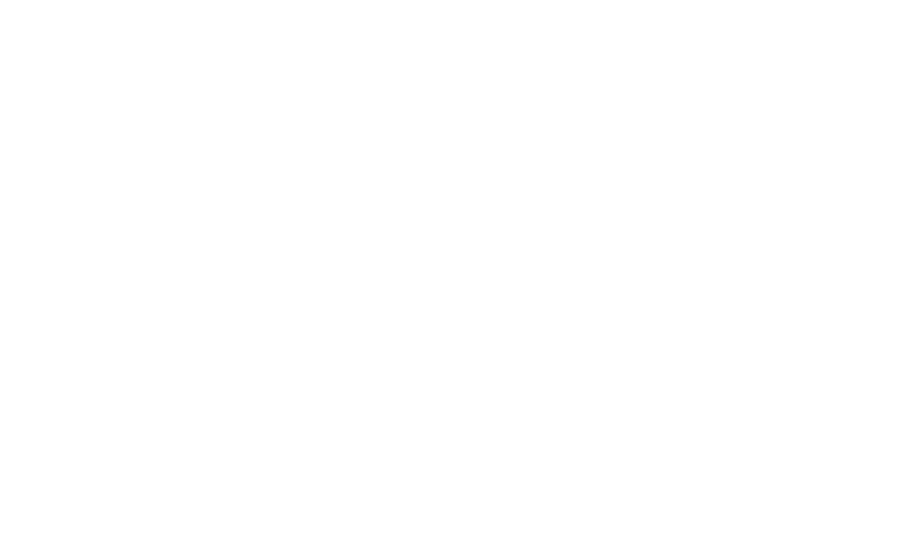

<IPython.core.display.Javascript object>


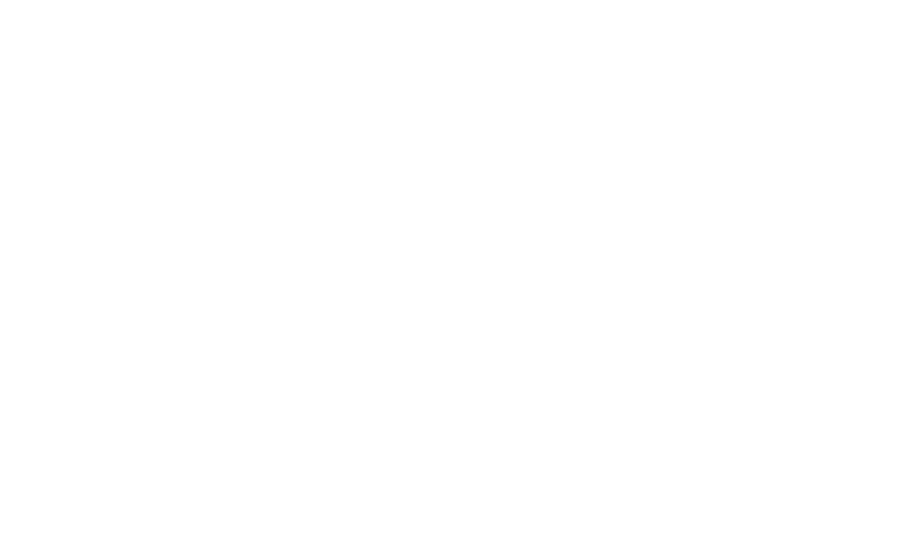

in
[ 0.01633442  0.02971591  0.02221333 -0.0111229  -0.00404961  0.02215566
  0.01006841 -0.02221365  0.01851089  0.01564884 -0.0091054   0.0102058
  0.0244962   0.00470817 -0.23983742  0.01110751 -0.15748267  0.00410474
 -0.00957539  0.03504039 -0.01018714 -0.01607154  0.01118561  0.02601001
  0.0076768   0.01157563 -0.01207868 -0.00169874 -0.01252982 -0.01281183
  0.02675529  0.00959043 -0.00789502 -0.00613056 -0.01412642 -0.05856689
 -0.05487666]
i:00 mean:0.004105(0.008763) stdev:0.053301(0.006196) Nchanged:0 Nused:37 Nskipped:0
i:01 mean:0.001545(0.003579) stdev:0.021172(0.002530) Nchanged:2 Nused:35 Nskipped:2
i:02 mean:0.001545(0.003579) stdev:0.021172(0.002530) Nchanged:0 Nused:35 Nskipped:2


<IPython.core.display.Javascript object>


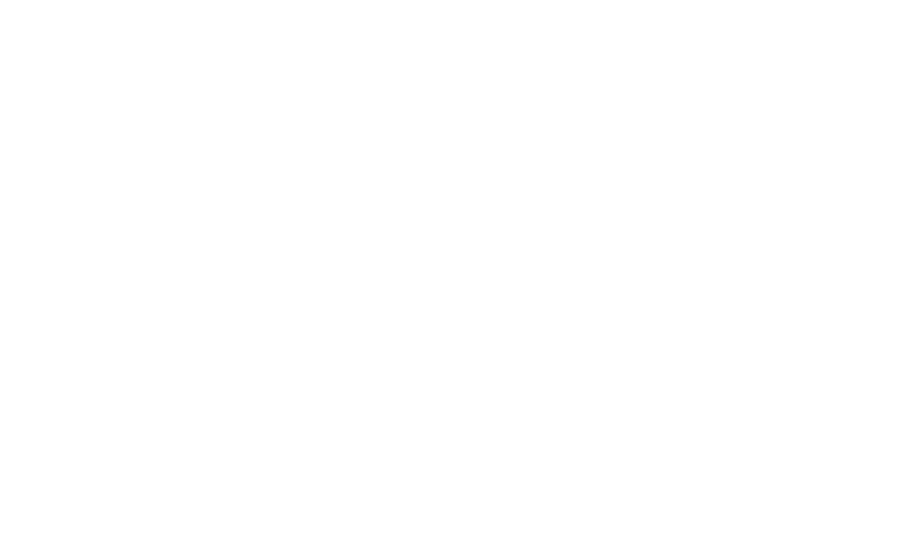

<IPython.core.display.Javascript object>


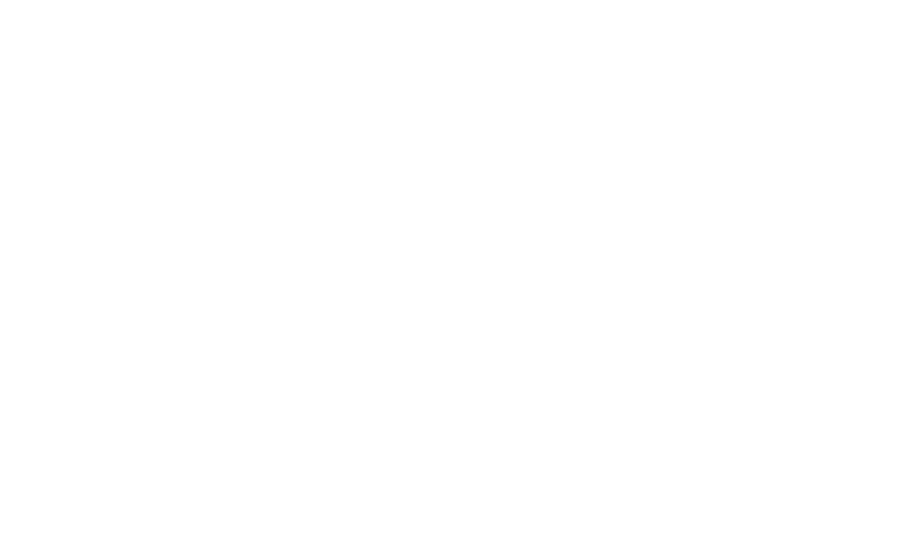

in
[ 0.0062771  -0.03412413 -0.02788766  0.00354868 -0.01200036  0.01072371
  0.00599927  0.0041772   0.01463391  0.01704288 -0.01517708 -0.00774302
 -0.00743844  0.00598487  0.0119534   0.00488399  0.00333815 -0.57189053
  0.00410139  0.02316999 -2.31323286 -0.01363093 -0.02795687 -0.01335179
  0.01503196  0.02189811 -0.02741924  0.02094363]
i:00 mean:0.003825(0.087698) stdev:0.464053(0.062012) Nchanged:0 Nused:28 Nskipped:0
i:01 mean:-0.021663(0.021602) stdev:0.112248(0.015275) Nchanged:1 Nused:27 Nskipped:1
i:02 mean:-0.000501(0.003305) stdev:0.016852(0.002337) Nchanged:1 Nused:26 Nskipped:2
i:03 mean:-0.000501(0.003305) stdev:0.016852(0.002337) Nchanged:0 Nused:26 Nskipped:2


<IPython.core.display.Javascript object>


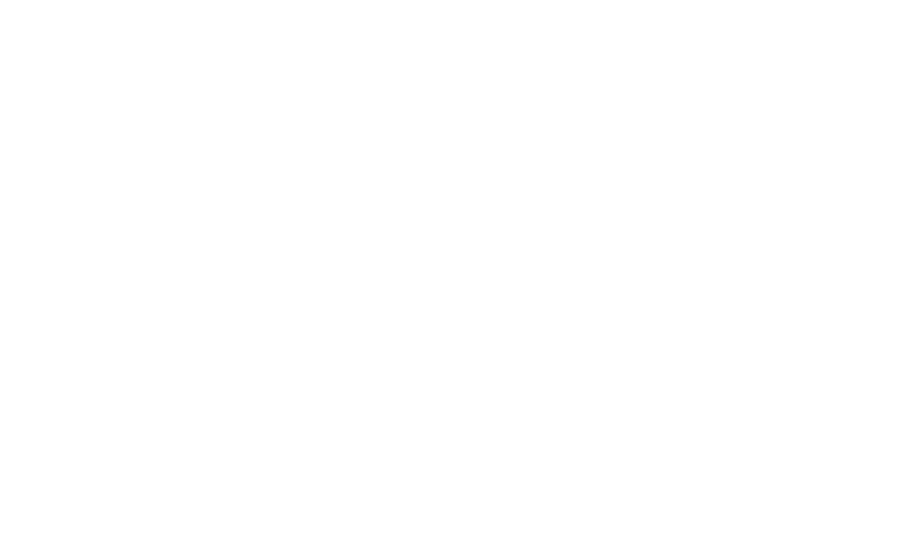

<IPython.core.display.Javascript object>


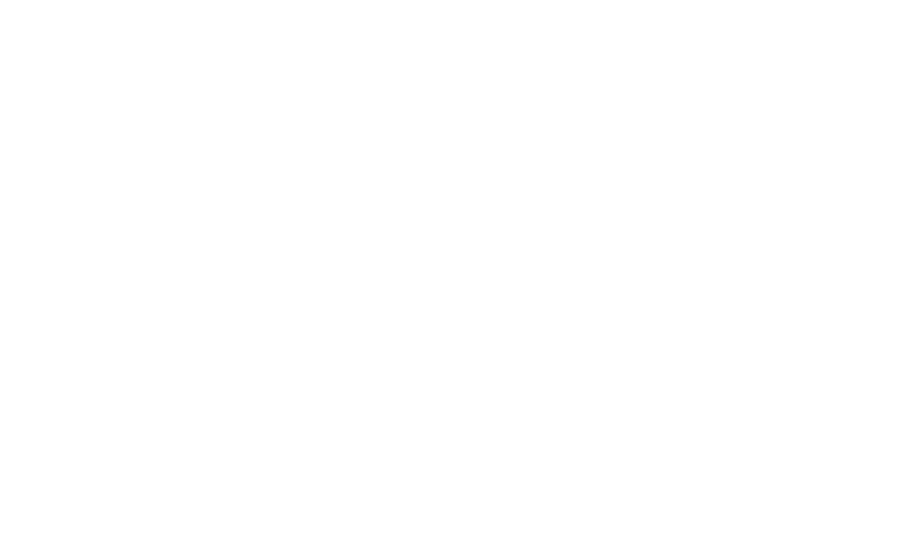

in
[ 0.0056504  -0.01172442  0.00507101 -0.07608961 -0.03712197  0.03744396
 -0.01687788 -0.00139995 -0.00446323 -0.01541248  0.00816378 -0.03287003
 -0.01951532 -0.01458738  0.00337711 -0.0025499   0.05085699  0.00946819
  0.01959174  0.00395077 -0.00567762 -0.02904936  0.00770554  0.03762842
  0.01896982  0.02346894  0.01127206 -0.00350205  0.00604691 -0.52263703
 -0.01569821 -0.00560932 -0.00997211]
i:00 mean:-0.002550(0.016655) stdev:0.095676(0.011777) Nchanged:0 Nused:33 Nskipped:0
i:01 mean:-0.001670(0.004279) stdev:0.024203(0.003025) Nchanged:1 Nused:32 Nskipped:1
i:02 mean:0.000730(0.003645) stdev:0.020295(0.002577) Nchanged:1 Nused:31 Nskipped:2
i:03 mean:0.000730(0.003645) stdev:0.020295(0.002577) Nchanged:0 Nused:31 Nskipped:2


<IPython.core.display.Javascript object>


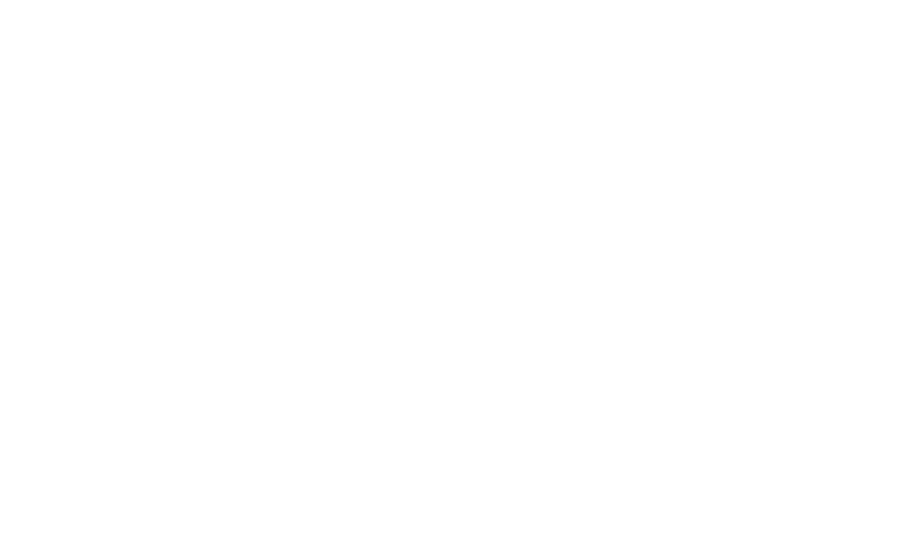

<IPython.core.display.Javascript object>


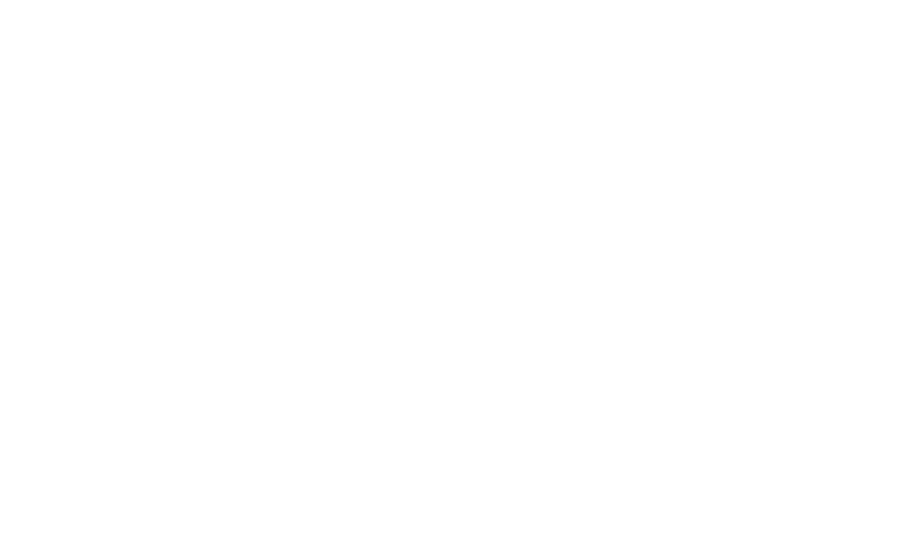

in
[-5.85835782e-03 -9.28737757e-05  1.35014664e-02 -1.75277137e-03
  7.77571641e-02  2.00029066e-02 -9.93907671e-03 -9.53175700e-02
  7.55428955e-03  8.73240685e-03 -8.56430836e-02  1.78779447e-02
 -9.22310499e-03 -4.36437890e-03 -2.50535728e-03 -2.90440383e-02
  5.84285876e-03 -3.81907831e-03 -1.89738281e-02 -1.58014080e-02
  2.00358186e-03 -3.54563171e-03  2.01453948e-02  1.08033642e-02
  7.01780896e-02  3.84129116e-03 -5.79302363e-03 -7.39980813e-03
  7.03367044e-03  1.22818534e-02  5.50781595e-03 -1.44860457e-02
 -1.69185180e-02 -9.36678801e-02]
i:00 mean:-0.002129(0.006007) stdev:0.035024(0.004247) Nchanged:0 Nused:34 Nskipped:0
i:01 mean:-0.004149(0.005996) stdev:0.034963(0.004240) Nchanged:0 Nused:34 Nskipped:0


<IPython.core.display.Javascript object>


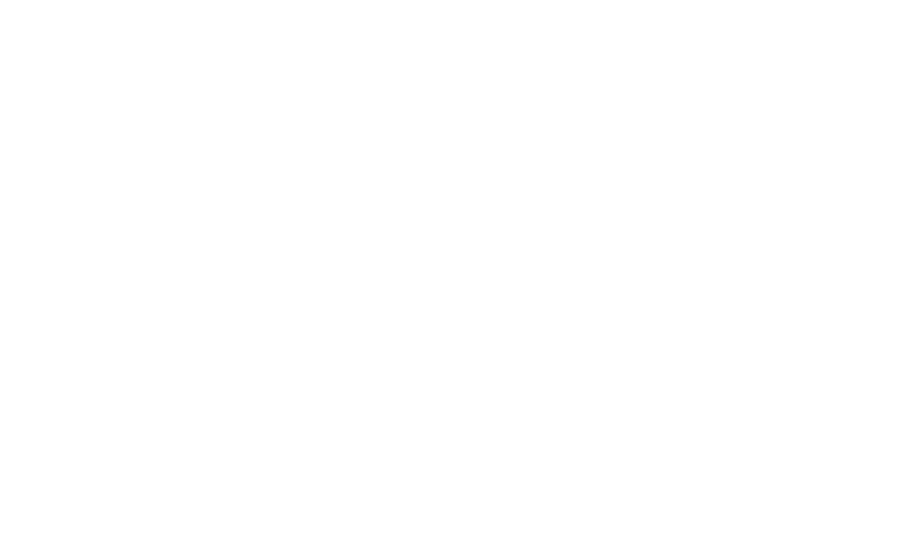

<IPython.core.display.Javascript object>


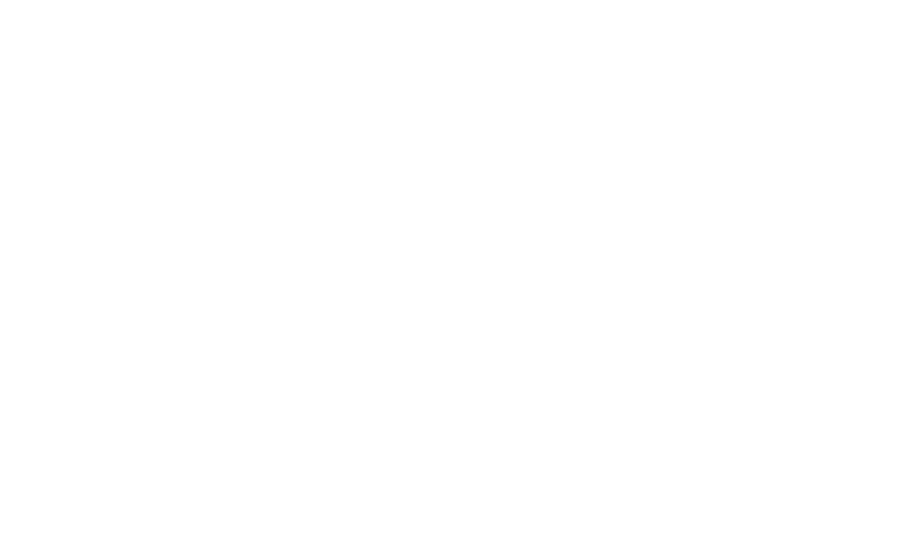

in
[-0.01876536 -0.01394187  0.00550303 -0.00271704  0.01703061  0.57600096
 -0.00082912  0.00796309 -0.00777471 -0.01151175  0.00723216 -0.04770168
  0.01480367  0.0030451   0.00446175 -0.0029253   0.00589778  0.01823266
 -0.07949689  0.01694014 -0.00890539 -0.0332891  -0.01649626 -0.00293959
 -0.01953042  0.00180288  0.03033793  0.01618657 -0.02500179  0.01442223
 -0.00343247 -0.02462475 -0.06246109  0.0200865   0.02147185  0.01398442]
i:00 mean:0.000487(0.016823) stdev:0.100935(0.011895) Nchanged:0 Nused:36 Nskipped:0
i:01 mean:-0.004655(0.004065) stdev:0.024050(0.002875) Nchanged:1 Nused:35 Nskipped:1
i:02 mean:-0.002454(0.003510) stdev:0.020465(0.002482) Nchanged:1 Nused:34 Nskipped:2
i:03 mean:-0.002454(0.003510) stdev:0.020465(0.002482) Nchanged:0 Nused:34 Nskipped:2


<IPython.core.display.Javascript object>


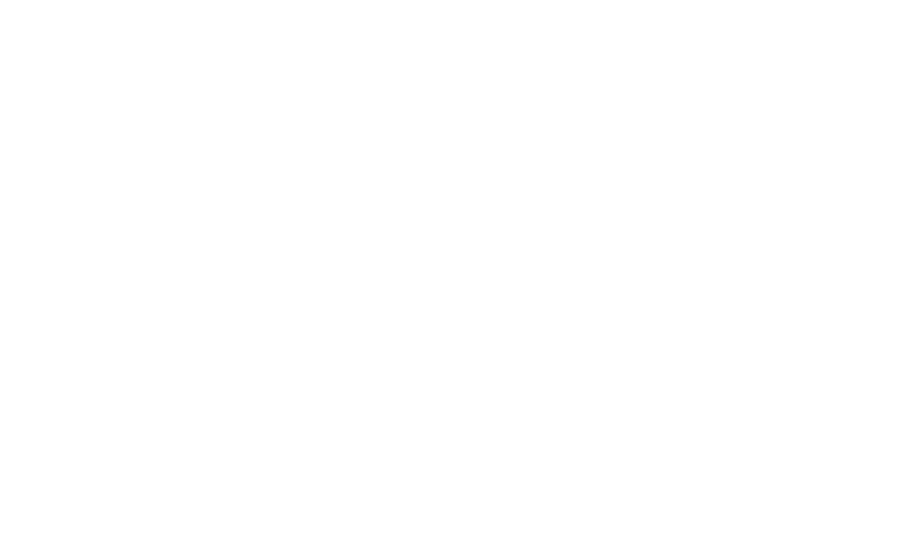

<IPython.core.display.Javascript object>


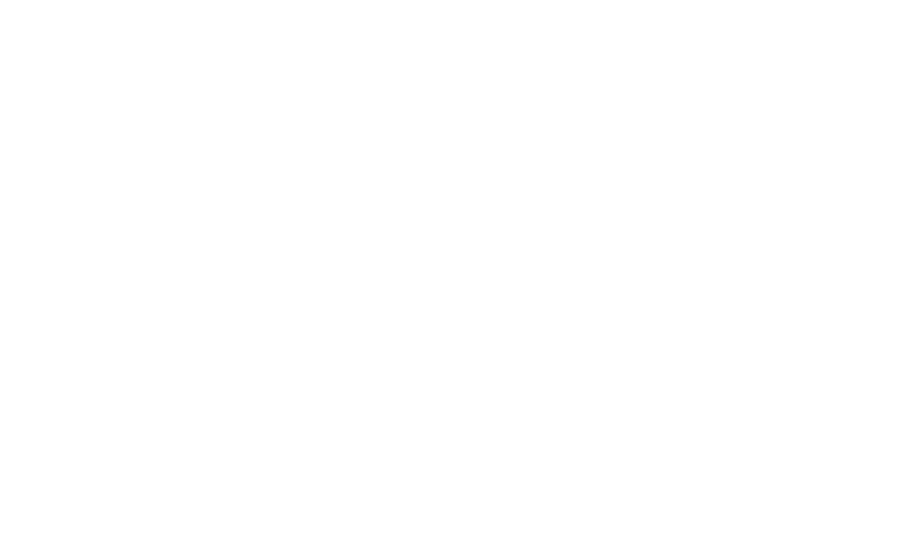

in
[-1.95681417e-02 -1.52575938e-02  2.48714475e-02 -1.18792088e-02
  3.29264208e-01  8.45214524e-03 -3.28237907e-02  1.71935725e-02
 -2.92770145e-03  8.43248840e-03  2.36263890e-03  5.06103762e-03
  8.31532142e-03 -5.90427944e-02  1.01399179e-02 -6.92396190e-02
 -3.29499128e-03  1.80488114e-03  1.56840875e-02 -1.83491066e-02
 -5.08221284e-03  9.88900184e-03  9.53731288e-03 -5.10358294e-02
 -2.23516686e-02 -4.70680553e-01 -6.64641296e-01 -2.62122632e-02
  2.85147398e-02  2.21979847e-02 -2.27149839e-02 -9.08421355e-03
 -3.29177813e-02  3.90090181e-03  1.93079231e-02 -5.11942218e-01
  4.03905120e-03  4.28124113e-03 -7.19429879e-03 -1.17406528e-02
 -1.11166806e-02  1.89511810e-02  2.86761738e-03  9.23145026e-03
 -1.29500214e-03  1.41337582e-02 -3.57291510e-03  1.18952155e-02
  2.57603984e-03  2.06529533e-02  1.53989108e-02 -2.68656049e-02
 -1.35482303e-02 -1.68892926e-02  1.03925032e-02 -5.60082248e-02
 -1.05933946e-02  4.48907106e-04  1.78452696e-02 -2.18736546e-02
  2.93411448e-02 -1.64

<IPython.core.display.Javascript object>


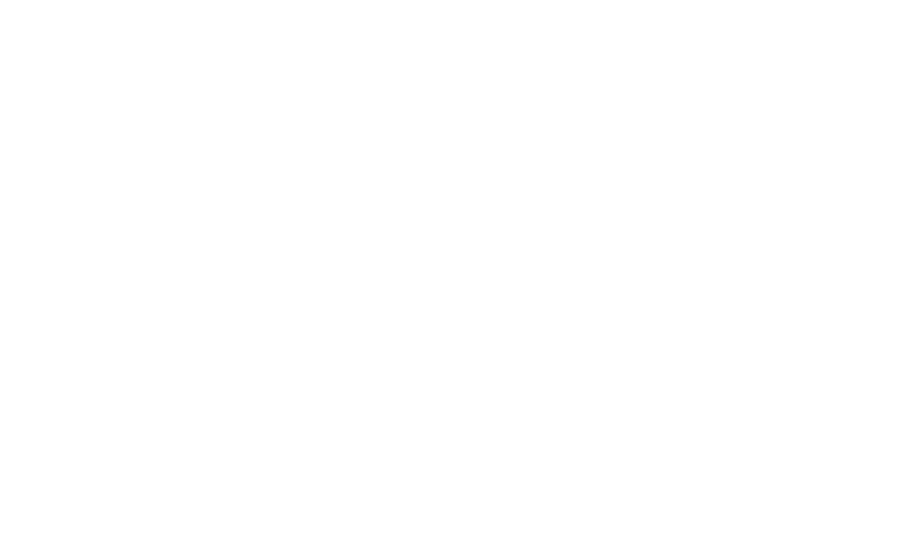

<IPython.core.display.Javascript object>


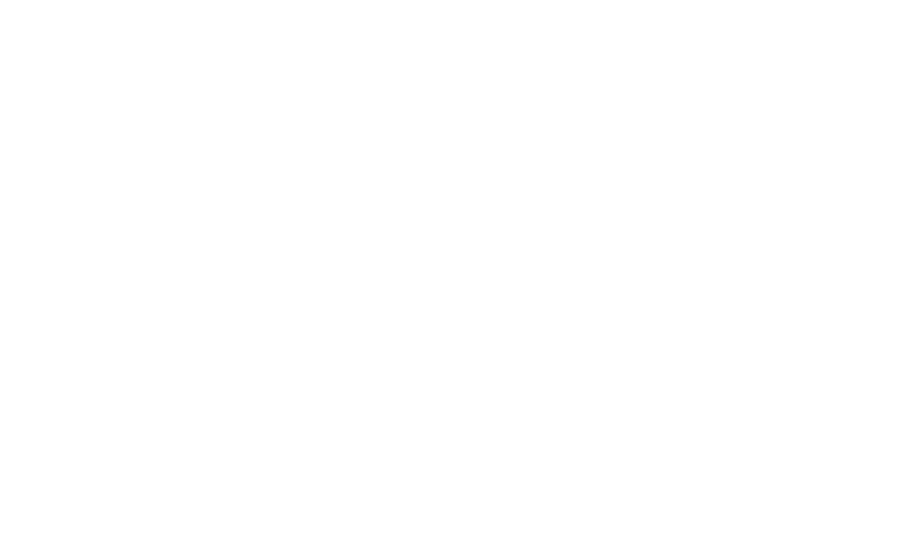

in
[ 3.72336539e-03 -2.63849985e-02 -4.12688602e-02 -2.63335387e-02
  1.98650069e-04  1.36128790e-03 -6.28595641e-02 -5.39902023e-02
  1.06003536e-02 -1.82589051e-02 -2.38630476e-02 -2.86453104e-02
 -4.45572621e-03 -3.46592831e-03  1.38670501e-02  2.02227153e-02
 -2.04723897e-02 -1.09173323e-02  5.69865633e-03  8.81666539e-03
  2.50490096e-02 -2.04343859e-02 -3.40646798e-01 -5.04853627e-02
 -1.72046763e-02  8.14835198e-03  7.25979307e-03 -3.04281027e-03
  6.54221321e-03 -3.81817585e-03  2.74519143e-03  1.73165250e-02
  8.01852052e-03  1.54200058e-02  1.39024802e-02 -5.82541850e-03
  1.80176847e-02 -6.85972541e-03 -1.26208826e-01 -5.82809071e-02
  6.44376984e-03 -1.20122427e-02  1.41232379e-02 -3.66183045e-01
 -1.79423831e-02 -2.61149248e-02  1.28035310e-02  2.32139069e-02
 -3.60599617e+00  1.67987976e-02  1.01675811e-02  1.84414799e-02
  7.05864259e-03]
i:00 mean:-0.003043(0.069713) stdev:0.507521(0.049295) Nchanged:0 Nused:53 Nskipped:0
i:01 mean:-0.020770(0.010107) stdev:0.072883(0.0

<IPython.core.display.Javascript object>


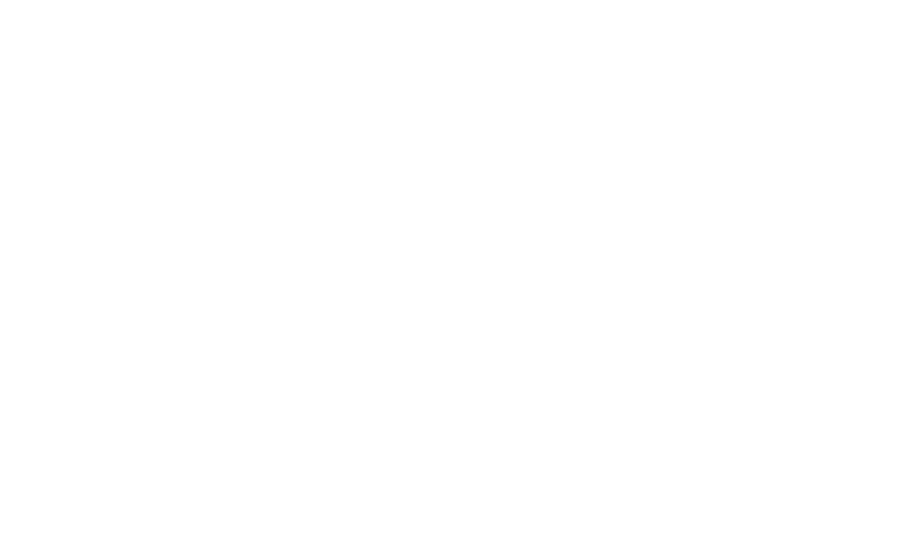

<IPython.core.display.Javascript object>


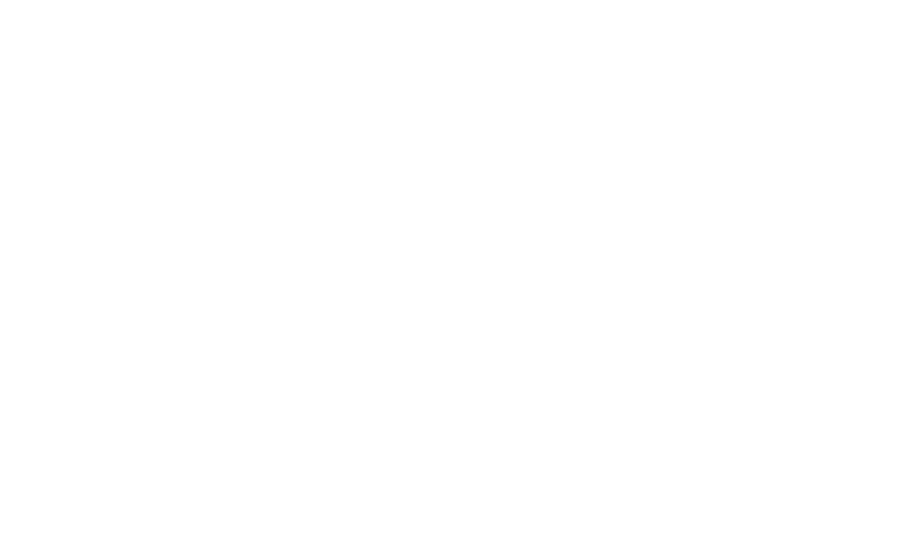

in
[ 2.11930615e-02  1.58185430e-02 -7.81606803e-03 -1.04222530e-02
 -1.08586582e-02  5.34638668e-03  1.46014898e-04  1.25288657e-02
 -1.57019005e-02 -2.33566802e-02  1.02091268e-02 -9.18552561e-03
 -3.31357232e-02  3.26673657e-02  1.35585788e-03 -1.55007763e-02
 -8.70590949e-03 -2.13342237e-03  8.78704091e-03 -3.25464450e-03
  9.40283117e-03  4.07019289e-02 -2.92805594e-01  1.92449732e-02
 -3.31783257e-03 -2.19957387e-01 -2.37814902e-03  4.57865418e-02
 -1.65694713e-02  9.24382855e-03 -3.91480752e-03 -5.38571991e-03
 -3.48765330e-01  1.08668717e-02  4.29947586e-02]
i:00 mean:-0.002378(0.014997) stdev:0.088722(0.010604) Nchanged:0 Nused:35 Nskipped:0
i:01 mean:-0.003191(0.007557) stdev:0.043412(0.005344) Nchanged:2 Nused:33 Nskipped:2
i:02 mean:0.003583(0.003344) stdev:0.018918(0.002365) Nchanged:1 Nused:32 Nskipped:3
i:03 mean:0.003583(0.003344) stdev:0.018918(0.002365) Nchanged:0 Nused:32 Nskipped:3


<IPython.core.display.Javascript object>


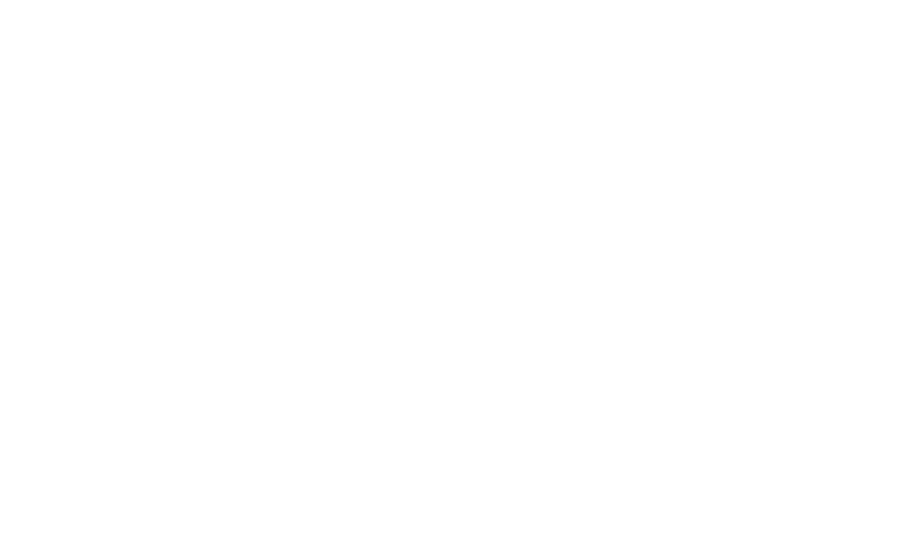

<IPython.core.display.Javascript object>


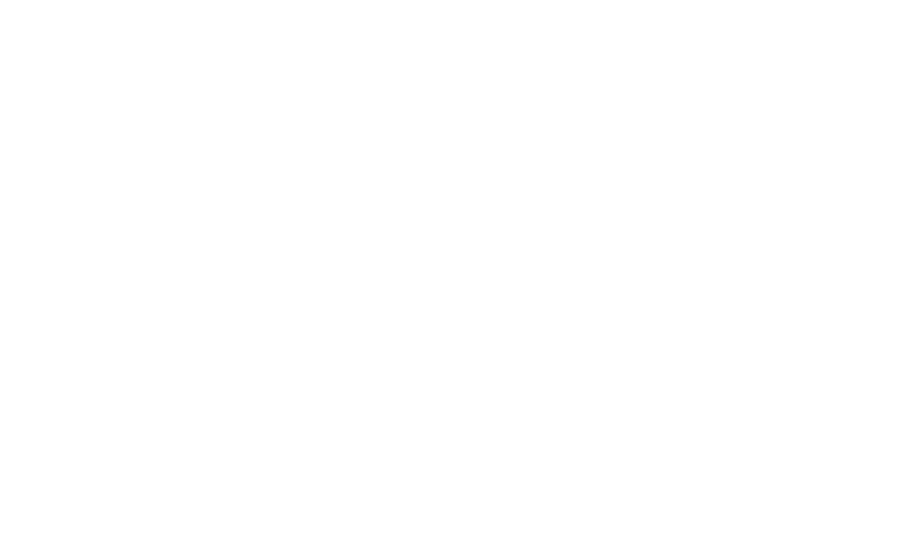

In [40]:
compare = np.array([['g-r','k-i']])#,['g-r','k-i'],['r-i','g-k']])
compare = np.array([['g-r','k-r'],['g-r','g-k']])#,['g-r','k-i']])
compare = np.array([['g-r','k-r'],['g-r','g-k'],['g-r','k-i']])
compare = np.array([['g-r','k-r'],['g-r','g-k'],['g-r','k-i'],['g-r','g-i']])
#compare = np.array([['g-r','k-r'],['g-r','k-i'],['g-r','g-k']])
bds = [(20.4,27)]#,(-0.01,0.01),(-0.01,0.01),(-0.01,0.01),(-0.01,0.01)]
zps = np.zeros(84) * np.nan
for j in range(84):
    j += 1
    #j = 40
    cind =  ((data['campaign'].values == 1) & (data['Channel'].values == j) & (kbe < .5))

    colours = {}
    colours['obs g-r'] = np.array([(gb - rb)[cind], (gbe + rbe)[cind]])
    colours['obs k-i'] = np.array([(kb - ib)[cind], (kbe + ibe)[cind]])
    colours['obs k-r'] = np.array([(kb - rb)[cind], (kbe + rbe)[cind]])
    colours['obs r-i'] = np.array([(rb - ib)[cind], (rbe + ibe)[cind]])
    colours['obs g-k'] = np.array([(gb - kb)[cind], (gbe + kbe)[cind]])
    colours['obs g-i'] = np.array([(gb - ib)[cind], (gbe + ibe)[cind]])
    colours['mod g-r'] = mags['g'] - mags['r']
    colours['mod r-i'] = mags['r'] - mags['i']
    colours['mod k-r'] = mags['k'] - mags['r']
    colours['mod k-i'] = mags['k'] - mags['i']
    colours['mod g-k'] = mags['g'] - mags['k']
    colours['mod g-i'] = mags['g'] - mags['i']
    keys = np.array(list(colours.keys()))
    #print(obs.shape)
    zp0 = 25.4
    Ak0 = Ag0 = Ar0 = Ai0 = 0
    k0 = [zp0,.1,.1,.1,.1]#np.array([zp0,Ak0,Ag0,Ar0,Ai0])
    bds = [(24,26),(0,1),(0,1),(0,1),(0,1)]
    #nll = lambda *args: -colours_like(*args)
    #res = op.minimize(nll, [25.4, 0, 0,0,0], args=(colours, compare, False))
    res = minimize(SLR_fit_multi,k0,args=(colours,compare,False))
    K0 = res.x
    print('in')
    c = Cut_data(K0,colours,compare,Plot=False)
    res = minimize(SLR_fit_multi,K0,args=(c,compare,False))
    #res = minimize(SLR_fit_multi,k0,args=(colours,compare,True),bounds=bds)
    if len(res.x) < 2:
        zps[j-1] = res.x
    else:
        if cind.any():
            zps[j-1] = res.x[0]
        else:
            zps[j-1] = np.nan
        #print(res.x)

    Plotter(res.x,c,compare,j,Close=True)
    Plotter(res.x,c,compare,j,Residuals=True,Close=True)

<IPython.core.display.Javascript object>


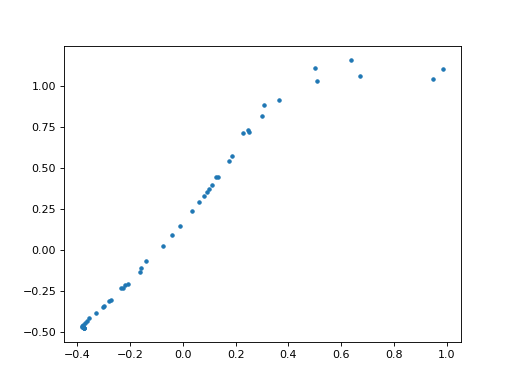

KeyError: 'mod i-z'

# Look at how each color fits

In [8]:
Compare = np.array([['g-r','g-k'],['g-r','k-r'],['g-r','k-i']])

In [21]:

Comp = np.array([['g-r','g-k'],['g-r','k-r'],['g-r','k-i']])#,['g-r','k-i'],['r-i','g-k']])
#compare = np.array([['g-r','k-r'],['g-r','g-k']])#,['r-i','g-k']])
#compare = np.array([['g-r','k-r'],['g-r','k-i'],['r-i','g-k']])
bds = [(20.4,27)]#,(-0.01,0.01),(-0.01,0.01),(-0.01,0.01),(-0.01,0.01)]
zps = np.zeros((3,84)) * np.nan
for i in range(len(Comp)):
    compare = Comp[np.newaxis,i,:]
    for j in range(84):
        j += 1
        #j = 40
        cind =  ((data['campaign'].values == 1) & (data['Channel'].values == j) & (kbe < 100))

        colours = {}
        colours['obs g-r'] = np.array([(gb - rb)[cind], (gbe + rbe)[cind]])
        colours['obs k-i'] = np.array([(kb - ib)[cind], (kbe + ibe)[cind]])
        colours['obs k-r'] = np.array([(kb - rb)[cind], (kbe + rbe)[cind]])
        colours['obs r-i'] = np.array([(rb - ib)[cind], (rbe + ibe)[cind]])
        colours['obs g-k'] = np.array([(gb - kb)[cind], (gbe + kbe)[cind]])
        colours['mod g-r'] = col1[good]
        colours['mod r-i'] = col2[good]
        colours['mod k-r'] = col3[good]
        colours['mod k-i'] = col4[good]
        colours['mod g-k'] = col5[good]
        keys = np.array(list(colours.keys()))
        #print(obs.shape)
        zp0 = 25.4
        Ak0 = Ag0 = Ar0 = Ai0 = 0
        k0 = [zp0]#np.array([zp0,Ak0,Ag0,Ar0,Ai0])
        #nll = lambda *args: -colours_like(*args)
        #res = op.minimize(nll, [25.4, 0, 0,0,0], args=(colours, compare, False))
        res = minimize(SLR_fit_multi,k0,args=(colours,compare,False))
        K0 = res.x
        c = Cut_data(K0,colours,compare,Plot=False)
        res = minimize(SLR_fit_multi,K0,args=(c,compare,False))
        #res = minimize(SLR_fit_multi,k0,args=(colours,compare,True),bounds=bds)
        if len(res.x) < 2:
            zps[i,j-1] = res.x
        else:
            if cind.any():
                zps[i,j-1] = res.x[0]
            else:
                zps[i,j-1] = np.nan
            #print(res.x)

        Plotter(res.x,c,compare,j)
        Plotter(res.x,c,compare,j,Residuals=True,Close=False)

cliptime
test
i:00 mean:0.000244(0.002165) stdev:0.015613(0.001531) Nchanged:0 Nused:52 Nskipped:0
i:01 mean:-0.000595(0.000714) stdev:0.005097(0.000505) Nchanged:1 Nused:51 Nskipped:1
i:02 mean:0.000371(0.000216) stdev:0.001514(0.000153) Nchanged:2 Nused:49 Nskipped:3
i:03 mean:0.000167(0.000070) stdev:0.000485(0.000050) Nchanged:1 Nused:48 Nskipped:4
i:04 mean:0.000201(0.000063) stdev:0.000429(0.000044) Nchanged:1 Nused:47 Nskipped:5
i:05 mean:0.000201(0.000063) stdev:0.000429(0.000044) Nchanged:0 Nused:47 Nskipped:5
mean:0.000201 (uncertainty:0.000063)
cliptime
test
i:00 mean:0.000198(0.002021) stdev:0.010695(0.001429) Nchanged:0 Nused:28 Nskipped:0
i:01 mean:0.000014(0.000555) stdev:0.002884(0.000392) Nchanged:1 Nused:27 Nskipped:1
i:02 mean:0.000425(0.000383) stdev:0.001953(0.000271) Nchanged:1 Nused:26 Nskipped:2
i:03 mean:0.000170(0.000295) stdev:0.001475(0.000209) Nchanged:1 Nused:25 Nskipped:3
i:04 mean:0.000170(0.000295) stdev:0.001475(0.000209) Nchanged:0 Nused:25 Nskipped:3

cliptime
test
i:00 mean:-0.000065(0.000442) stdev:0.002998(0.000313) Nchanged:0 Nused:46 Nskipped:0
i:01 mean:0.000014(0.000204) stdev:0.001353(0.000144) Nchanged:2 Nused:44 Nskipped:2
i:02 mean:0.000021(0.000136) stdev:0.000884(0.000096) Nchanged:2 Nused:42 Nskipped:4
i:03 mean:0.000021(0.000136) stdev:0.000884(0.000096) Nchanged:0 Nused:42 Nskipped:4
mean:0.000021 (uncertainty:0.000136)
cliptime
test
i:00 mean:-0.000321(0.003728) stdev:0.024731(0.002636) Nchanged:0 Nused:44 Nskipped:0
i:01 mean:-0.000790(0.001180) stdev:0.007649(0.000835) Nchanged:2 Nused:42 Nskipped:2
i:02 mean:-0.000578(0.000350) stdev:0.002211(0.000247) Nchanged:2 Nused:40 Nskipped:4
i:03 mean:-0.000307(0.000224) stdev:0.001399(0.000158) Nchanged:1 Nused:39 Nskipped:5
i:04 mean:-0.000455(0.000171) stdev:0.001055(0.000121) Nchanged:1 Nused:38 Nskipped:6
i:05 mean:-0.000455(0.000171) stdev:0.001055(0.000121) Nchanged:0 Nused:38 Nskipped:6
mean:-0.000455 (uncertainty:0.000171)
cliptime
test
i:00 mean:0.000475(0.00162

cliptime
test
i:00 mean:0.000140(0.001871) stdev:0.010581(0.001323) Nchanged:0 Nused:32 Nskipped:0
i:01 mean:0.000248(0.000364) stdev:0.002025(0.000257) Nchanged:1 Nused:31 Nskipped:1
i:02 mean:0.000041(0.000309) stdev:0.001690(0.000218) Nchanged:1 Nused:30 Nskipped:2
i:03 mean:0.000041(0.000309) stdev:0.001690(0.000218) Nchanged:0 Nused:30 Nskipped:2
mean:0.000041 (uncertainty:0.000309)
cliptime
test
i:00 mean:-0.000286(0.001358) stdev:0.007563(0.000961) Nchanged:0 Nused:31 Nskipped:0
i:01 mean:-0.001686(0.000653) stdev:0.003575(0.000462) Nchanged:1 Nused:30 Nskipped:1
i:02 mean:-0.001201(0.000448) stdev:0.002410(0.000316) Nchanged:1 Nused:29 Nskipped:2
i:03 mean:-0.000857(0.000294) stdev:0.001553(0.000208) Nchanged:1 Nused:28 Nskipped:3
i:04 mean:-0.000857(0.000294) stdev:0.001553(0.000208) Nchanged:0 Nused:28 Nskipped:3
mean:-0.000857 (uncertainty:0.000294)
cliptime
test
i:00 mean:0.008779(0.022439) stdev:0.145419(0.015866) Nchanged:0 Nused:42 Nskipped:0
i:01 mean:0.013798(0.003291)

cliptime
test
i:00 mean:0.002321(0.021872) stdev:0.136588(0.015466) Nchanged:0 Nused:39 Nskipped:0
i:01 mean:-0.003829(0.004597) stdev:0.028340(0.003251) Nchanged:1 Nused:38 Nskipped:1
i:02 mean:0.000360(0.001881) stdev:0.011445(0.001330) Nchanged:1 Nused:37 Nskipped:2
i:03 mean:0.001907(0.001084) stdev:0.006504(0.000767) Nchanged:1 Nused:36 Nskipped:3
i:04 mean:0.002713(0.000740) stdev:0.004379(0.000523) Nchanged:1 Nused:35 Nskipped:4
i:05 mean:0.003159(0.000606) stdev:0.003531(0.000428) Nchanged:1 Nused:34 Nskipped:5
i:06 mean:0.002426(0.000338) stdev:0.001910(0.000239) Nchanged:2 Nused:32 Nskipped:7
i:07 mean:0.002426(0.000338) stdev:0.001910(0.000239) Nchanged:0 Nused:32 Nskipped:7
mean:0.002426 (uncertainty:0.000338)
cliptime
test
i:00 mean:0.000427(0.010263) stdev:0.068076(0.007257) Nchanged:0 Nused:44 Nskipped:0
i:01 mean:-0.000830(0.006202) stdev:0.040671(0.004386) Nchanged:1 Nused:43 Nskipped:1
i:02 mean:0.001545(0.002530) stdev:0.015999(0.001789) Nchanged:3 Nused:40 Nskipped:

cliptime
test
i:00 mean:-0.001289(0.013583) stdev:0.086977(0.009605) Nchanged:0 Nused:41 Nskipped:0
i:01 mean:-0.002870(0.001196) stdev:0.007561(0.000845) Nchanged:1 Nused:40 Nskipped:1
i:02 mean:-0.001947(0.000772) stdev:0.004821(0.000546) Nchanged:1 Nused:39 Nskipped:2
i:03 mean:-0.002470(0.000580) stdev:0.003575(0.000410) Nchanged:1 Nused:38 Nskipped:3
i:04 mean:-0.002142(0.000490) stdev:0.002982(0.000347) Nchanged:1 Nused:37 Nskipped:4
i:05 mean:-0.002142(0.000490) stdev:0.002982(0.000347) Nchanged:0 Nused:37 Nskipped:4
mean:-0.002142 (uncertainty:0.000490)
cliptime
test
i:00 mean:0.004087(0.078141) stdev:0.500349(0.055254) Nchanged:0 Nused:41 Nskipped:0
i:01 mean:-0.010508(0.012208) stdev:0.077212(0.008633) Nchanged:1 Nused:40 Nskipped:1
i:02 mean:0.000536(0.005181) stdev:0.032356(0.003664) Nchanged:1 Nused:39 Nskipped:2
i:03 mean:0.007485(0.001684) stdev:0.010245(0.001191) Nchanged:2 Nused:37 Nskipped:4
i:04 mean:0.006439(0.001351) stdev:0.008105(0.000955) Nchanged:1 Nused:36 Nsk

KeyboardInterrupt: 

In [24]:
zps.shape

(84,)

In [21]:
zp = zps.copy()
zp[zp==25.4] = np.nan

<IPython.core.display.Javascript object>


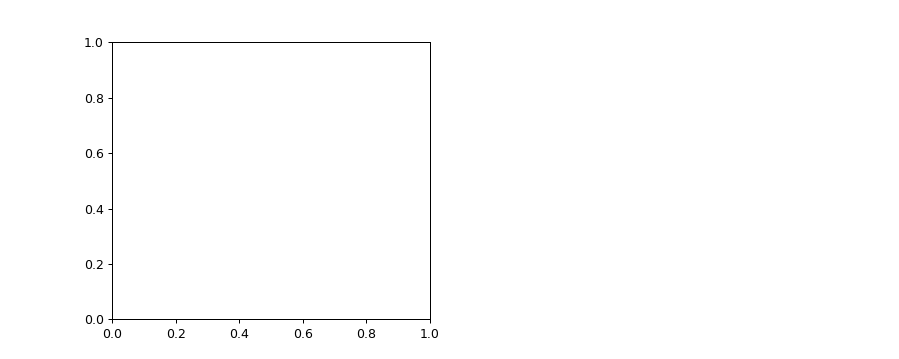

IndexError: too many indices for array

In [22]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(zp[0,:],'g.',label='g-k')
plt.plot(zp[1,:],'rx',label='k-r')
plt.plot(zp[2,:],'k+',label='k-i')
plt.minorticks_on()
plt.xlabel('Channel')
plt.ylabel('Zeropoint')
plt.legend(loc=4)

plt.subplot(122)
plt.plot(zp[0,:],'g.',label='g-k')
plt.plot(zp[1,:],'rx',label='k-r')
plt.plot(zp[2,:]+.04,'k+',label='k-i + 0.04')
plt.minorticks_on()
plt.xlabel('Channel')
#plt.ylabel('Zeropoint')
plt.legend()
plt.tight_layout()
#plt.savefig('Kzp_individual_colours.pdf')

<IPython.core.display.Javascript object>


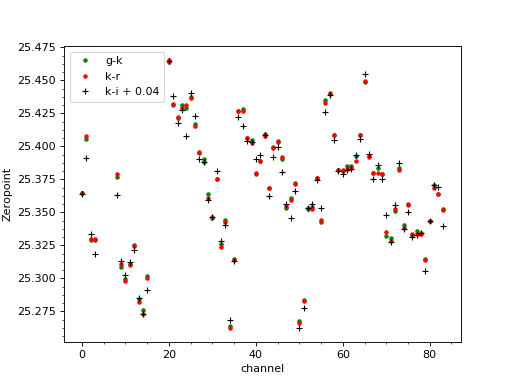

In [142]:
plt.figure()
plt.plot(zp[0,:],'g.',label='g-k')
plt.plot(zp[1,:],'r.',label='k-r')
plt.plot(zp[2,:]+.04,'k+',label='k-i + 0.04')
plt.minorticks_on()
plt.xlabel('channel')
plt.ylabel('Zeropoint')
plt.legend()

In [43]:
calcaverage = sigmacut.calcaverageclass()
calcaverage.calcaverage_sigmacutloop(dist.flatten(),noise=ob_y[1,:]*100,verbose=2,Nsigma=2
                                     ,median_firstiteration=True,saveused=True)

i:00 mean:8.611299(5.579153) stdev:40.231847 X2norm:0.000000 Nchanged:0 Nused:53 Nskipped:0
i:01 mean:8.584390(0.102014) stdev:0.625185 X2norm:1.976030 Nchanged:38 Nused:15 Nskipped:38
i:02 mean:8.523940(0.105959) stdev:0.610663 X2norm:1.785392 Nchanged:1 Nused:14 Nskipped:39
i:03 mean:8.523940(0.105959) stdev:0.610663 X2norm:1.785392 Nchanged:0 Nused:14 Nskipped:39


0

In [44]:
calcaverage.use

array([False, False, False, False, False,  True, False, False, False,
       False, False, False,  True, False, False,  True, False,  True,
        True,  True, False, False, False, False, False, False,  True,
       False, False, False,  True, False, False, False, False,  True,
        True, False,  True, False, False,  True, False,  True, False,
       False, False, False, False,  True, False, False, False])

<IPython.core.display.Javascript object>


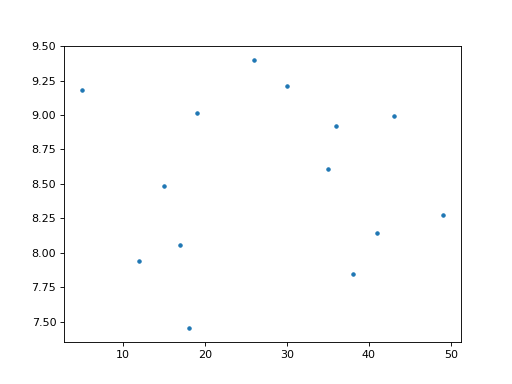

In [46]:
clipped =dist.flatten().copy() 
clipped[calcaverage.clipped] = np.nan
plt.figure()
#plt.plot(dist.flatten(),'.')
plt.plot(clipped,'.')

In [34]:
ob_y[1,:].shape

(53,)

In [36]:
dist.flatten().shape

(53,)

<IPython.core.display.Javascript object>


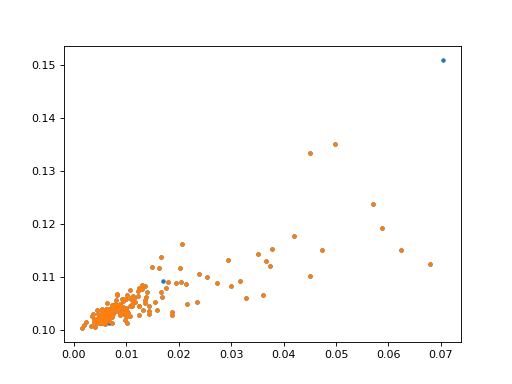

In [73]:
plt.figure()
plt.plot(colours['obs g-r'][1],colours['obs k-r'][1],'.')
plt.plot(c['obs g-r'][1],c['obs k-r'][1],'.')


In [54]:
c.keys()

dict_keys(['obs g-r', 'obs k-i', 'obs k-r', 'obs r-i', 'obs g-k', 'mod g-r', 'mod r-i', 'mod k-r', 'mod k-i', 'mod g-k'])